# Branch 2

# Data Preprocessing
Data resource:
*   [GWdatabase.h5](https://zenodo.org/record/201145#.YDNpnS0RonN)

Reference:
*   [How to find out the real download URL on download sites that use redirects](https://superuser.com/questions/27243/how-to-find-out-the-real-download-url-on-download-sites-that-use-redirects)
*   [HDFView Software](https://www.hdfgroup.org/downloads/hdfview/?https%3A%2F%2Fwww.hdfgroup.org%2Fdownloads%2Fhdfview%2F)


## Import Packages and Set the ENV
Need to use GPU/TPU in the "runtime type" in Colab.

In [1]:
import h5py  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import shutil

In [ ]:
# Colab: mute this cell for colab
# #If using GPU.
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load raw data

In [2]:
# Colab: download data from web
!wget -O GWdatabase.h5 https://zenodo.org/record/201145/files/GWdatabase.h5?download=1

--2021-04-22 05:28:34--  https://zenodo.org/record/201145/files/GWdatabase.h5?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308066035 (294M) [application/octet-stream]
Saving to: ‘GWdatabase.h5’

GWdatabase.h5       100%[===================>] 293.79M  4.54MB/s    in 42s     

2021-04-22 05:29:18 (6.95 MB/s) - ‘GWdatabase.h5’ saved [308066035/308066035]



In [3]:
#read database.
f = h5py.File('GWdatabase.h5','r')   
f.keys()

<KeysViewHDF5 ['reduced_data', 'waveforms', 'yeofrho']>

In [4]:
def list_fail_case(f):
  '''
  Create a list that contains all the failure cases.
  f: h5 file.
  return: 
  fail_num: list.
  fail_case: list.
  fail_list: list.
  '''
  fail_num = []
  index = 0
  for item in f['reduced_data']['tbounce(s)']:
      if(item == -1):
          fail_num.append(index)
      index += 1
  fail_case = []
  for index in fail_num:
      fail_case.append([f['reduced_data']['A(km)'][index],f['reduced_data']['omega_0(rad|s)'][index],f['reduced_data']['EOS'][index]])
  fail_list= []
  for item in fail_case:
      tmp = str(item[2]).split("b'")[1].split("'")[0]
      tmp = "A" + str(int(item[0])) + "w" + str(item[1]) + "0_" + tmp
      fail_list.append(tmp) 
  return fail_num, fail_case, fail_list

In [5]:
fail_num, fail_case, fail_list = list_fail_case(f)
print(fail_num)
print(fail_case)
print(fail_list)

[157, 255, 353, 427, 440, 450, 451, 525, 538, 548, 549, 623, 636, 646, 647, 941, 972, 992, 993, 994, 995, 1012, 1013, 1014, 1015, 1026, 1027, 1028, 1036, 1037, 1038, 1039, 1092, 1093, 1111, 1112, 1113, 1125, 1126, 1134, 1135, 1136, 1137, 1190, 1191, 1209, 1210, 1211, 1223, 1224, 1232, 1233, 1234, 1235, 1333, 1431, 1529, 1627, 1725, 1823]
[[10000.0, 5.5, b'SFHo'], [10000.0, 5.5, b'BHBL'], [10000.0, 5.5, b'BHBLP'], [634.0, 9.5, b'LS180'], [1268.0, 6.5, b'LS180'], [10000.0, 5.0, b'LS180'], [10000.0, 5.5, b'LS180'], [634.0, 9.5, b'LS220'], [1268.0, 6.5, b'LS220'], [10000.0, 5.0, b'LS220'], [10000.0, 5.5, b'LS220'], [634.0, 9.5, b'LS375'], [1268.0, 6.5, b'LS375'], [10000.0, 5.0, b'LS375'], [10000.0, 5.5, b'LS375'], [10000.0, 5.5, b'SFHx'], [300.0, 15.5, b'GShenNL3'], [467.0, 10.0, b'GShenNL3'], [467.0, 10.5, b'GShenNL3'], [467.0, 11.0, b'GShenNL3'], [467.0, 11.5, b'GShenNL3'], [634.0, 8.0, b'GShenNL3'], [634.0, 8.5, b'GShenNL3'], [634.0, 9.0, b'GShenNL3'], [634.0, 9.5, b'GShenNL3'], [1268.0

In [ ]:
#Get fpeak of all success cases
# fpeak_list = []
# for index in range(len(f['reduced_data']['A(km)'])):
#     if(index not in fail_num):
#         tmp = str(f['reduced_data']['EOS'][index]).split("b'")[1].split("'")[0]
#         tmp = "A" + str(int(f['reduced_data']['A(km)'][index])) + "w" + str(f['reduced_data']['omega_0(rad|s)'][index]) + "0_" + tmp
#         fpeak_list.append([tmp,f['reduced_data']['fpeak(Hz)'][index]])  
# fpeak_name = np.array(fpeak_list)[:,0]
# fpeak_feature = np.array(fpeak_list)[:,1]
# fpeak = []
# index = 0
# for item in f['waveforms']:
#     if(item not in fail_list):
#         fpeak.append(float(fpeak_feature[np.where(fpeak_name == item)[0][0]]))
#     index += 1
# fpeak = np.array(fpeak)

In [ ]:
#classify A first and predcit omega(A_num is the list of all the cases that have the particular A value)
# A_num = []
# index = 0
# for item in f['waveforms']:
#     if(item not in fail_list):
#         if(float(item.split('_')[0].split('w')[0].split('A')[1]) == 634):
#             A_num.append(index)
#     index+=1
# len(A_num)

## Create Y

In [6]:
def prepare_y(f, fail_list, y):
  '''
  Prepare labels.
  f: h5 file.
  fail_list: list.
  y: str. Use either 'w', 'EOS', or 'A'.
  return: array.
  '''
  labels = []
  index = 0
  for item in f['waveforms']:
    if(item not in fail_list):
        if y == 'w':
          labels.append(float(item.split('_')[0].split('w')[1]))
        elif y == 'EOS':
          labels.append(str(item.split('_')[1]))
        elif y == 'A':
          labels.append(str(item.split('_')[0].split('w')[0].split('A')[1]))
        else:
          sys.exit("\n Use either 'w', 'EOS', or 'A' as the input. Check prepare_y().")
    index += 1

  # turn the type of labels into array.
  labels = np.array(labels)

  return labels

In [7]:
labels = prepare_y(f, fail_list, 'EOS')
print(type(labels))
print('data size =', len(labels))
print('labels = ', np.unique(labels))
print('number of labels = ', len(np.unique(labels)))

<class 'numpy.ndarray'>
data size = 1764
labels =  ['BHBL' 'BHBLP' 'GShenFSU1.7' 'GShenFSU2.1' 'GShenNL3' 'HSDD2' 'HSFSG'
 'HSIUF' 'HSNL3' 'HSTM1' 'HSTMA' 'HShen' 'HShenH' 'LS180' 'LS220' 'LS375'
 'SFHo' 'SFHx']
number of labels =  18


In [ ]:
#signal preprocessing used by the paper.(We don't need it.)
from scipy import signal
from scipy.fft import fft, fftshift

## Create X

In [ ]:
# remove a directory and all its contents.
# shutil.rmtree('./Final_EOS')

In [8]:
def prepare_x_image(f, fail_list, output_folder='./ftr', time_range=[-0.01, 0.006], resolution={'figsize':(4, 4),'dpi':64}, ftype='jpeg', overwrite=False):
  '''
  Prepare features (image).
  f: h5 file.
  fail_list: list.
  output_folder: str.
  time_range: list.
  resolution: dict. Default=256*256.
  ftype: str. The file type.
  overwrite: boolean. whether to overwrite the exist files.
  return
  '''
  # create output folder
  if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
  # create output file name
  w = resolution['figsize'][0]*resolution['dpi']
  h = resolution['figsize'][1]*resolution['dpi']
  fname0 = "img%s*%s_%sto%s" % (str(w), str(h), str(time_range[0]), str(time_range[1]))

  #draw the image which is 256*256.
  index = 0
  for item in f['waveforms']:
      if (item not in fail_list):
          # save path
          fname = "%s/%s_%s.%s" % (output_folder, str(index), fname0, ftype)
          
          # if the file is already exist and needs no overwrite, then don't recreate the ftr again
          if all([os.path.exists(fname), not overwrite]):
              index += 1
              continue

          # create x image
          #for j in range(5):
          x = f['waveforms'][item]['t-tb(s)']
          y = f['waveforms'][item]['strain*dist(cm)']
          y = np.array(y)
          x = np.array(x)
          
          plt.figure(figsize=resolution['figsize'], dpi=resolution['dpi'])
          plt.plot(x,y/3.08567758e22*1e21)  # why divided by this number?
          plt.xlim(time_range[0], time_range[1])
          plt.ylim(-20, 20) # why use this numbers?
          plt.axis('off')
          
          plt.savefig(fname,dpi=resolution['dpi'])
      index += 1

  return

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

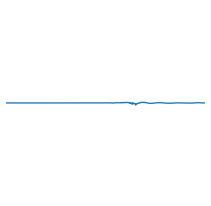

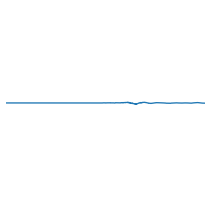

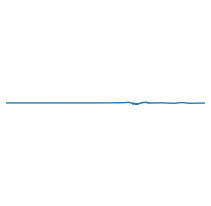

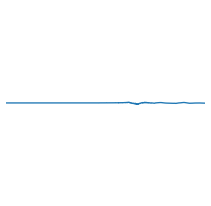

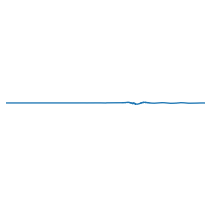

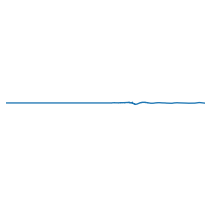

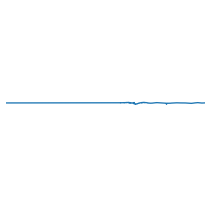

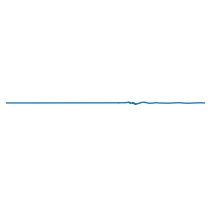

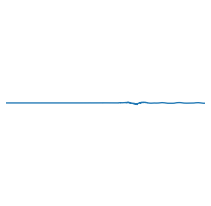

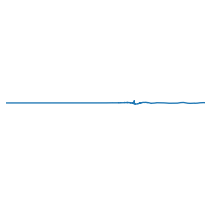

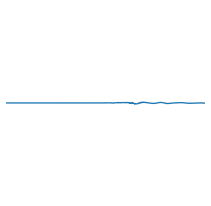

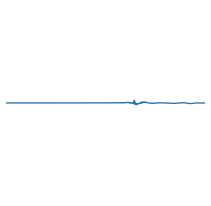

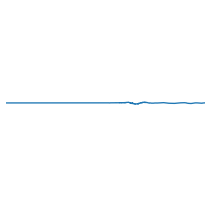

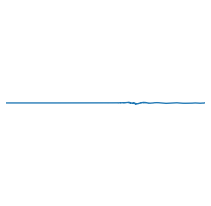

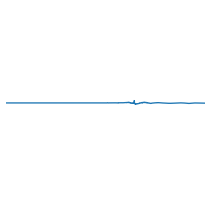

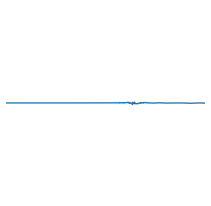

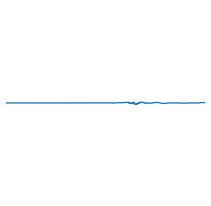

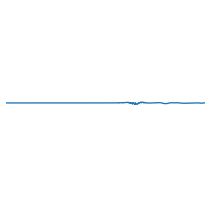

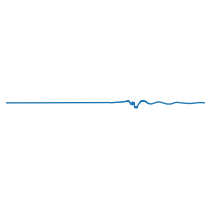

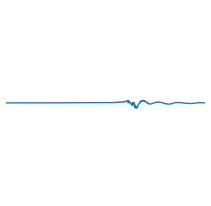

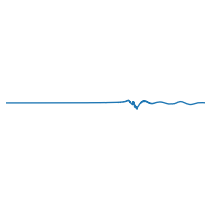

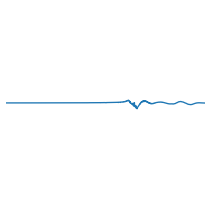

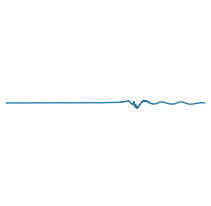

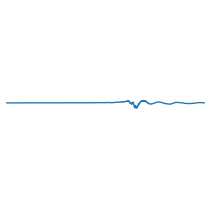

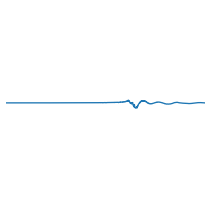

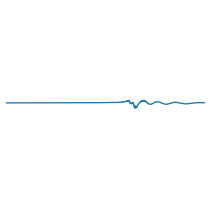

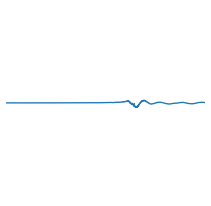

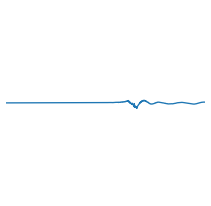

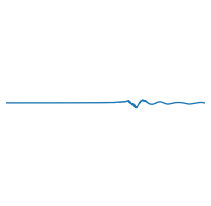

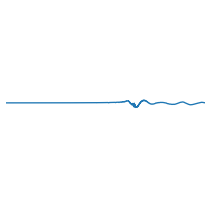

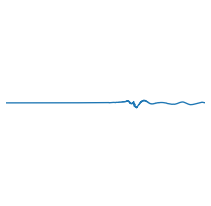

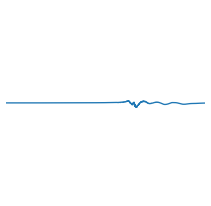

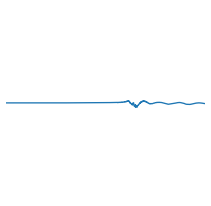

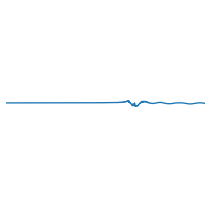

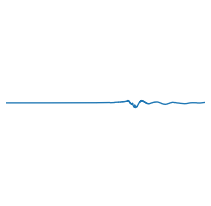

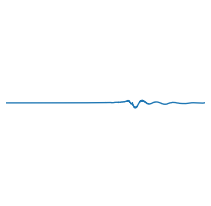

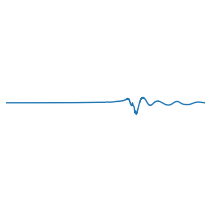

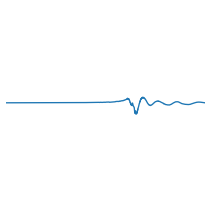

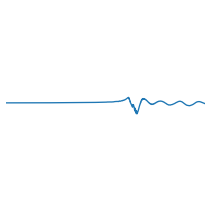

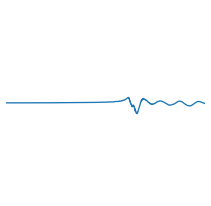

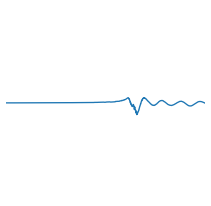

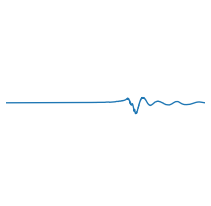

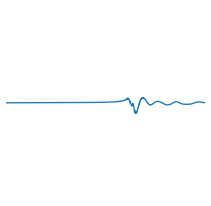

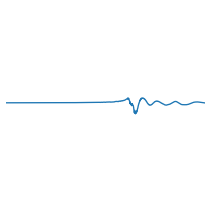

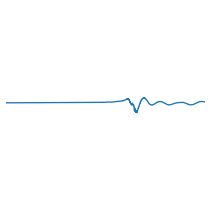

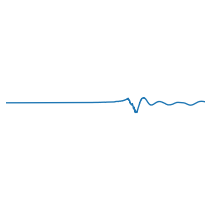

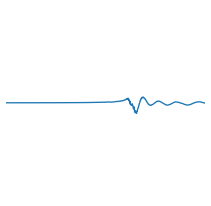

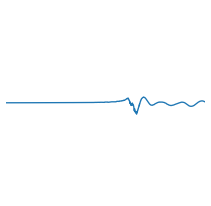

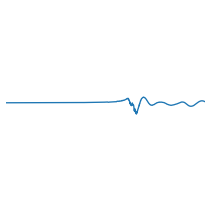

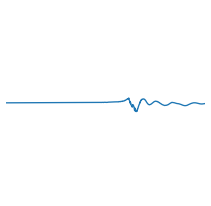

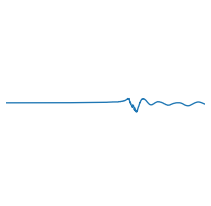

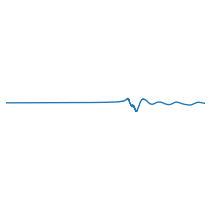

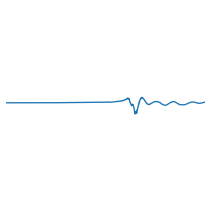

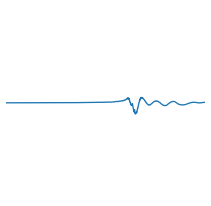

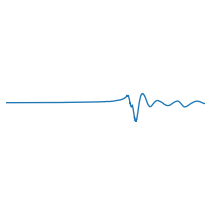

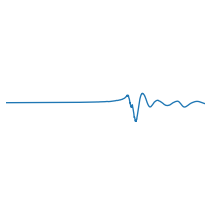

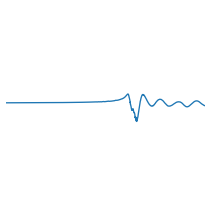

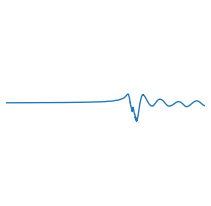

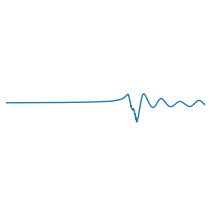

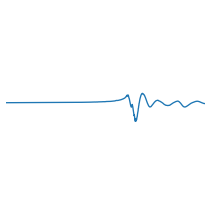

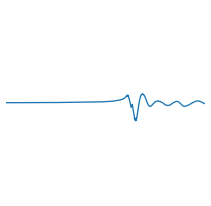

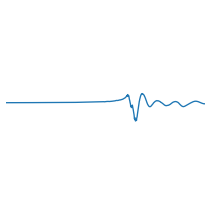

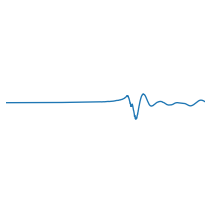

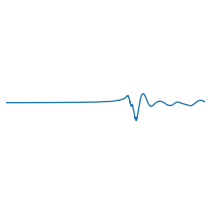

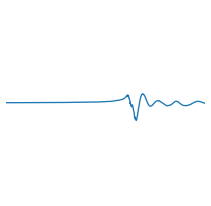

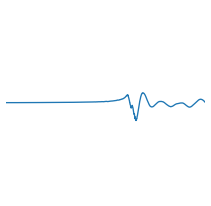

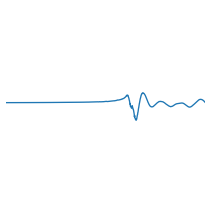

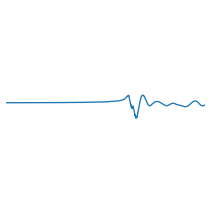

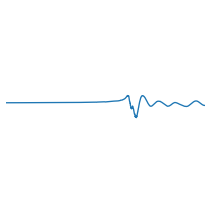

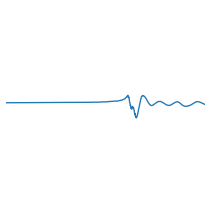

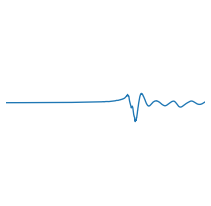

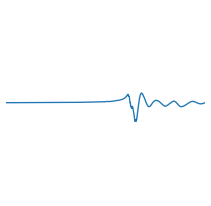

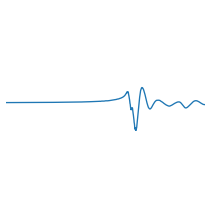

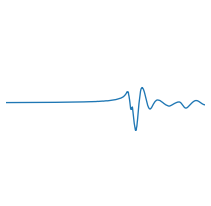

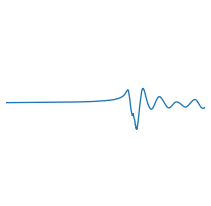

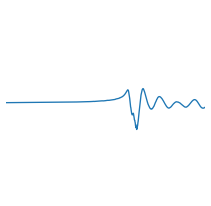

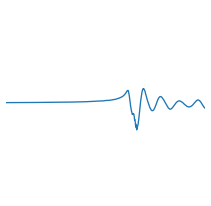

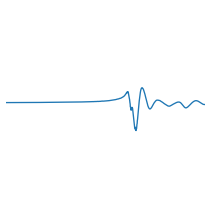

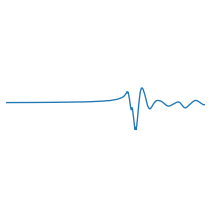

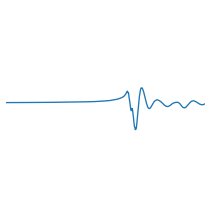

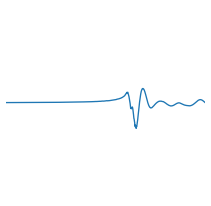

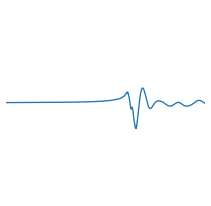

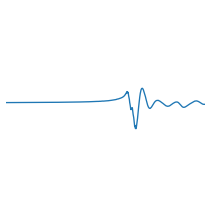

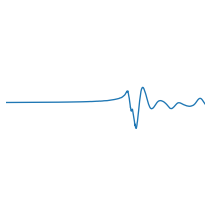

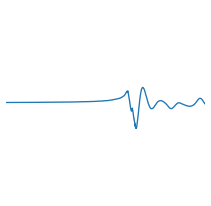

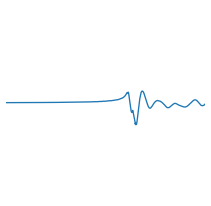

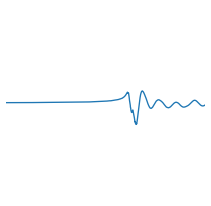

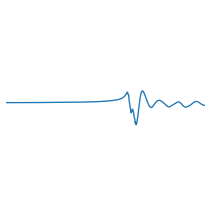

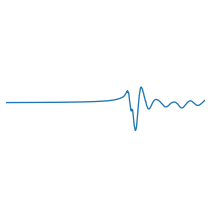

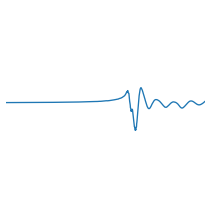

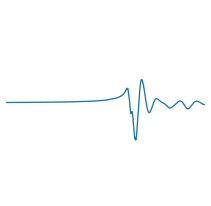

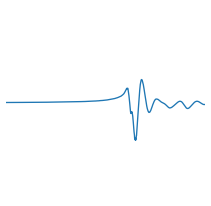

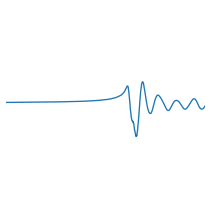

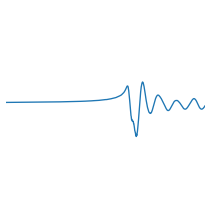

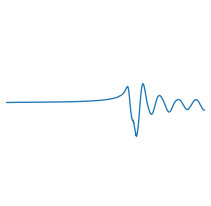

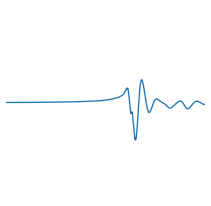

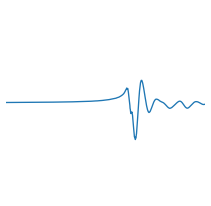

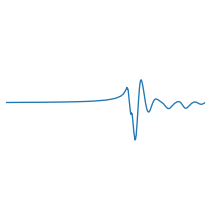

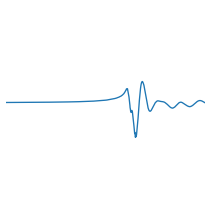

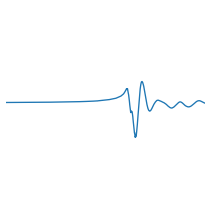

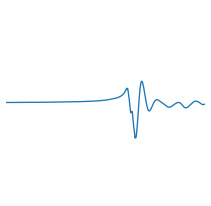

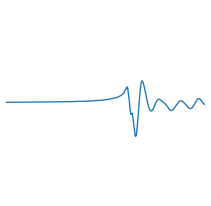

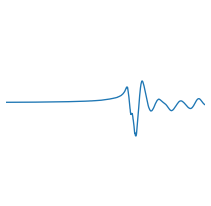

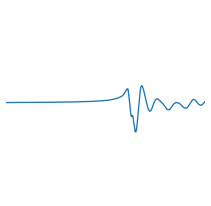

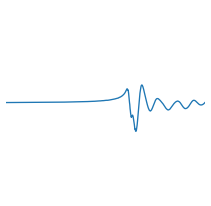

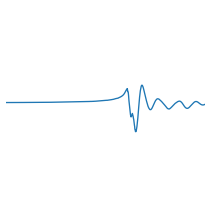

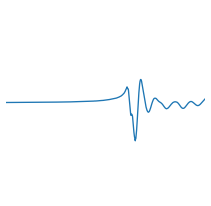

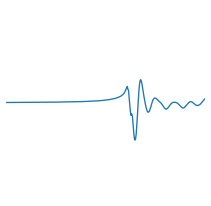

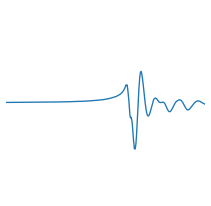

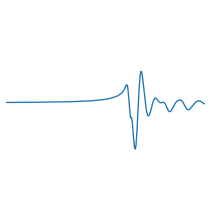

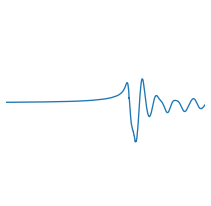

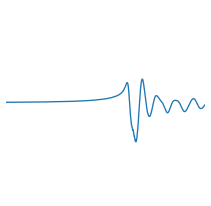

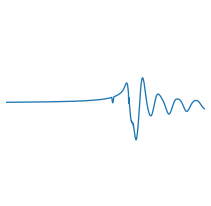

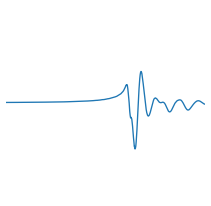

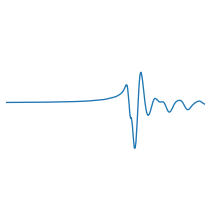

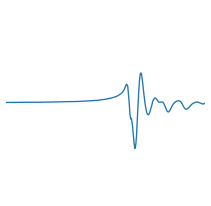

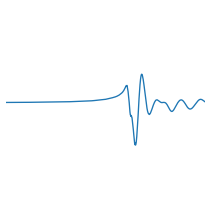

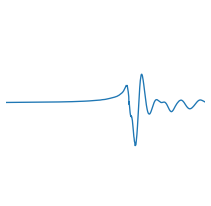

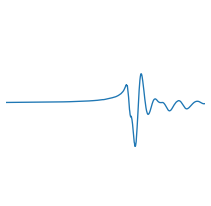

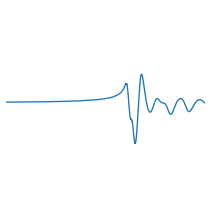

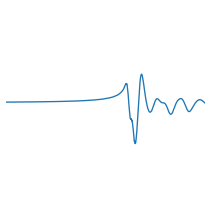

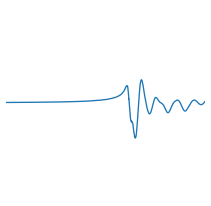

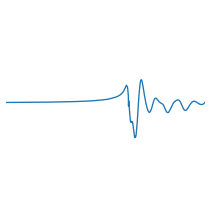

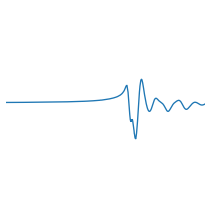

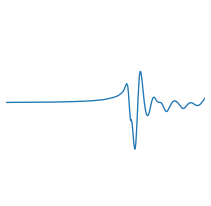

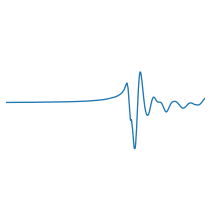

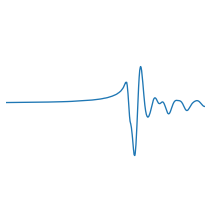

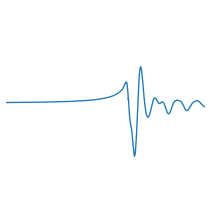

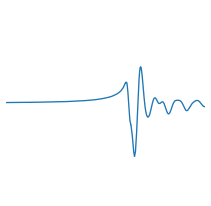

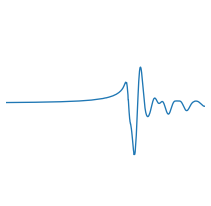

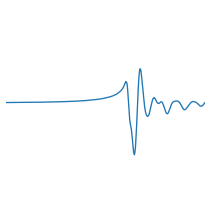

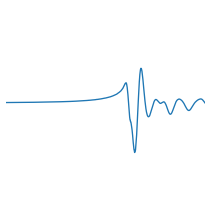

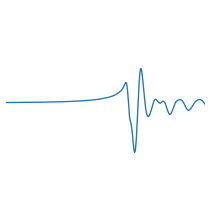

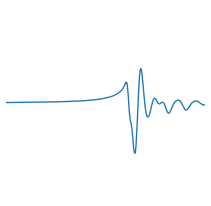

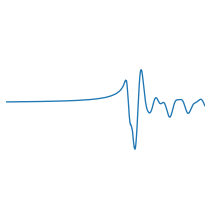

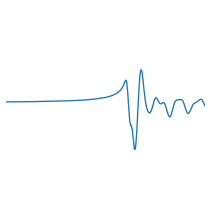

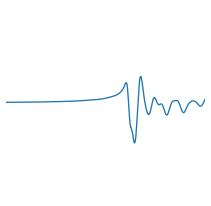

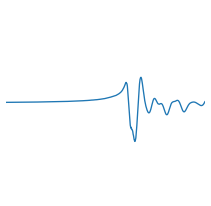

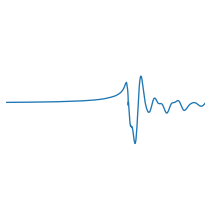

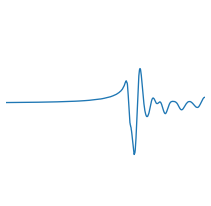

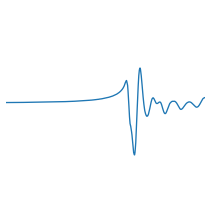

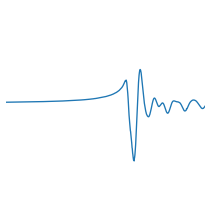

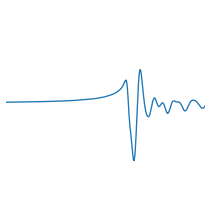

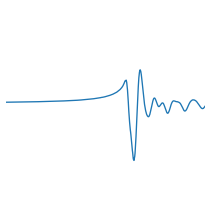

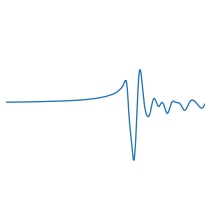

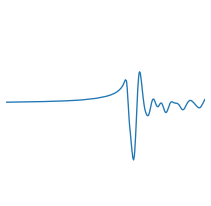

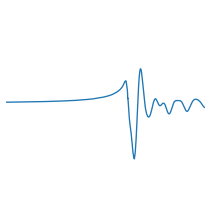

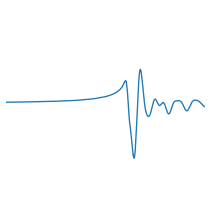

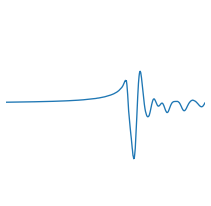

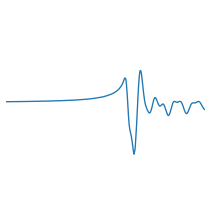

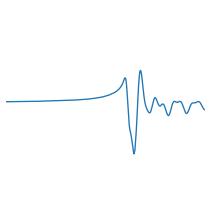

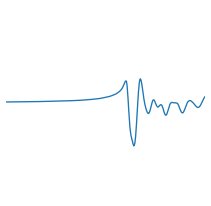

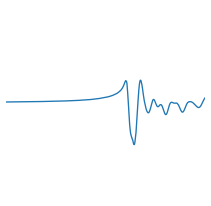

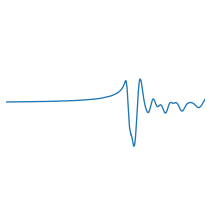

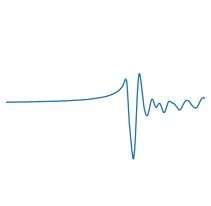

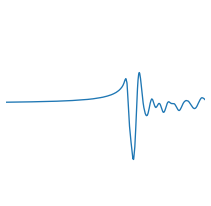

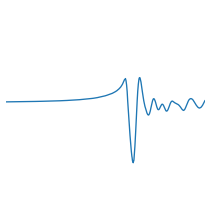

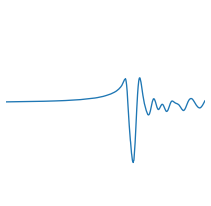

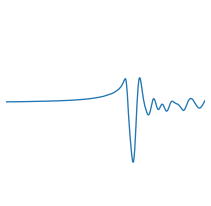

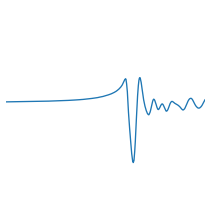

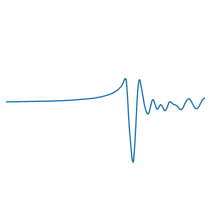

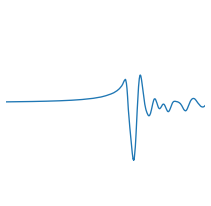

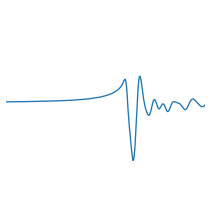

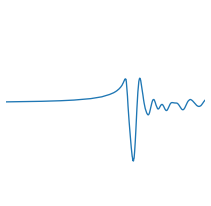

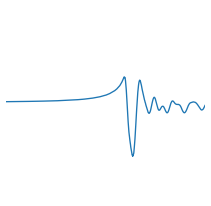

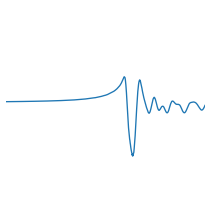

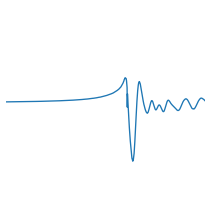

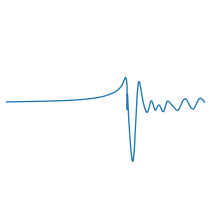

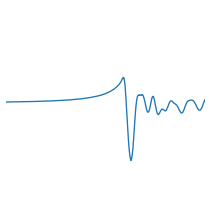

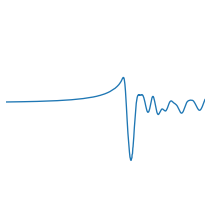

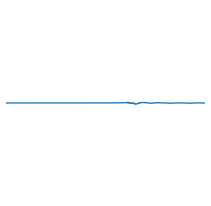

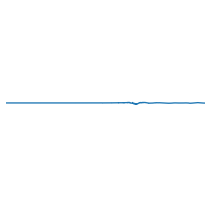

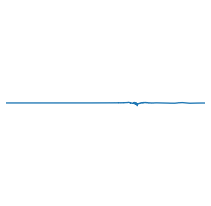

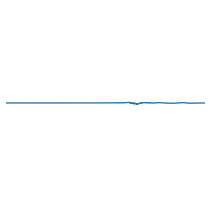

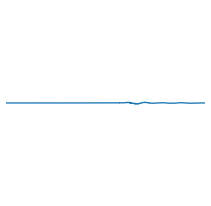

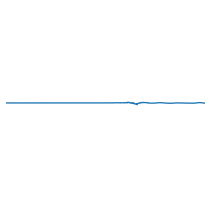

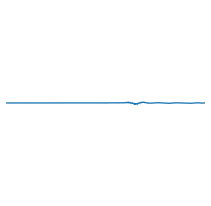

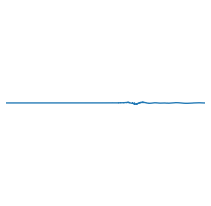

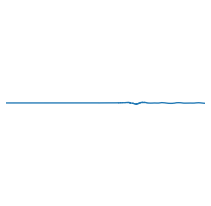

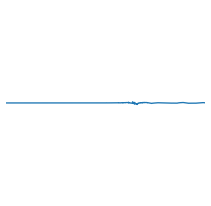

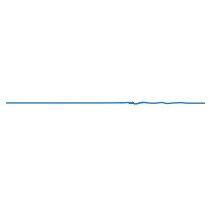

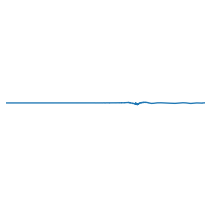

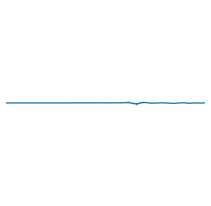

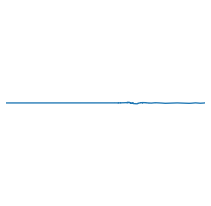

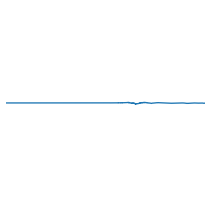

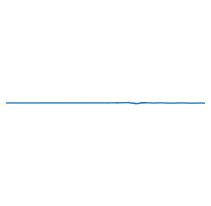

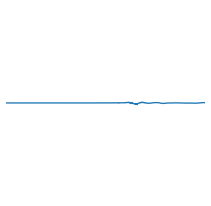

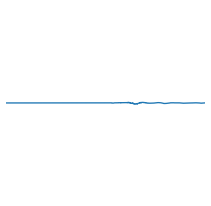

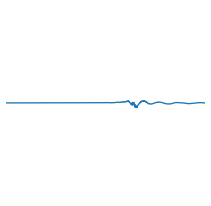

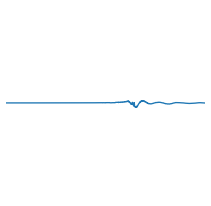

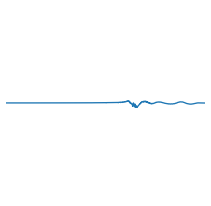

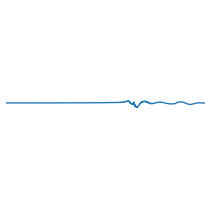

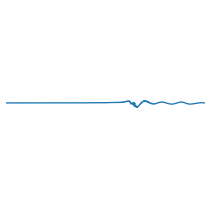

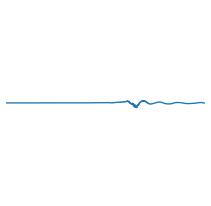

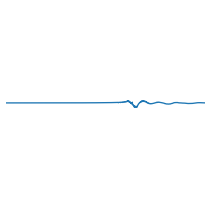

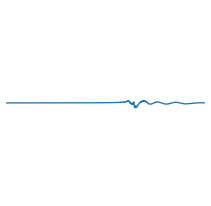

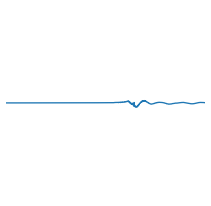

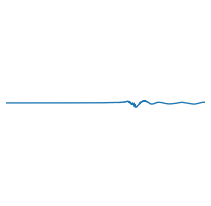

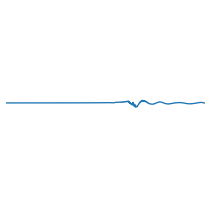

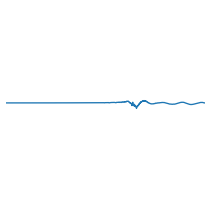

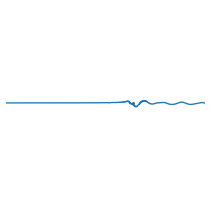

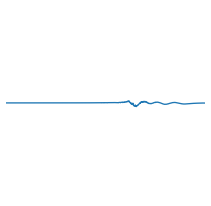

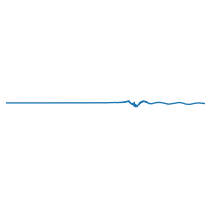

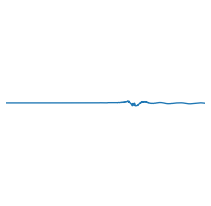

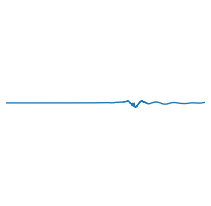

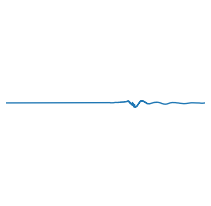

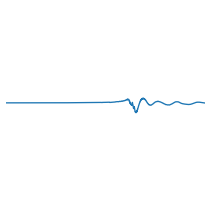

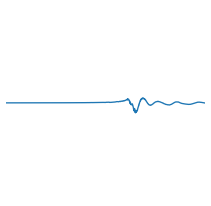

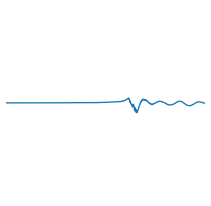

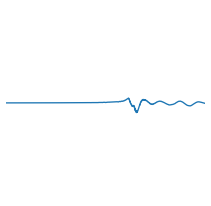

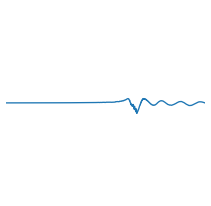

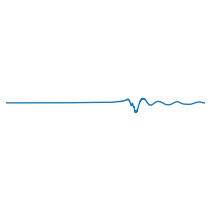

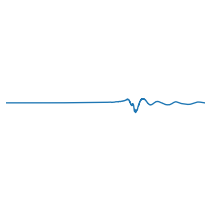

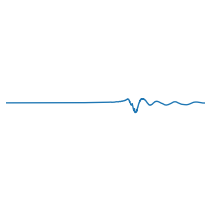

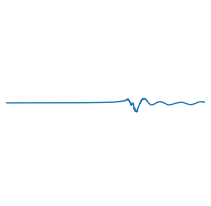

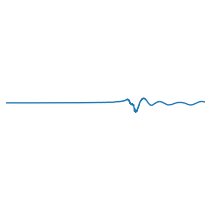

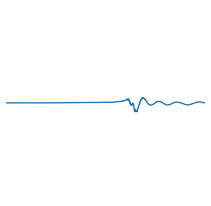

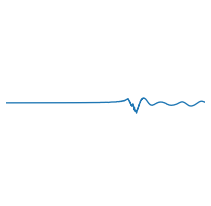

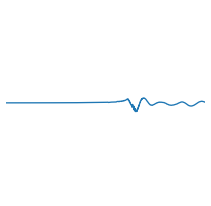

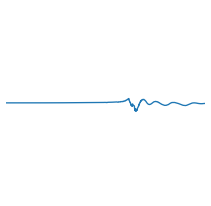

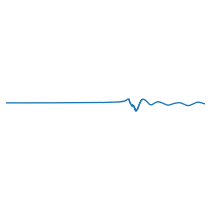

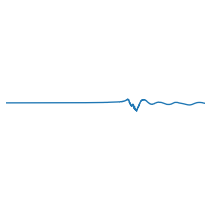

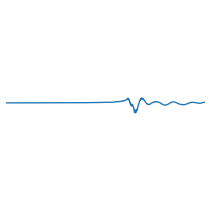

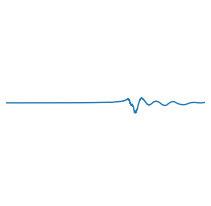

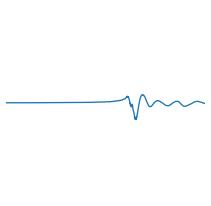

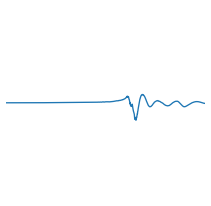

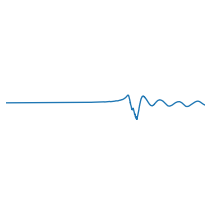

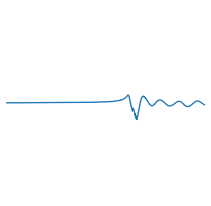

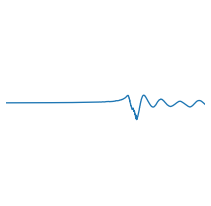

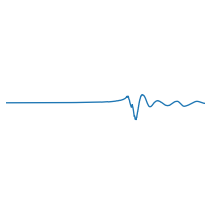

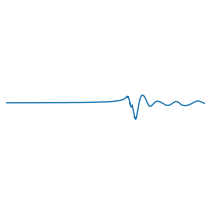

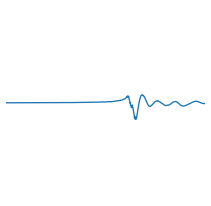

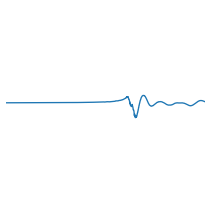

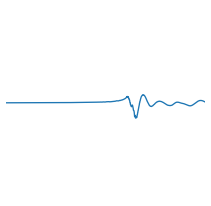

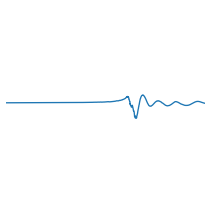

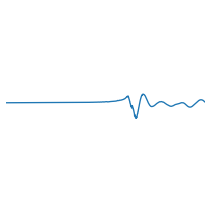

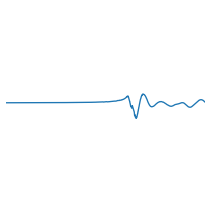

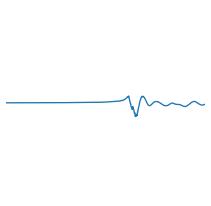

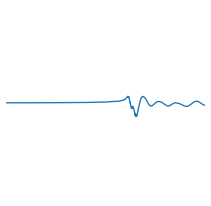

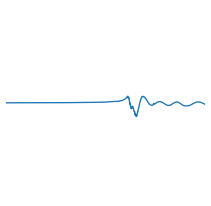

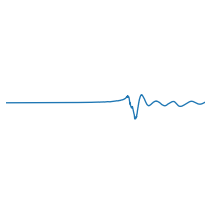

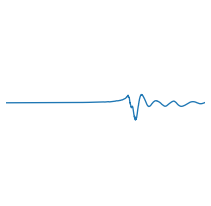

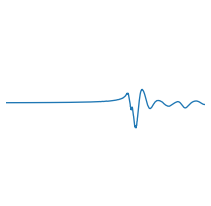

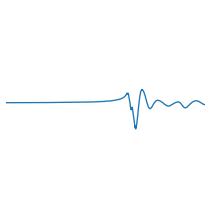

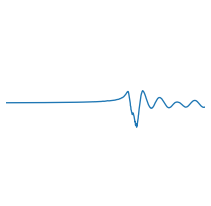

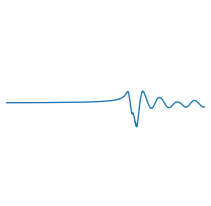

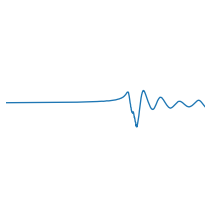

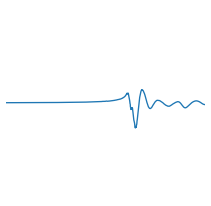

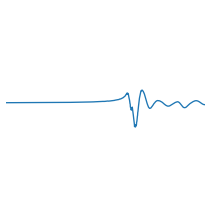

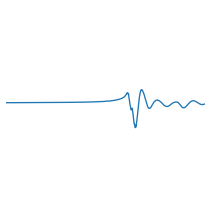

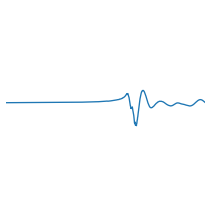

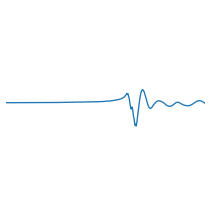

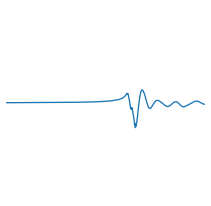

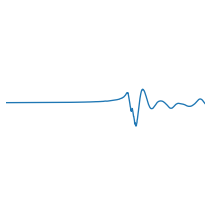

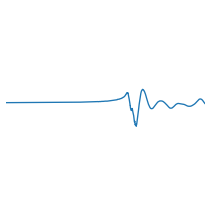

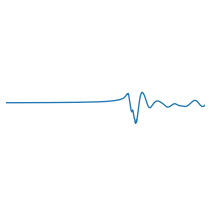

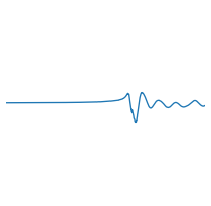

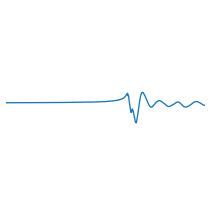

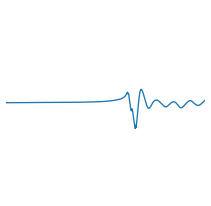

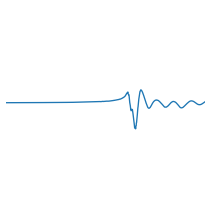

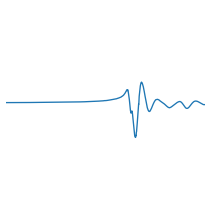

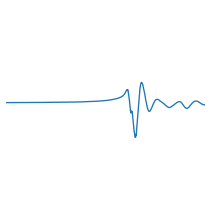

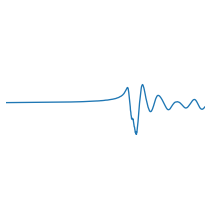

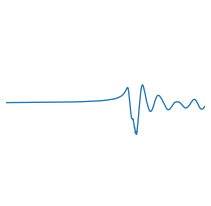

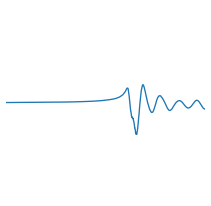

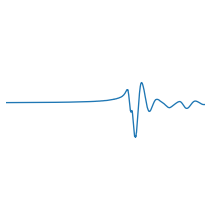

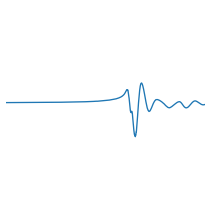

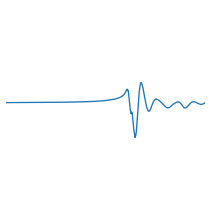

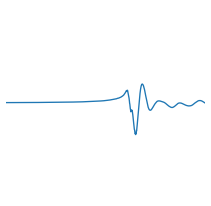

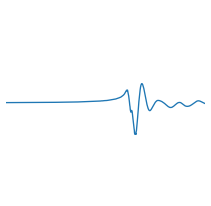

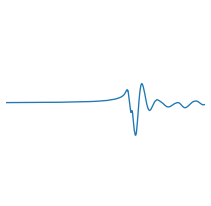

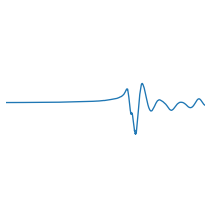

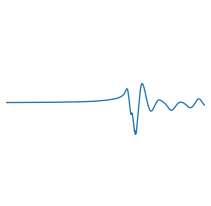

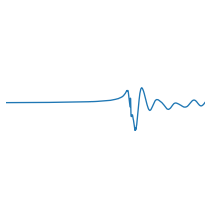

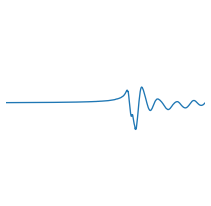

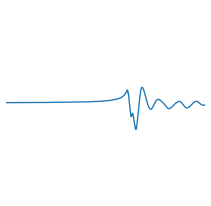

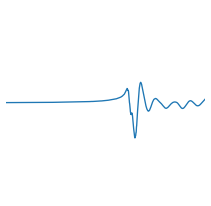

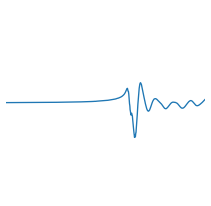

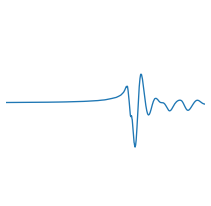

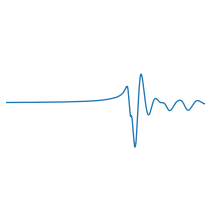

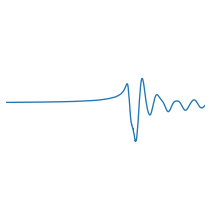

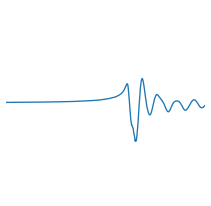

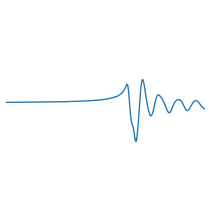

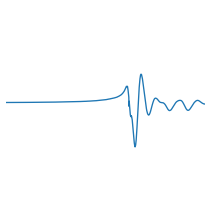

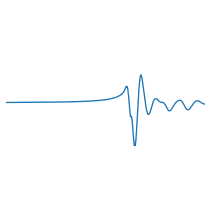

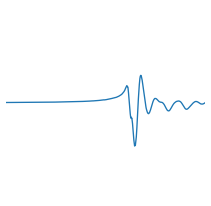

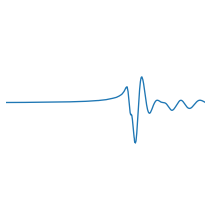

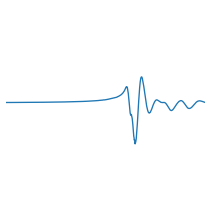

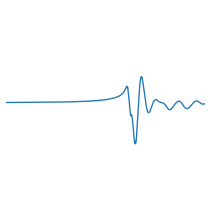

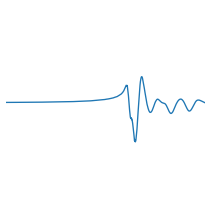

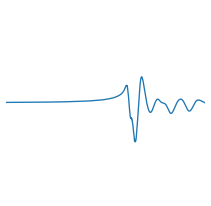

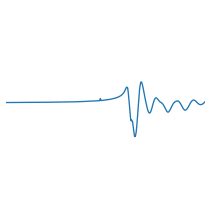

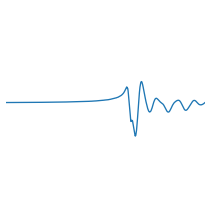

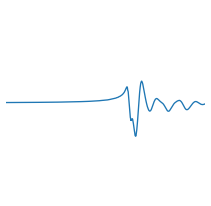

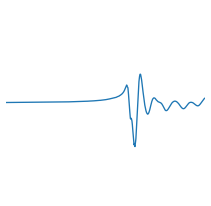

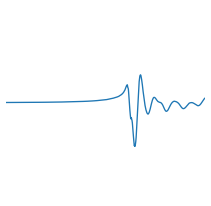

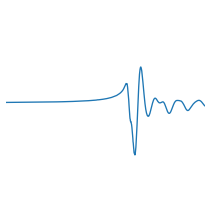

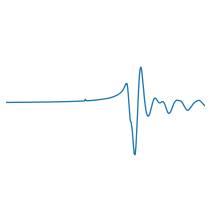

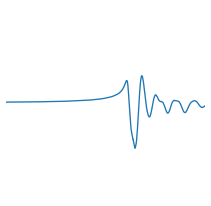

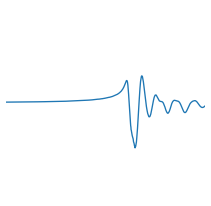

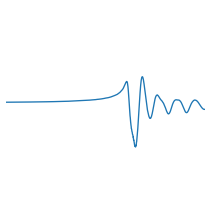

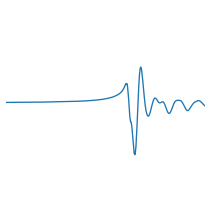

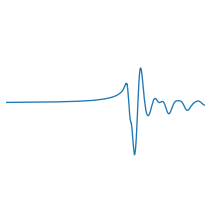

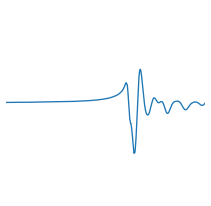

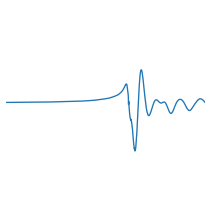

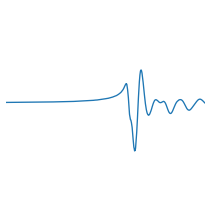

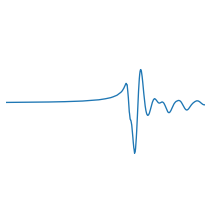

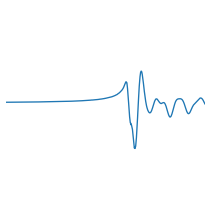

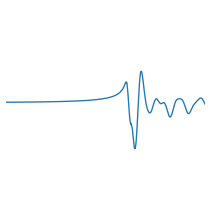

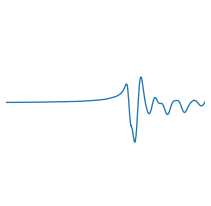

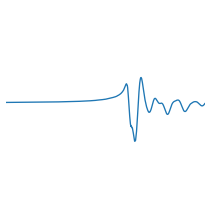

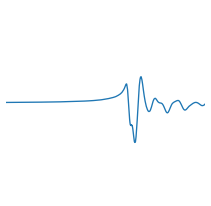

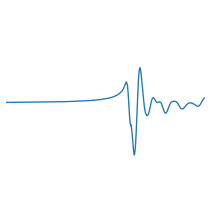

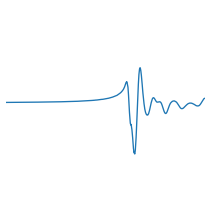

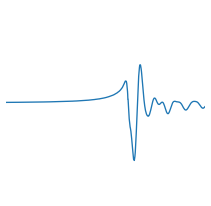

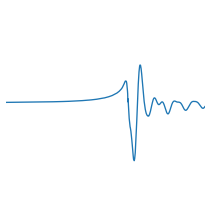

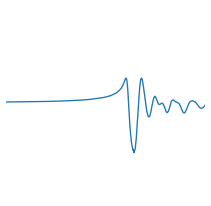

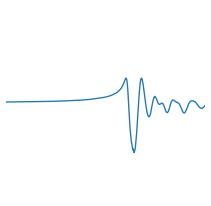

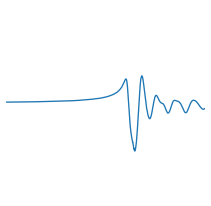

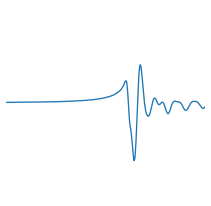

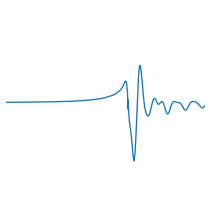

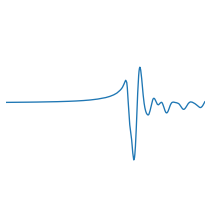

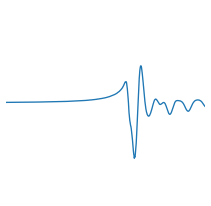

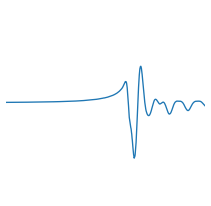

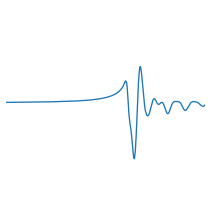

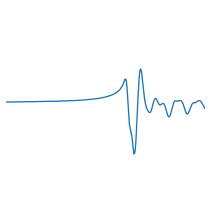

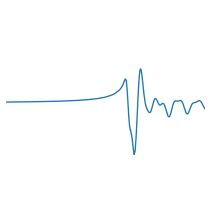

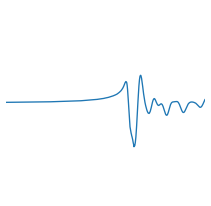

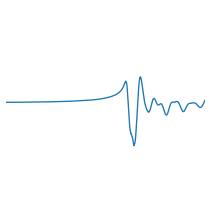

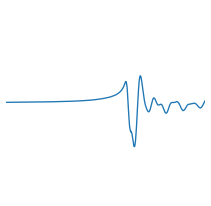

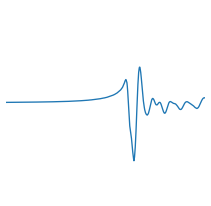

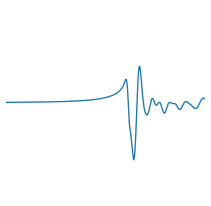

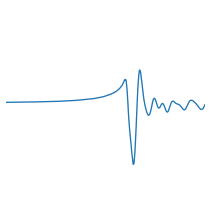

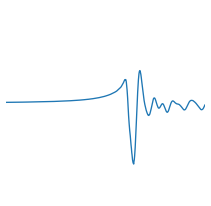

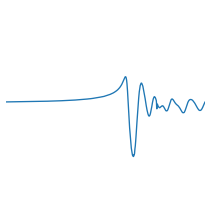

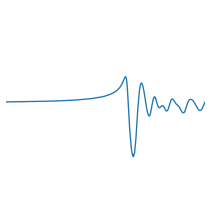

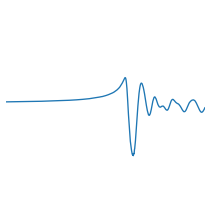

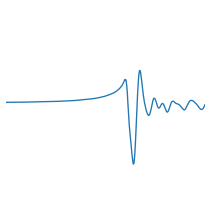

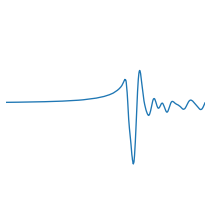

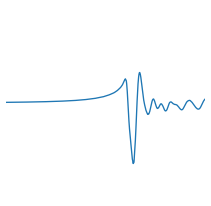

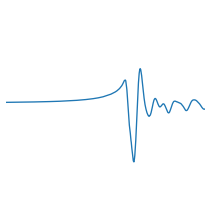

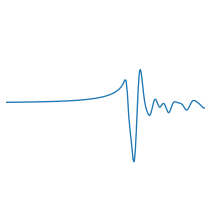

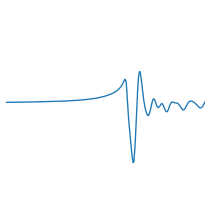

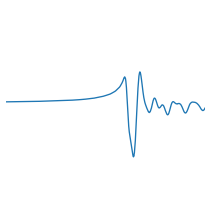

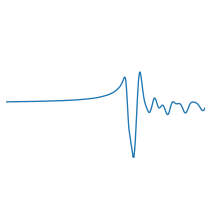

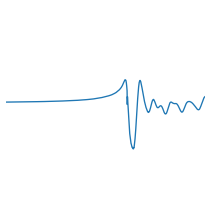

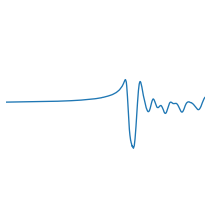

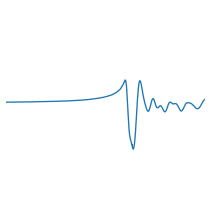

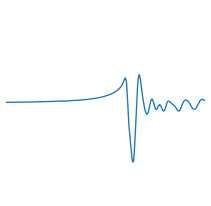

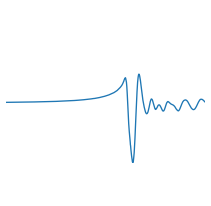

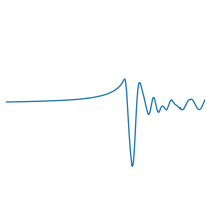

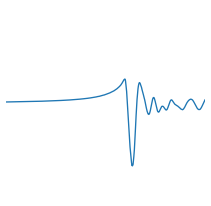

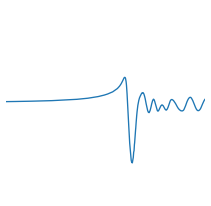

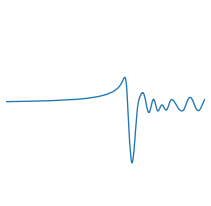

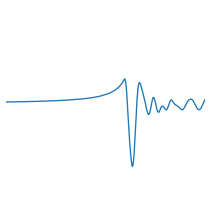

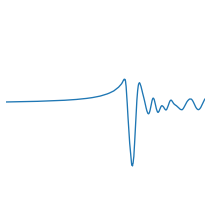

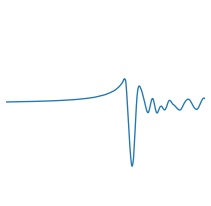

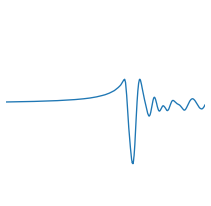

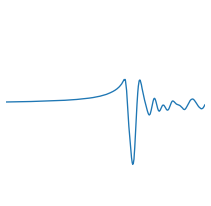

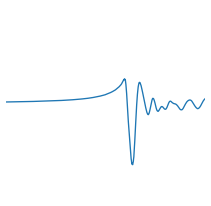

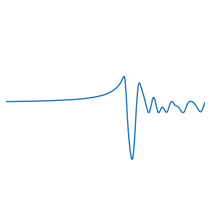

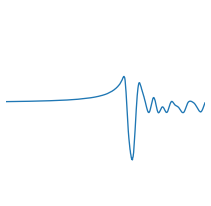

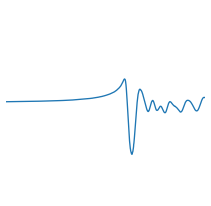

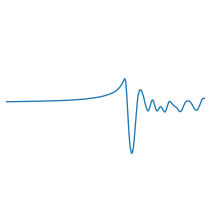

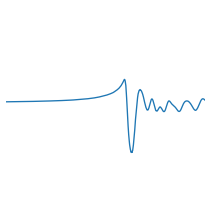

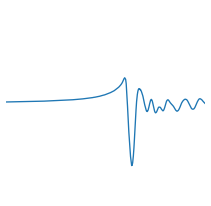

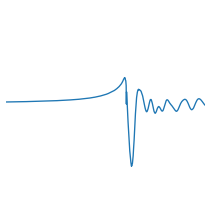

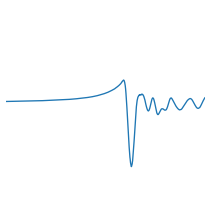

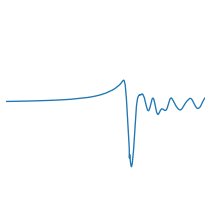

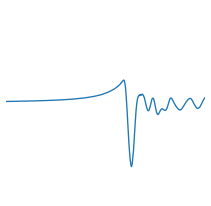

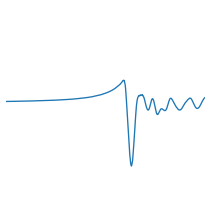

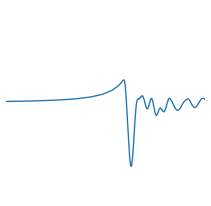

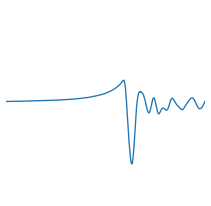

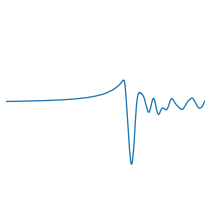

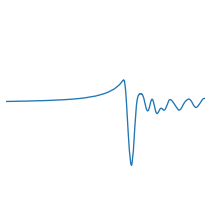

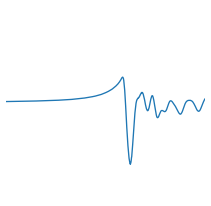

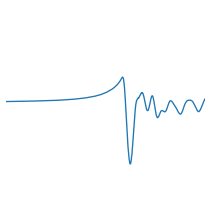

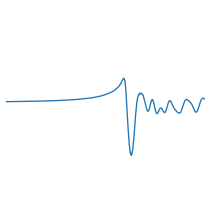

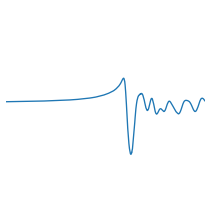

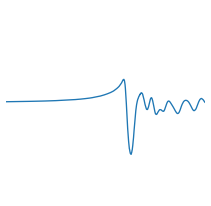

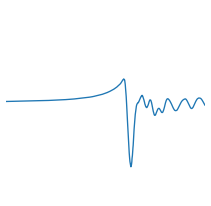

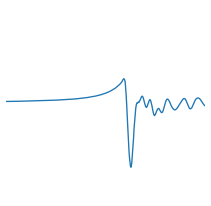

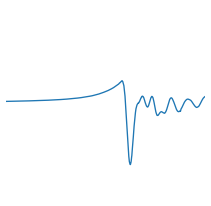

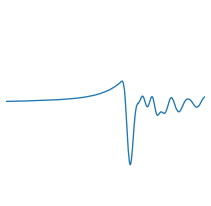

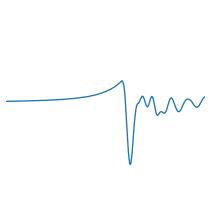

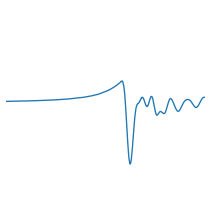

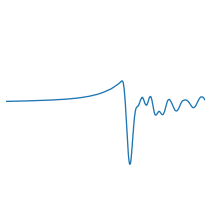

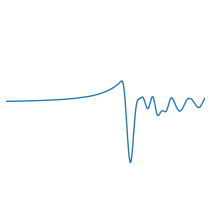

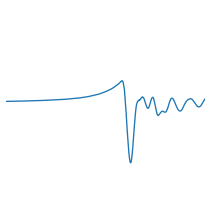

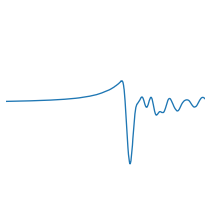

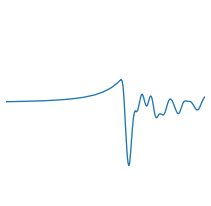

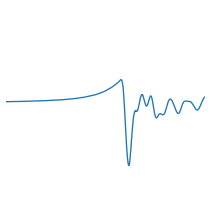

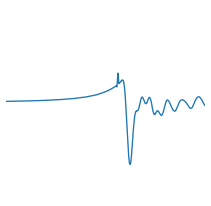

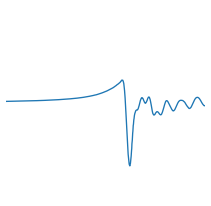

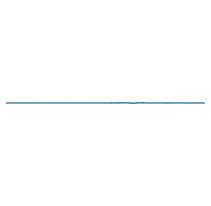

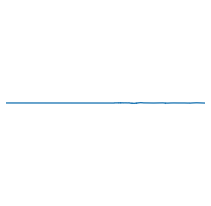

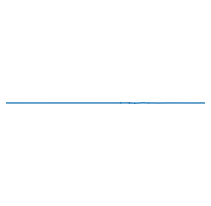

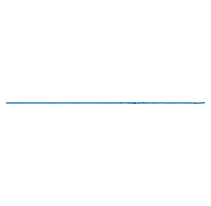

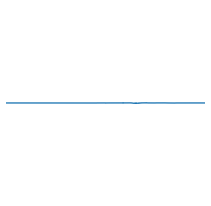

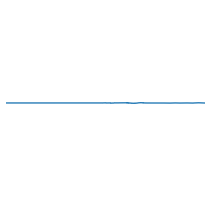

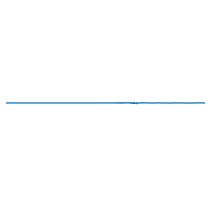

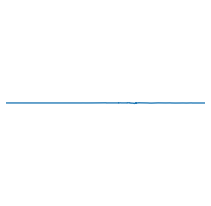

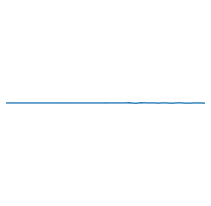

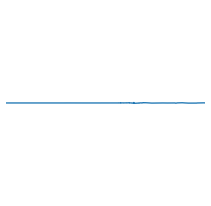

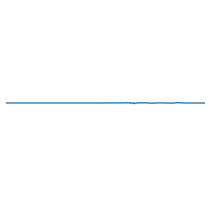

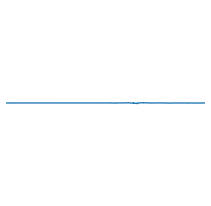

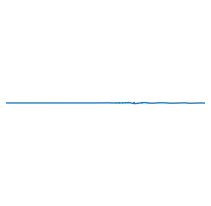

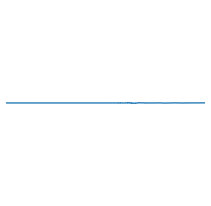

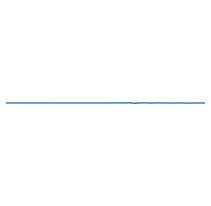

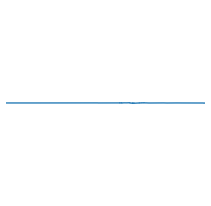

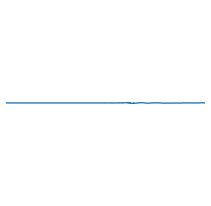

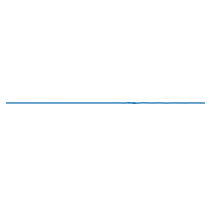

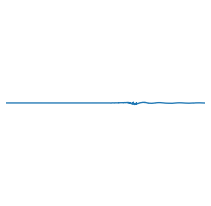

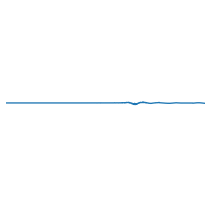

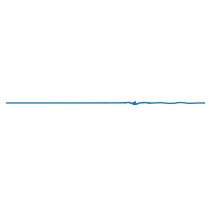

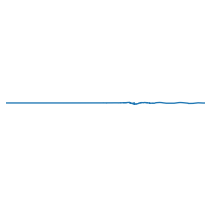

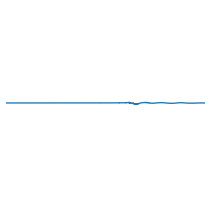

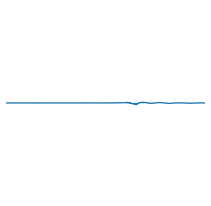

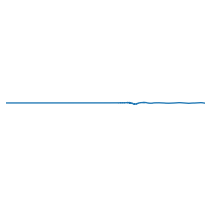

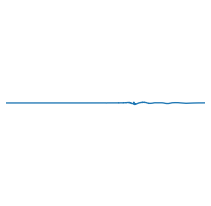

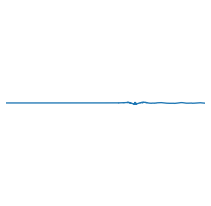

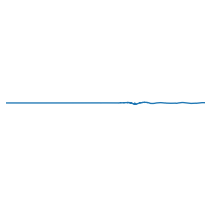

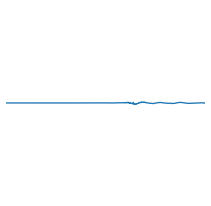

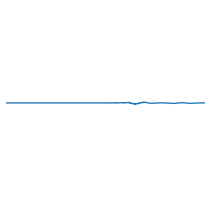

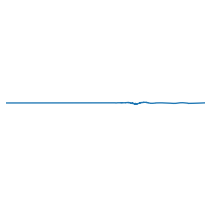

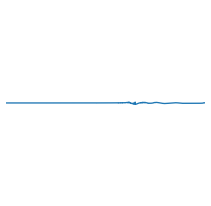

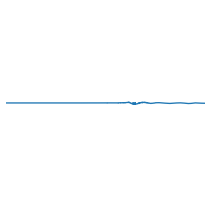

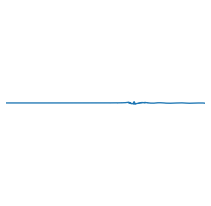

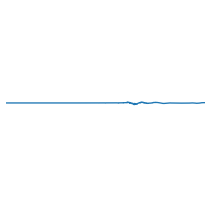

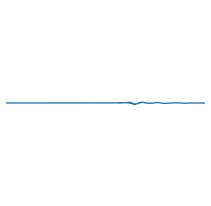

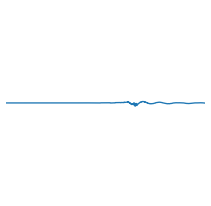

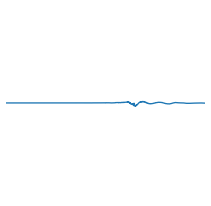

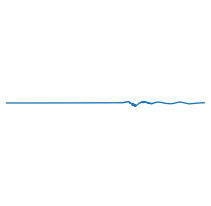

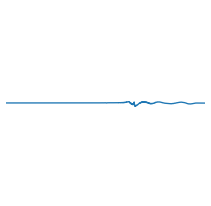

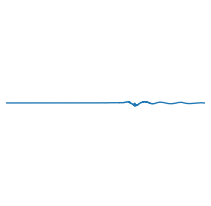

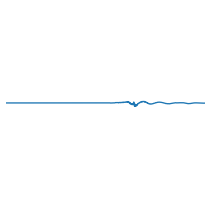

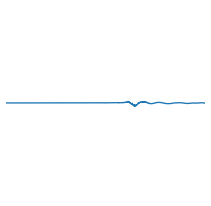

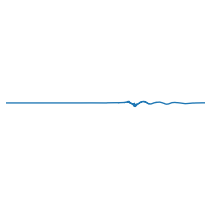

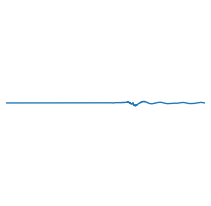

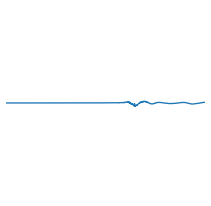

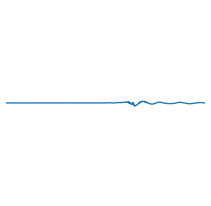

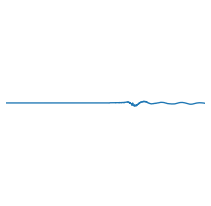

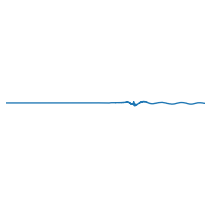

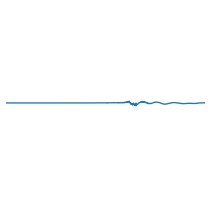

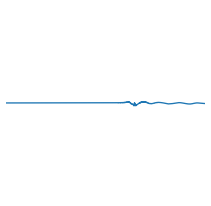

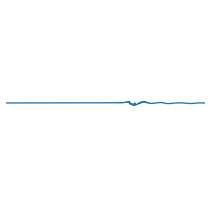

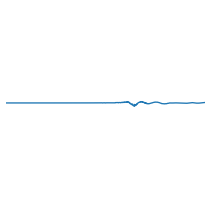

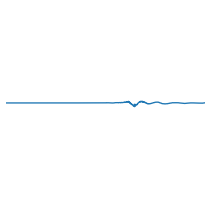

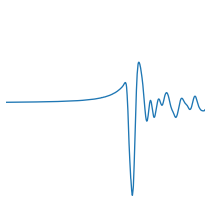

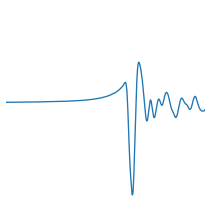

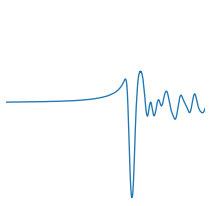

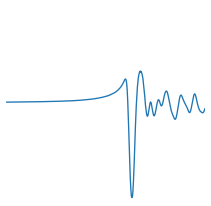

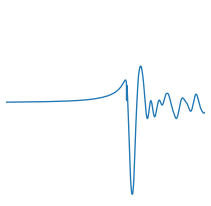

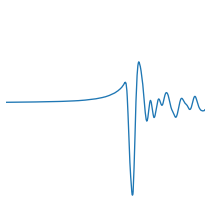

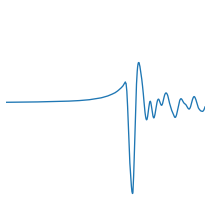

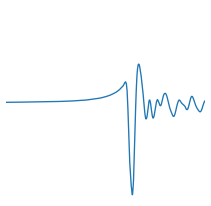

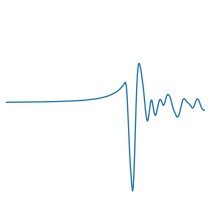

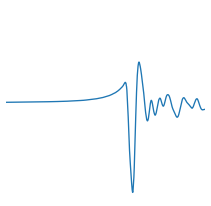

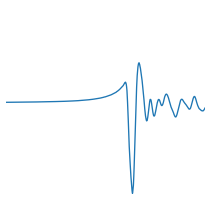

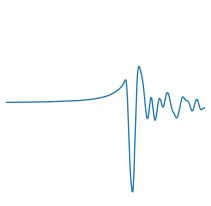

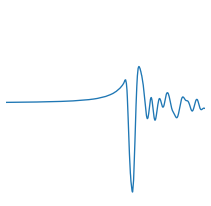

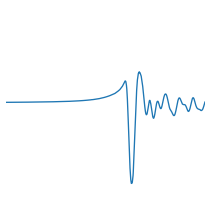

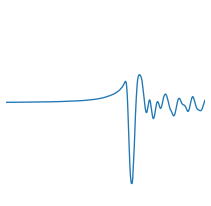

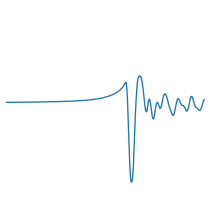

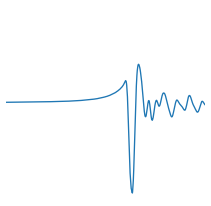

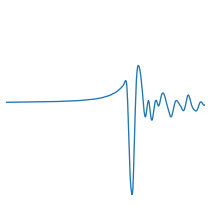

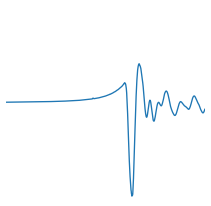

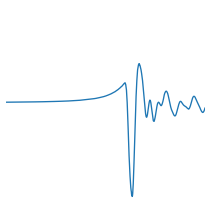

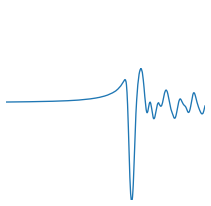

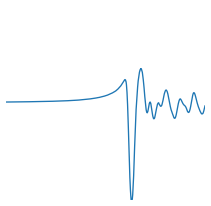

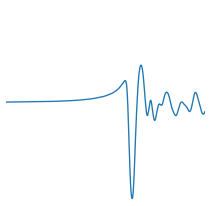

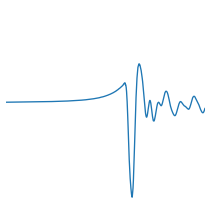

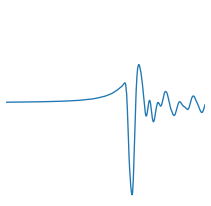

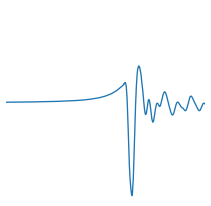

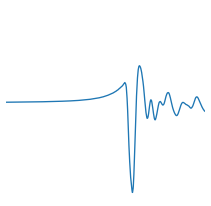

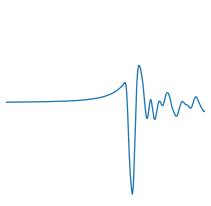

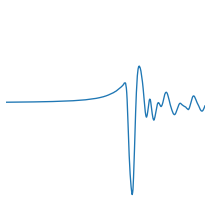

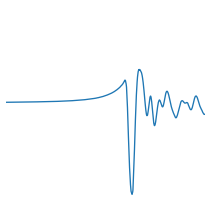

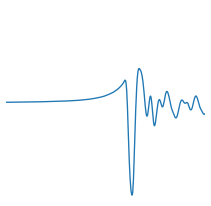

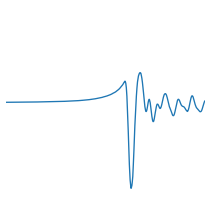

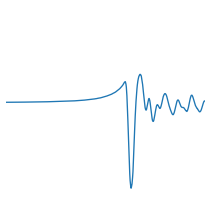

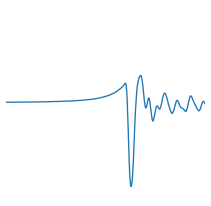

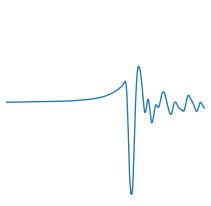

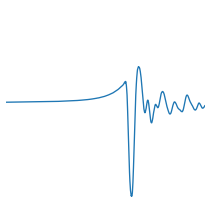

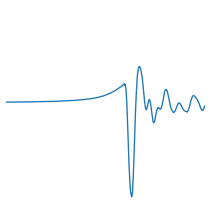

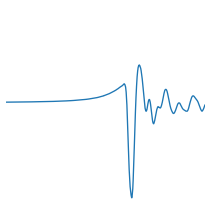

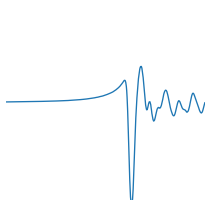

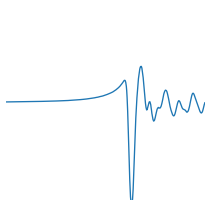

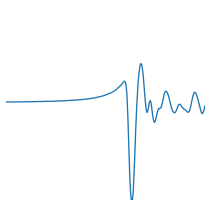

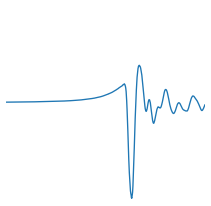

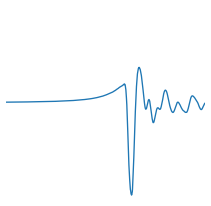

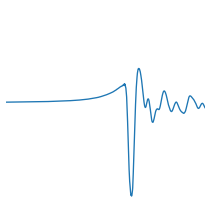

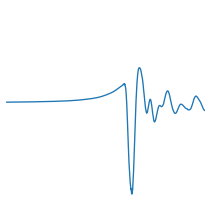

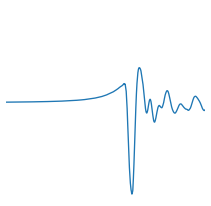

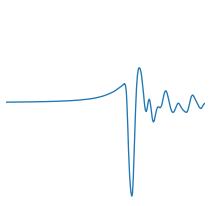

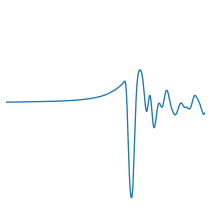

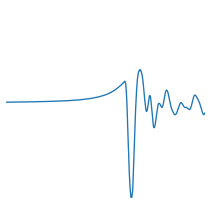

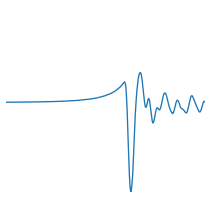

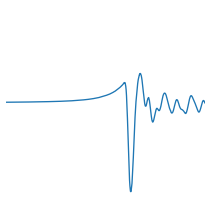

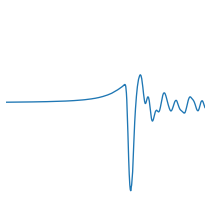

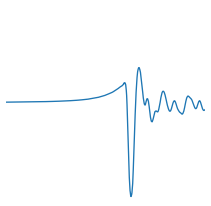

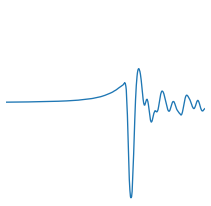

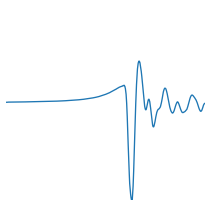

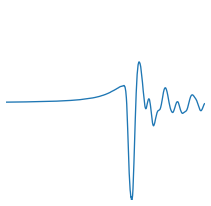

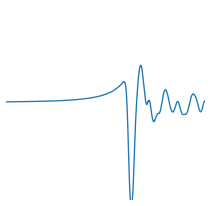

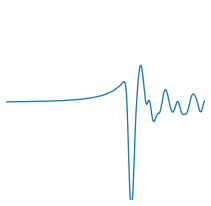

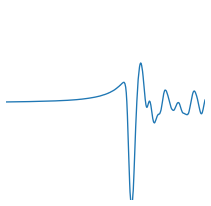

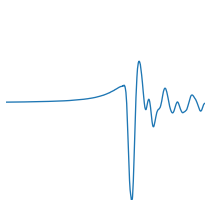

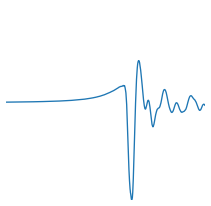

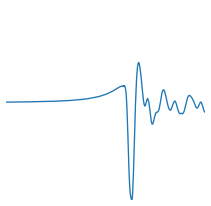

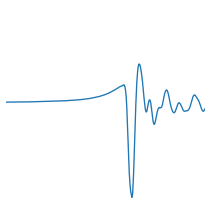

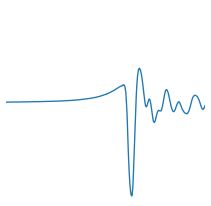

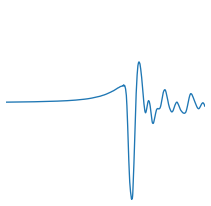

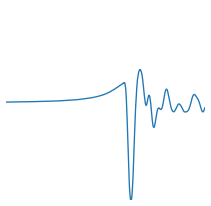

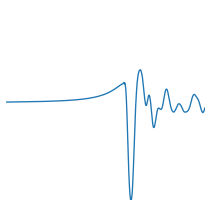

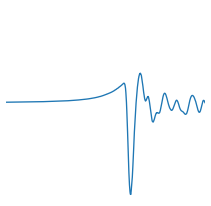

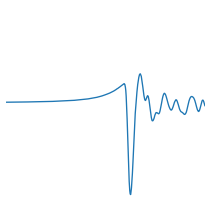

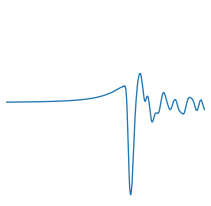

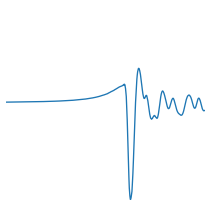

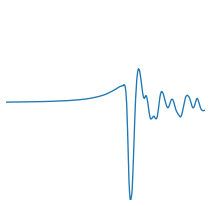

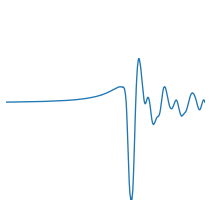

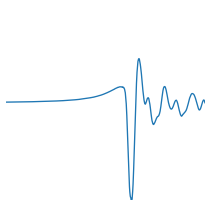

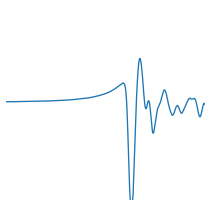

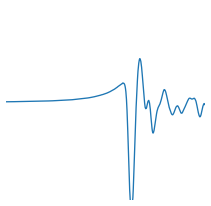

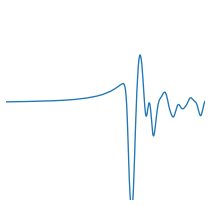

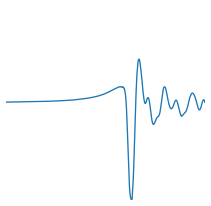

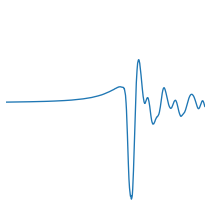

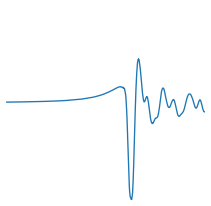

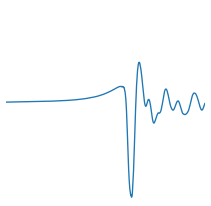

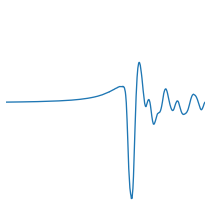

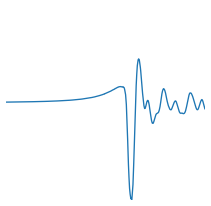

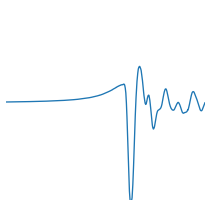

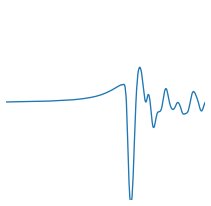

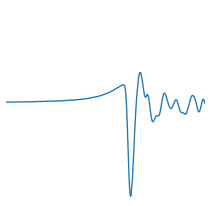

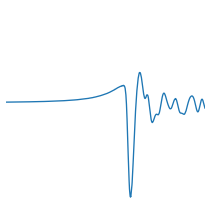

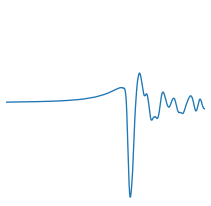

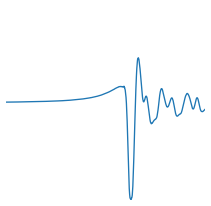

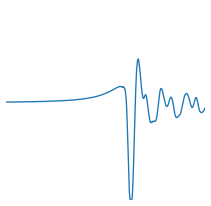

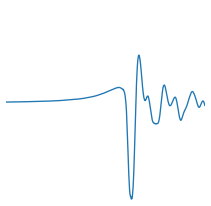

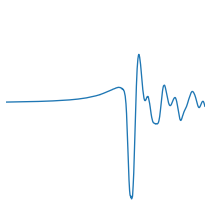

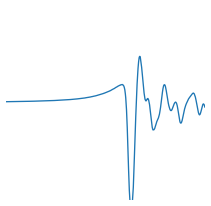

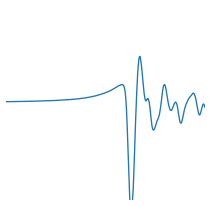

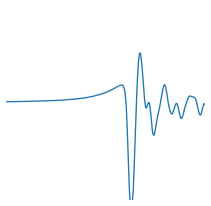

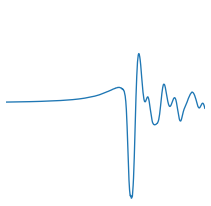

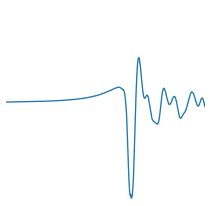

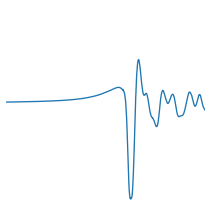

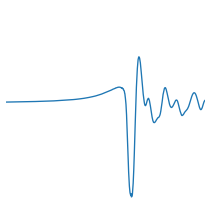

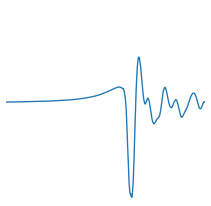

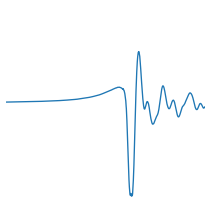

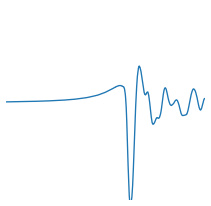

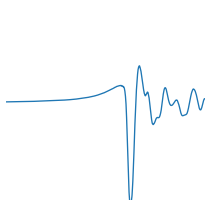

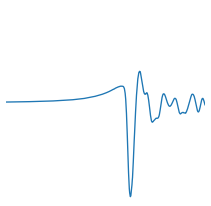

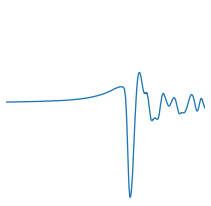

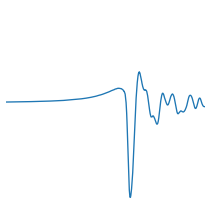

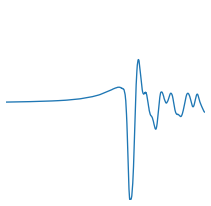

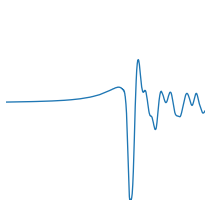

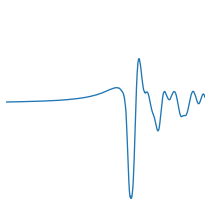

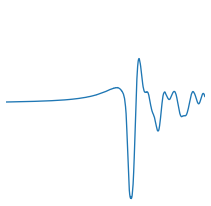

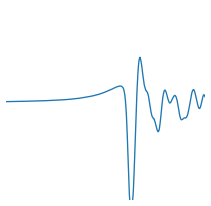

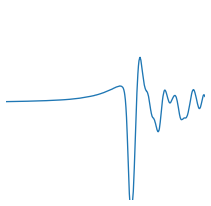

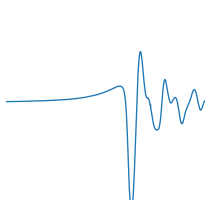

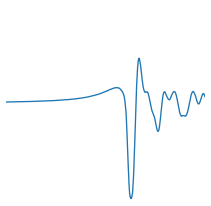

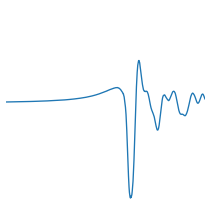

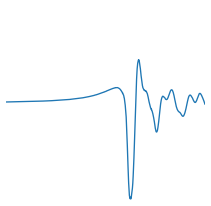

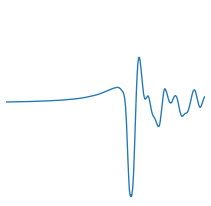

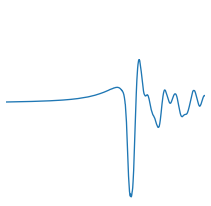

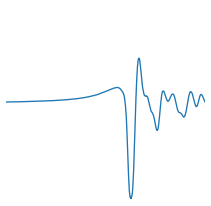

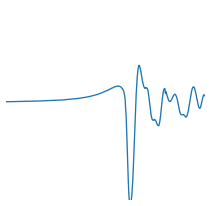

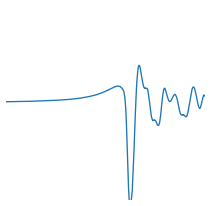

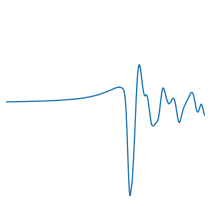

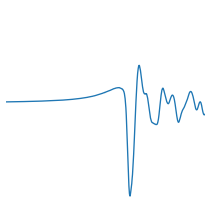

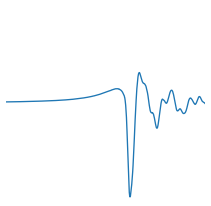

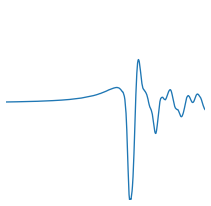

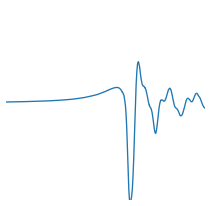

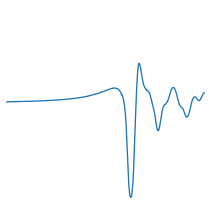

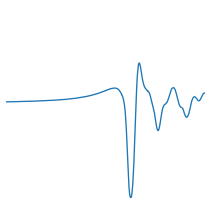

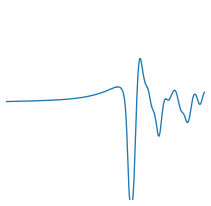

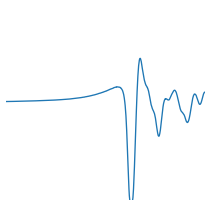

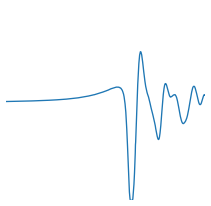

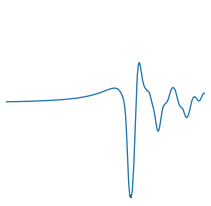

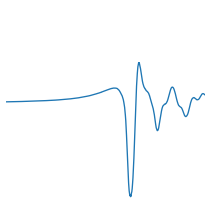

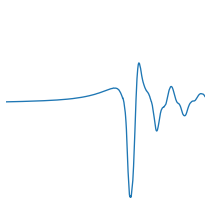

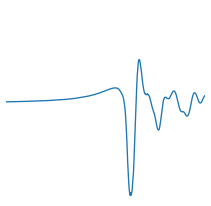

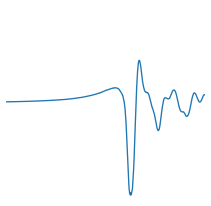

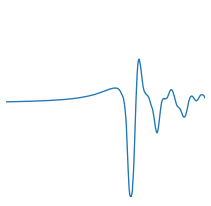

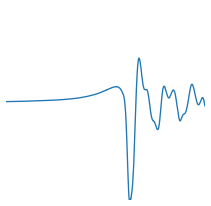

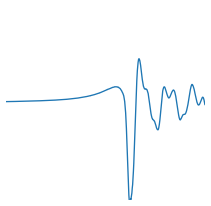

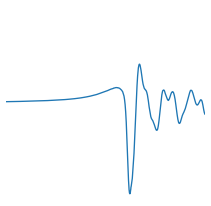

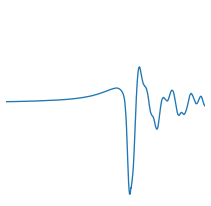

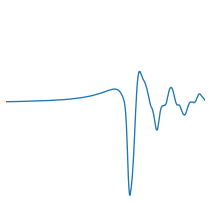

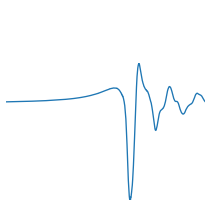

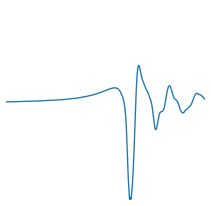

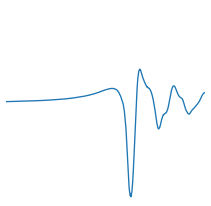

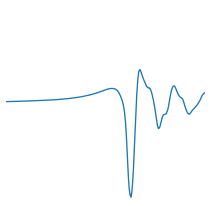

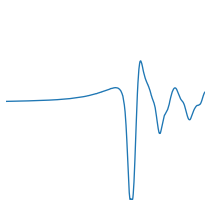

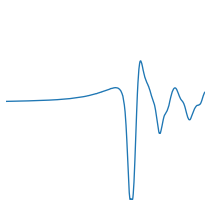

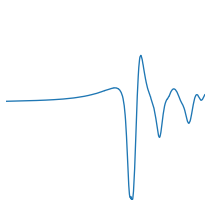

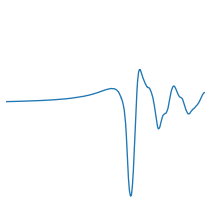

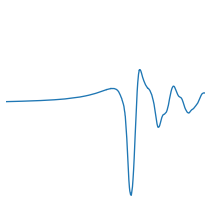

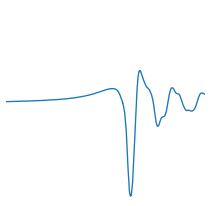

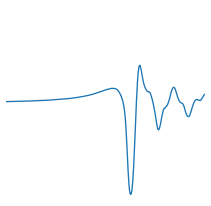

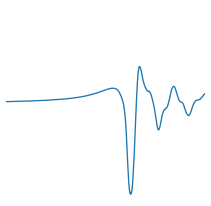

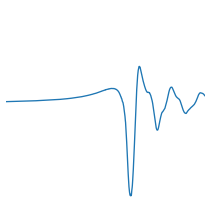

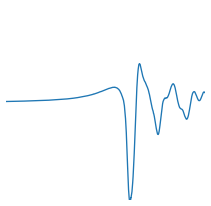

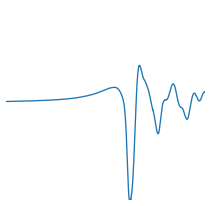

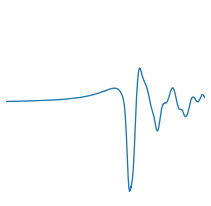

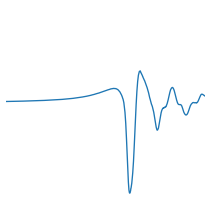

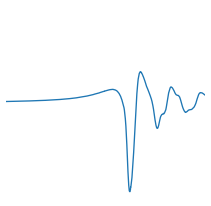

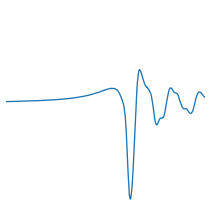

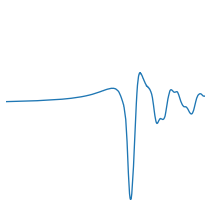

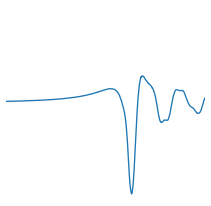

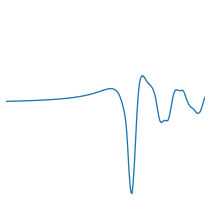

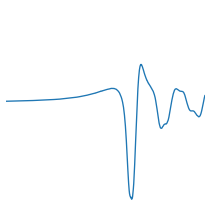

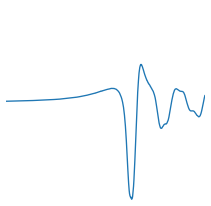

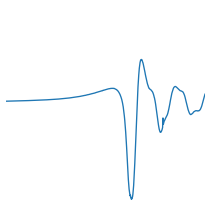

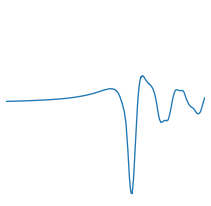

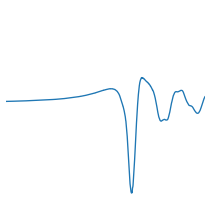

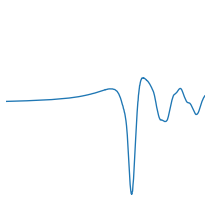

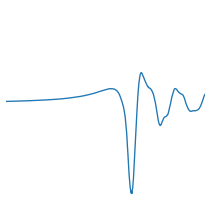

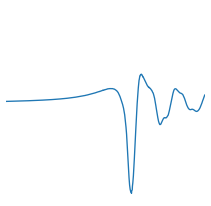

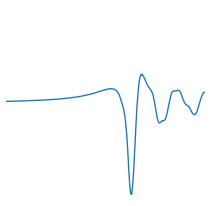

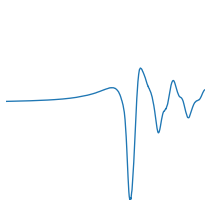

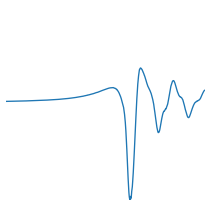

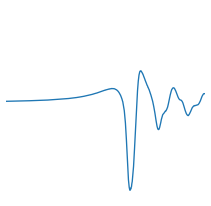

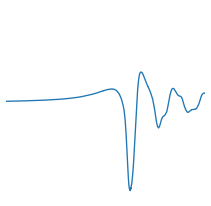

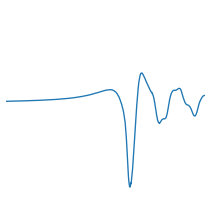

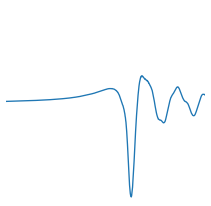

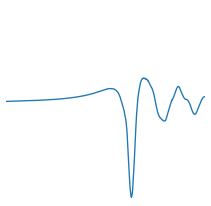

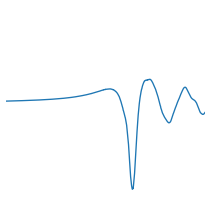

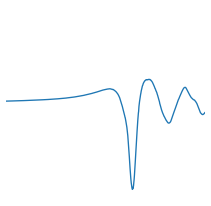

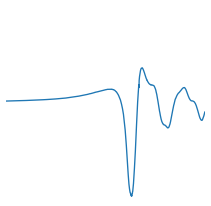

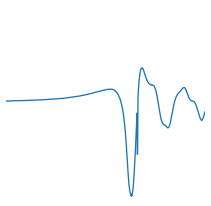

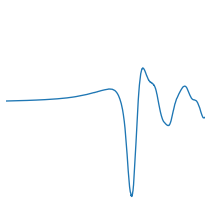

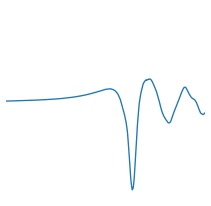

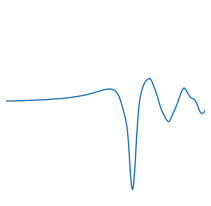

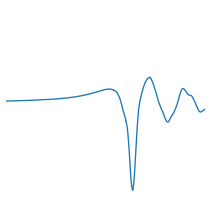

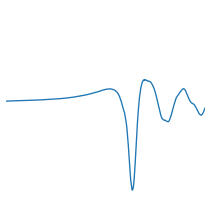

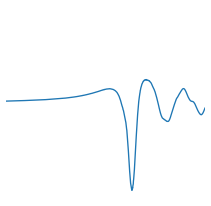

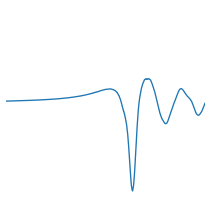

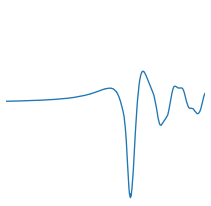

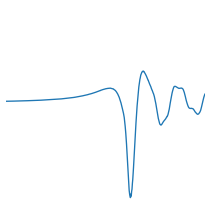

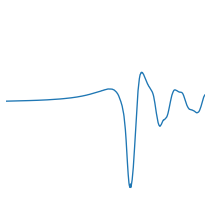

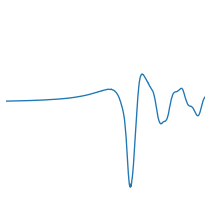

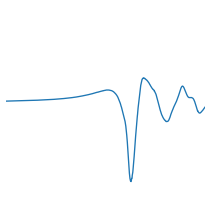

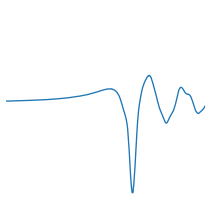

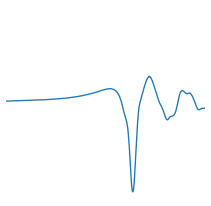

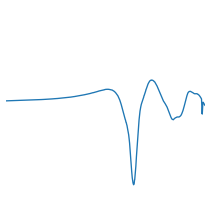

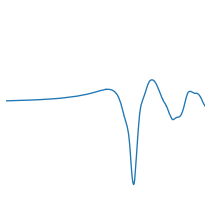

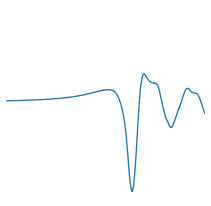

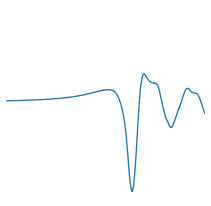

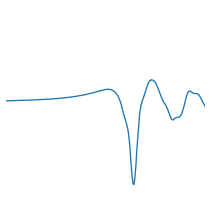

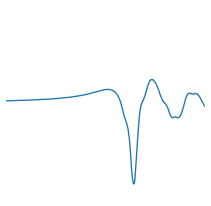

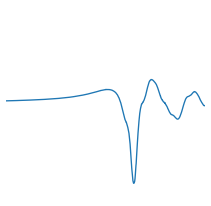

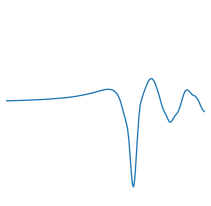

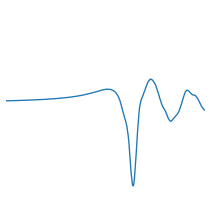

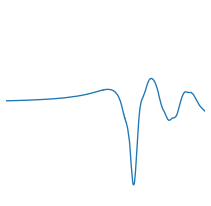

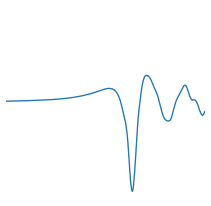

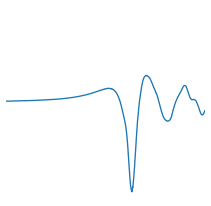

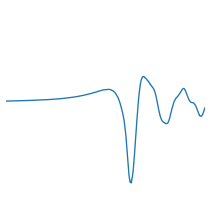

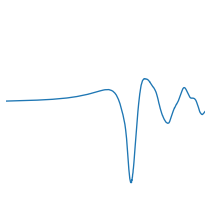

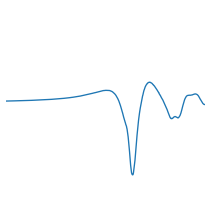

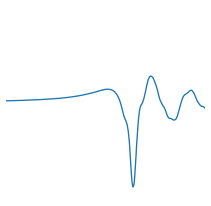

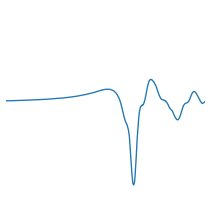

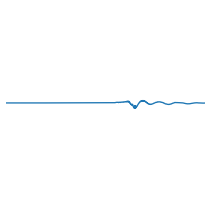

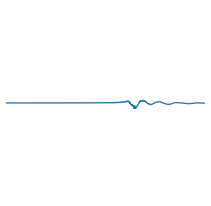

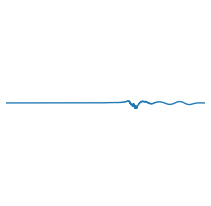

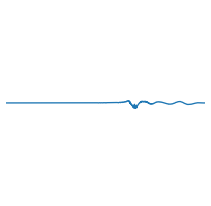

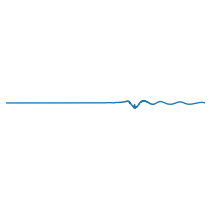

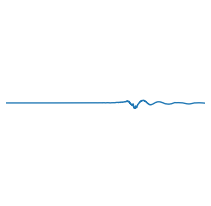

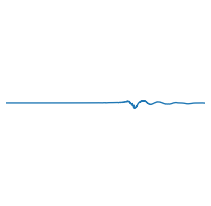

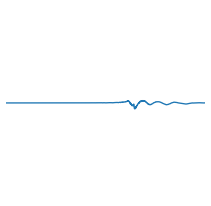

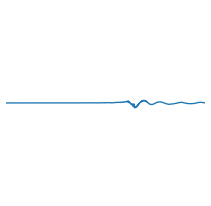

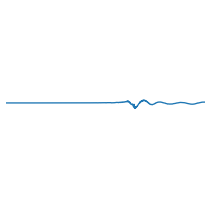

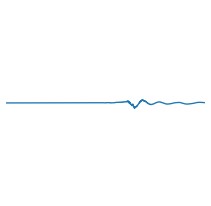

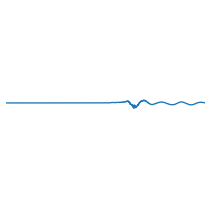

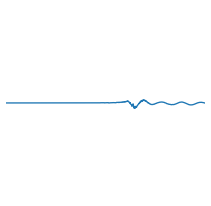

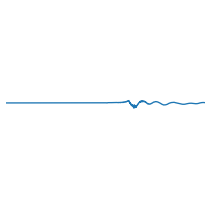

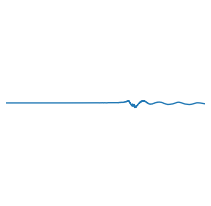

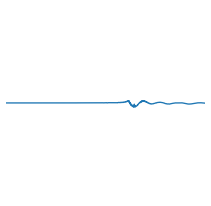

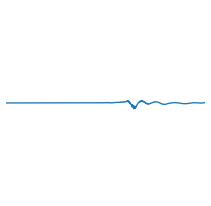

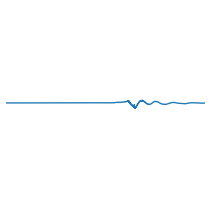

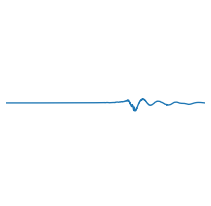

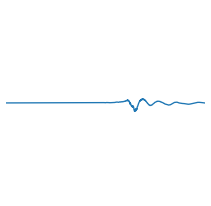

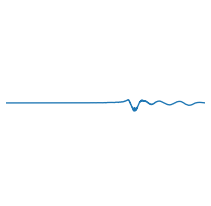

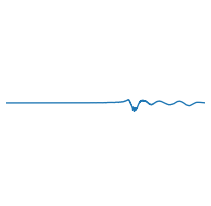

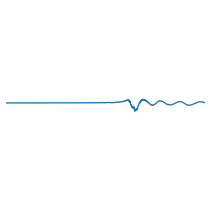

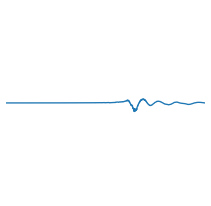

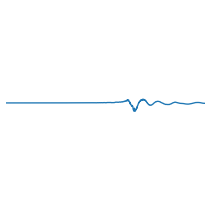

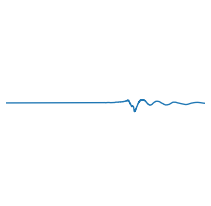

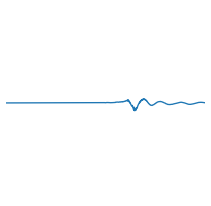

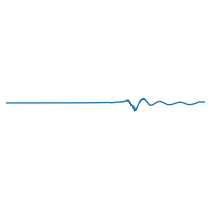

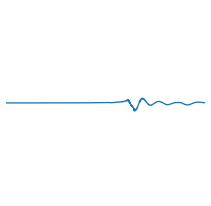

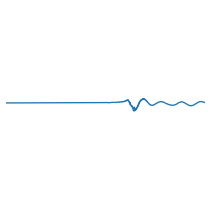

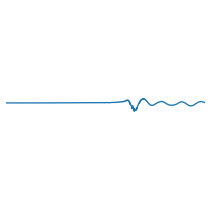

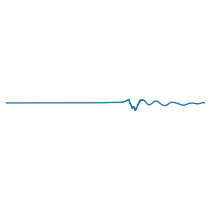

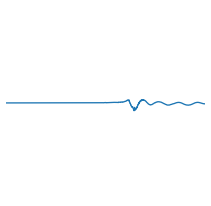

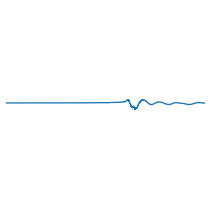

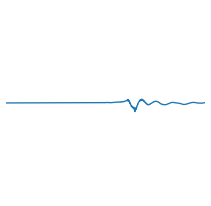

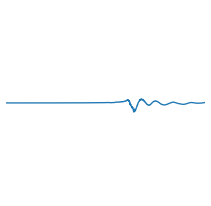

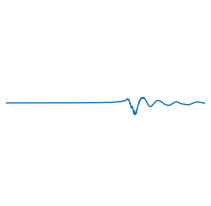

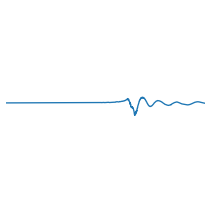

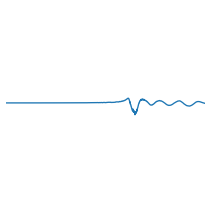

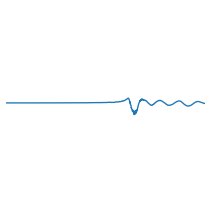

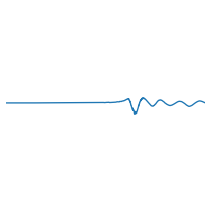

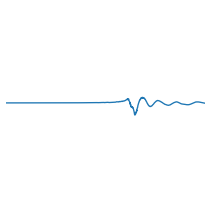

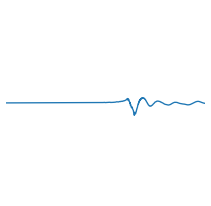

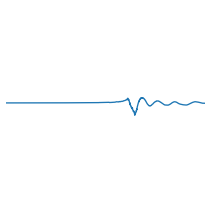

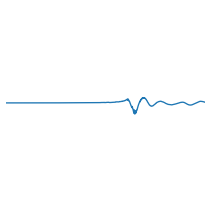

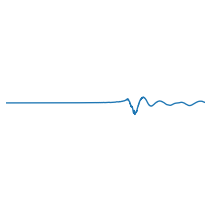

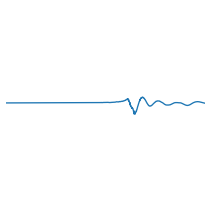

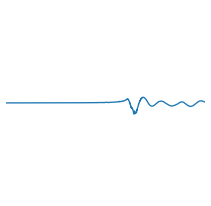

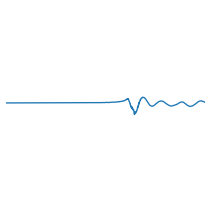

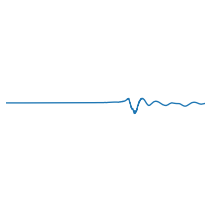

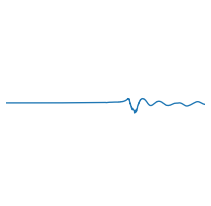

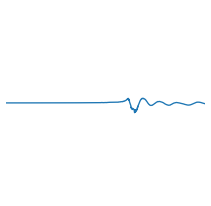

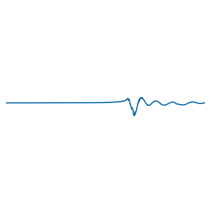

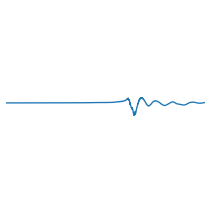

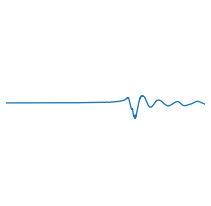

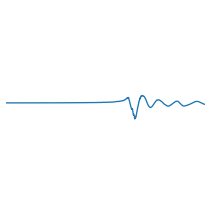

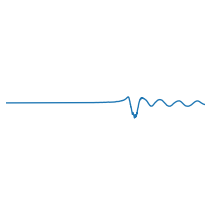

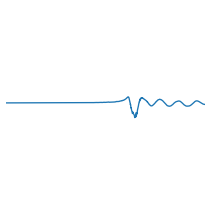

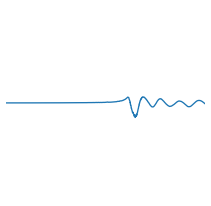

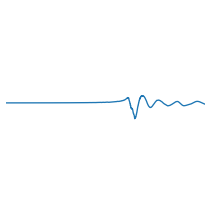

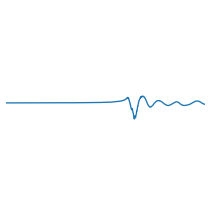

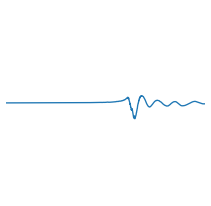

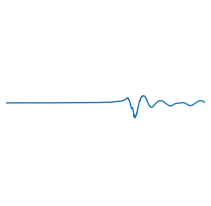

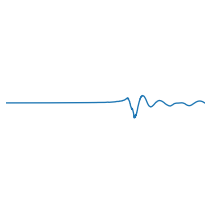

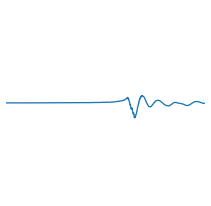

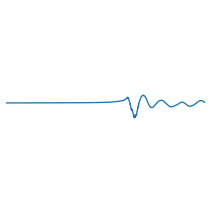

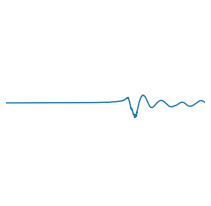

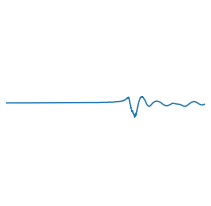

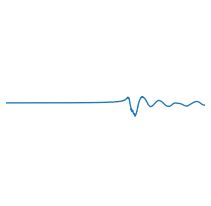

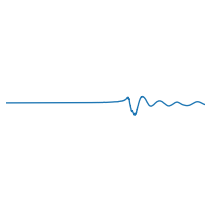

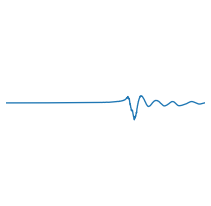

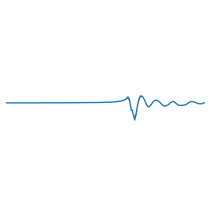

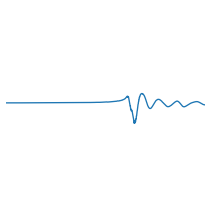

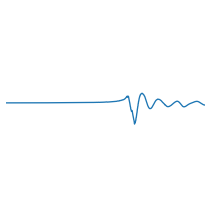

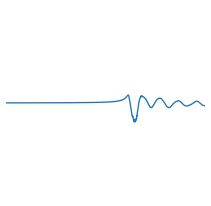

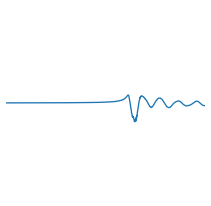

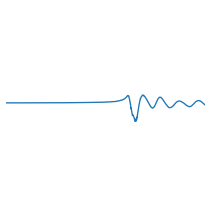

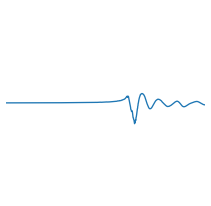

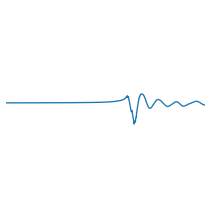

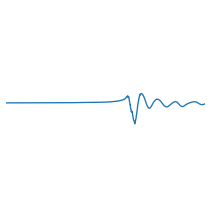

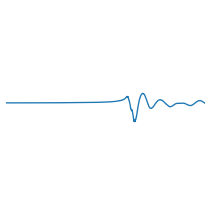

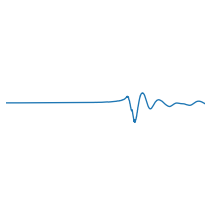

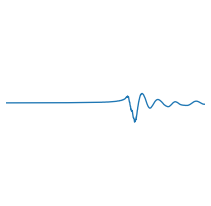

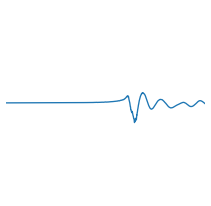

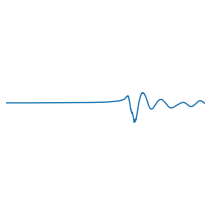

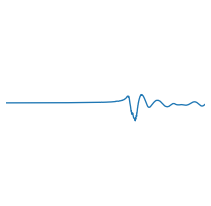

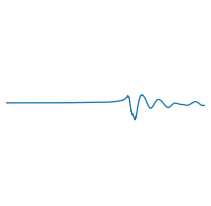

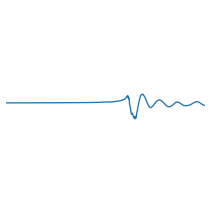

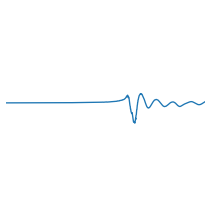

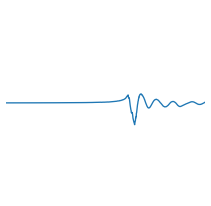

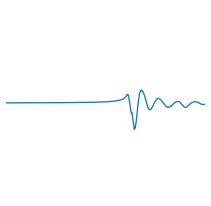

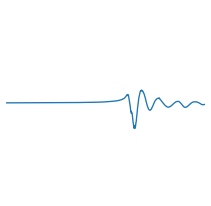

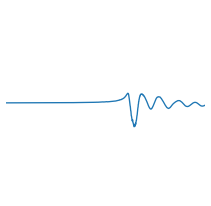

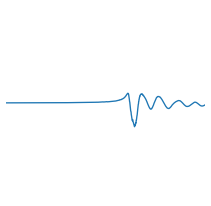

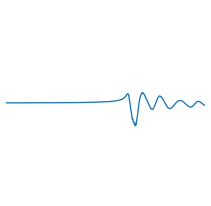

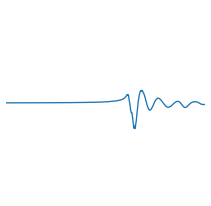

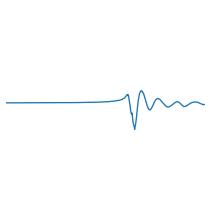

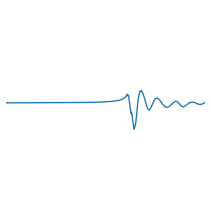

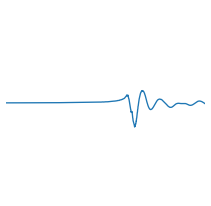

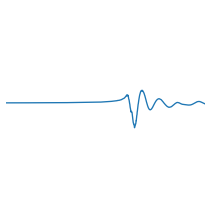

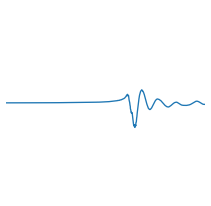

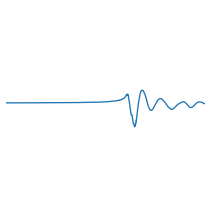

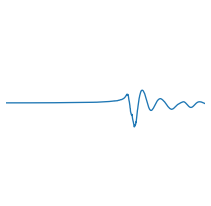

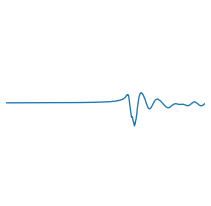

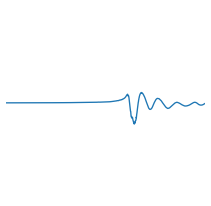

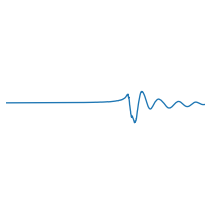

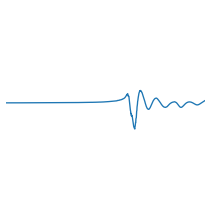

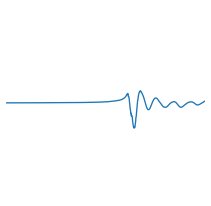

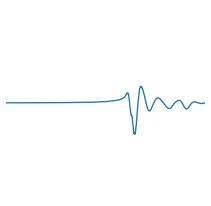

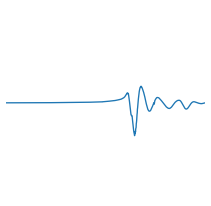

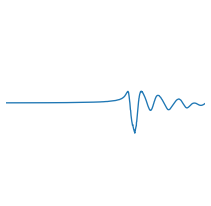

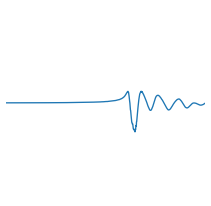

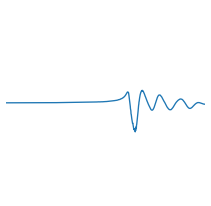

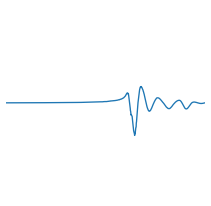

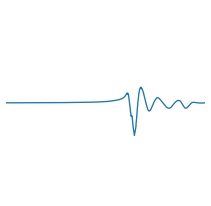

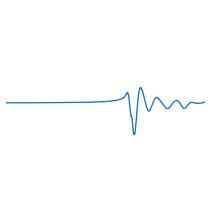

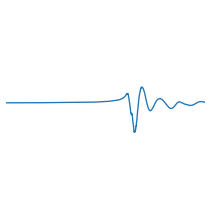

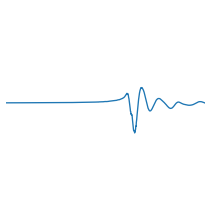

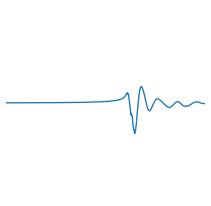

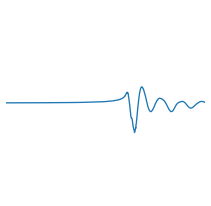

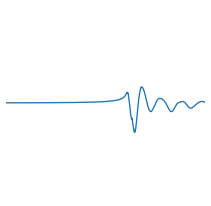

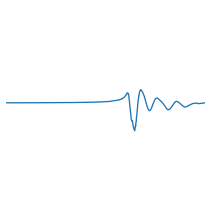

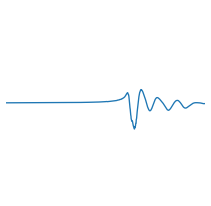

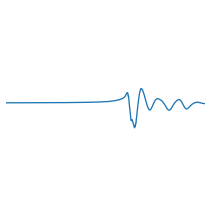

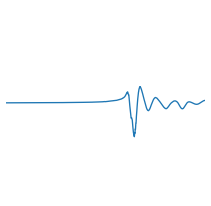

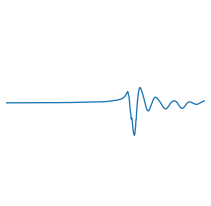

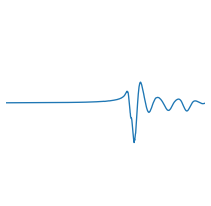

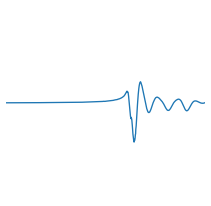

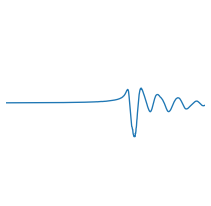

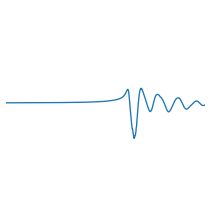

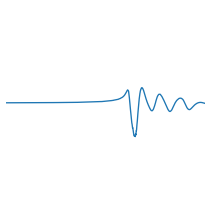

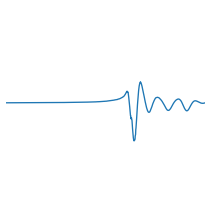

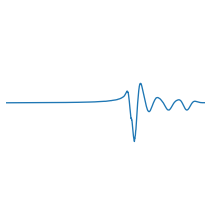

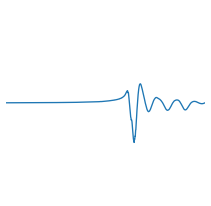

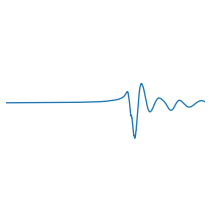

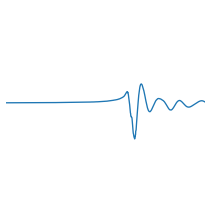

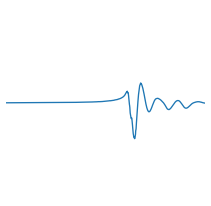

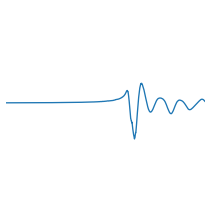

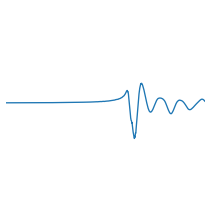

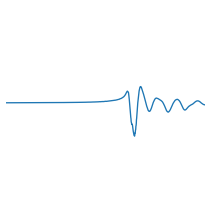

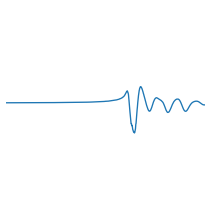

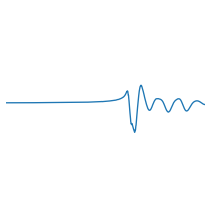

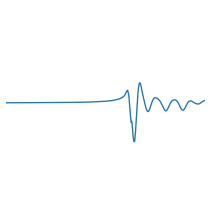

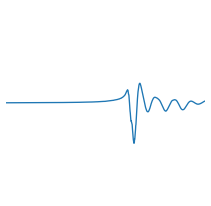

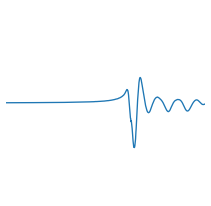

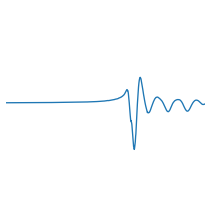

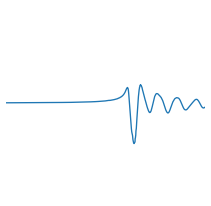

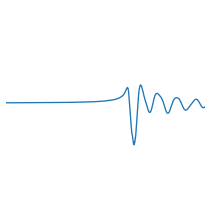

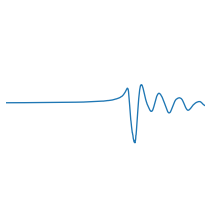

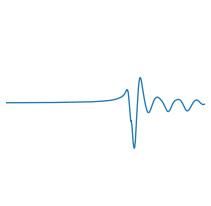

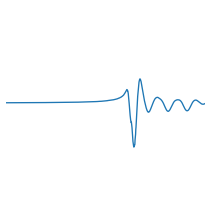

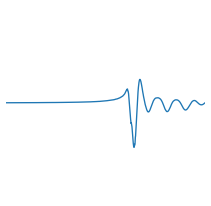

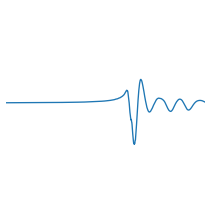

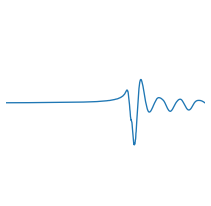

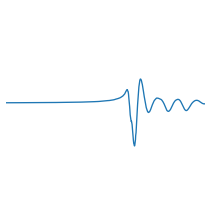

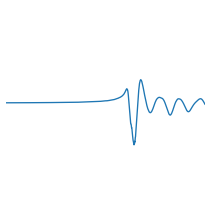

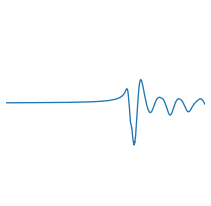

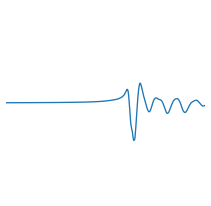

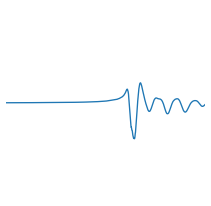

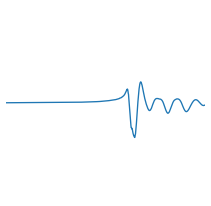

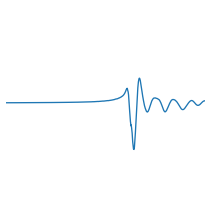

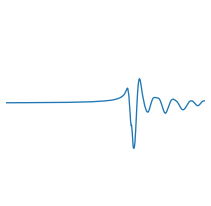

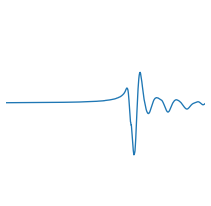

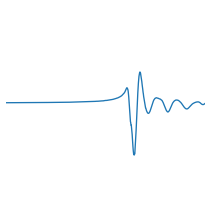

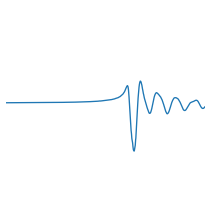

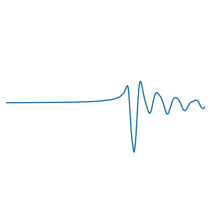

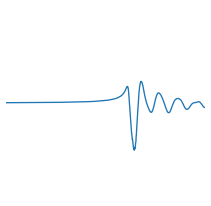

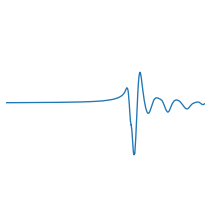

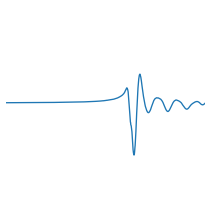

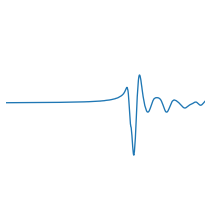

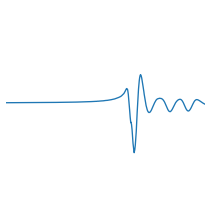

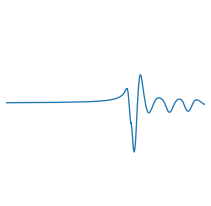

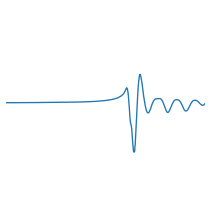

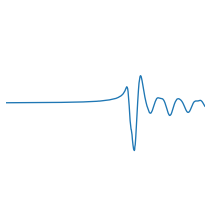

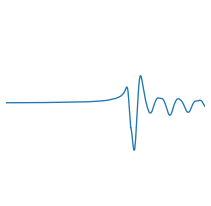

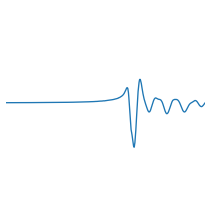

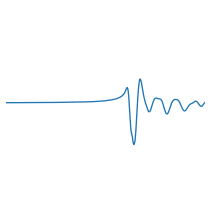

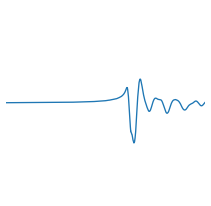

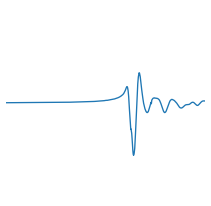

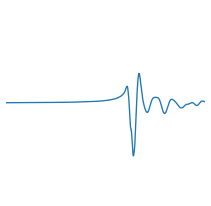

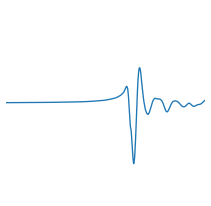

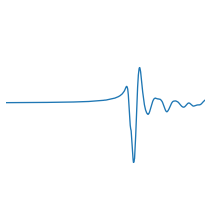

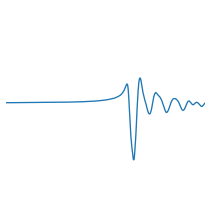

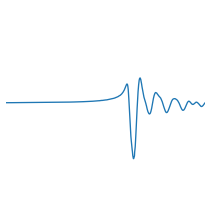

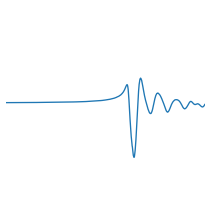

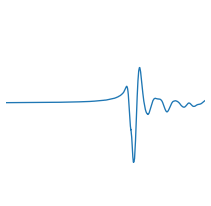

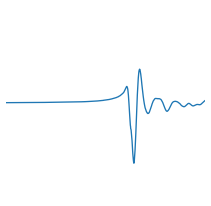

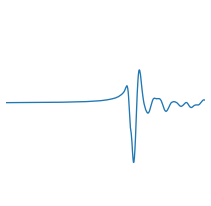

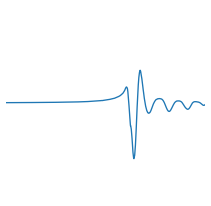

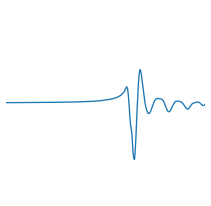

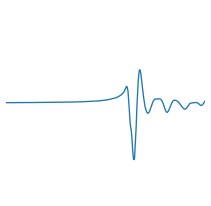

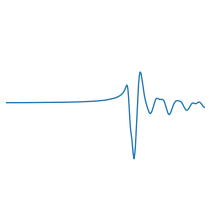

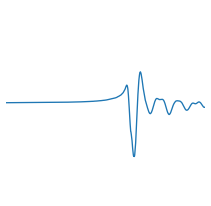

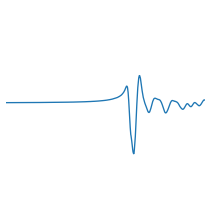

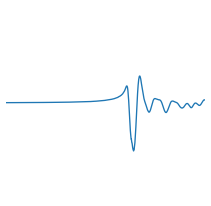

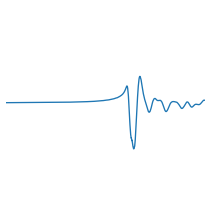

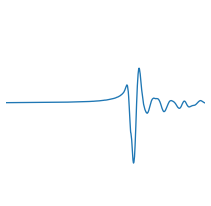

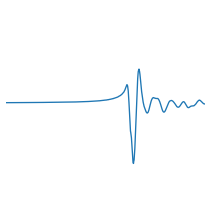

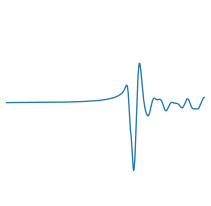

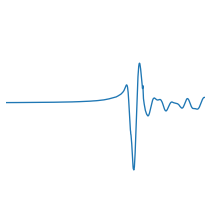

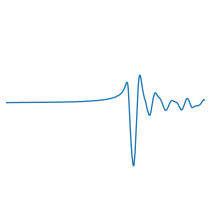

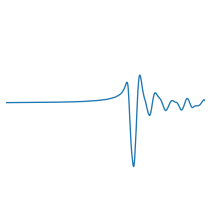

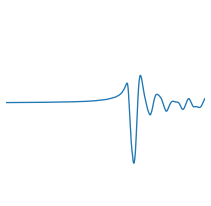

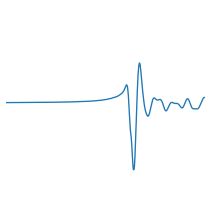

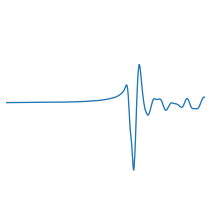

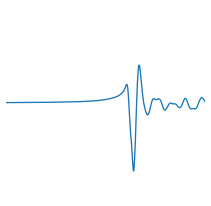

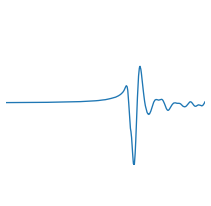

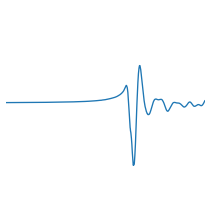

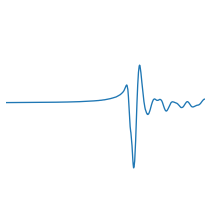

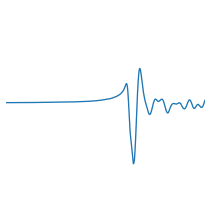

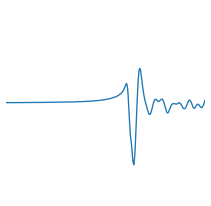

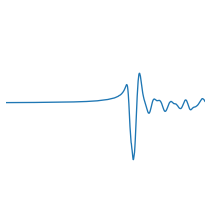

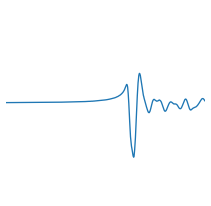

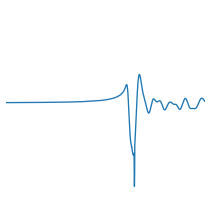

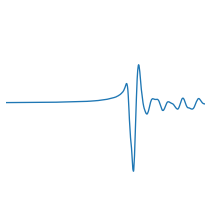

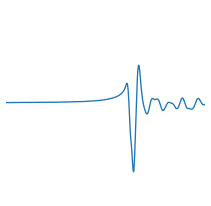

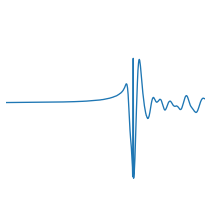

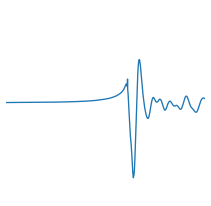

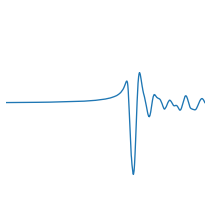

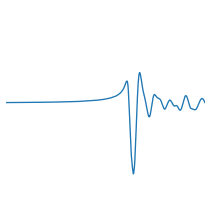

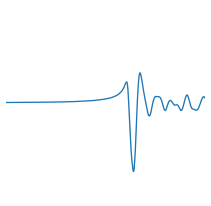

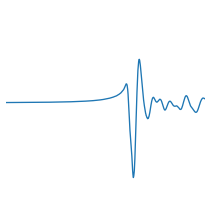

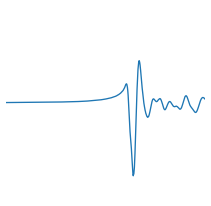

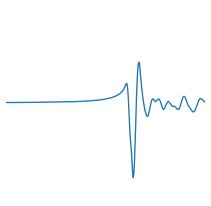

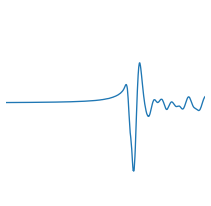

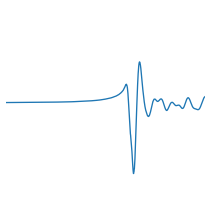

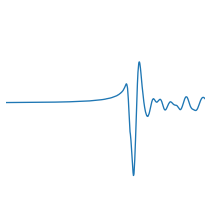

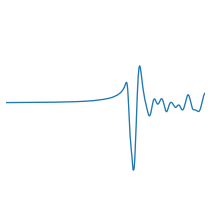

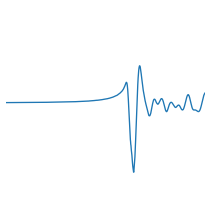

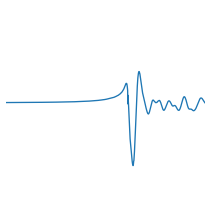

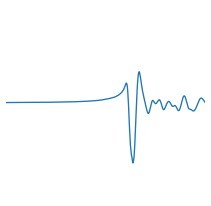

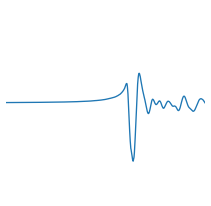

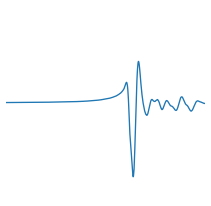

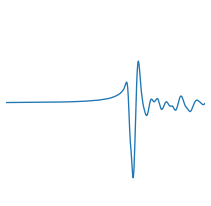

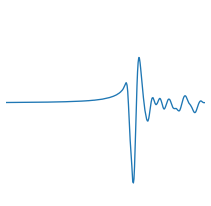

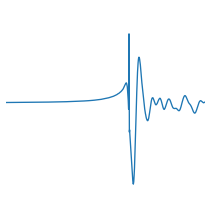

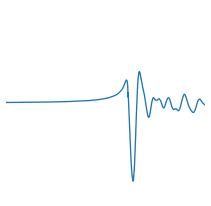

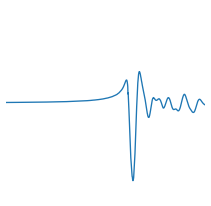

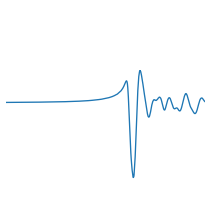

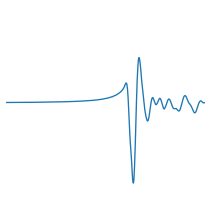

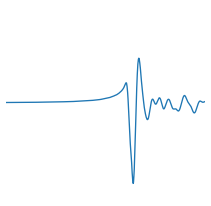

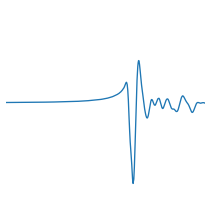

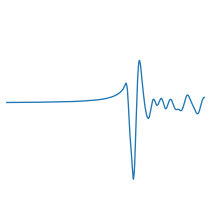

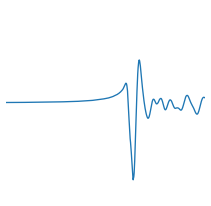

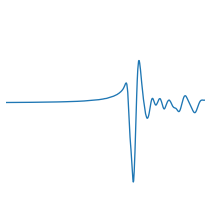

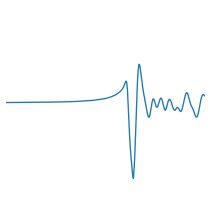

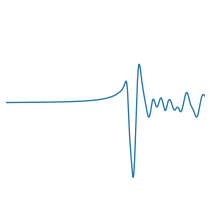

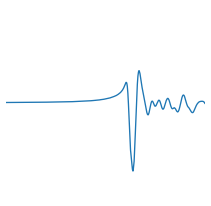

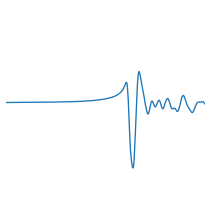

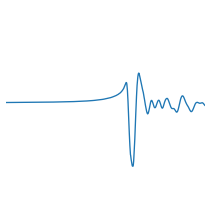

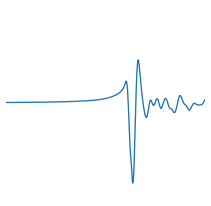

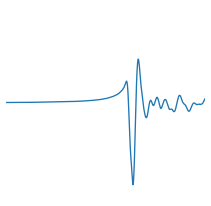

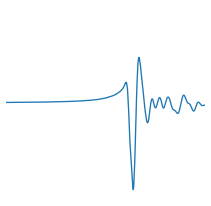

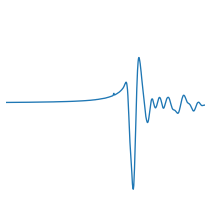

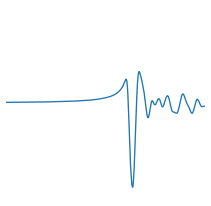

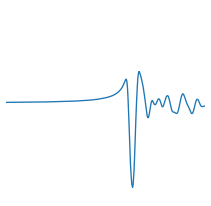

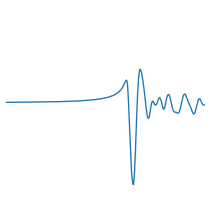

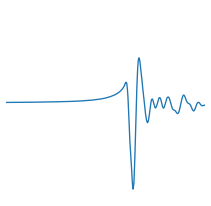

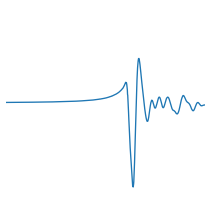

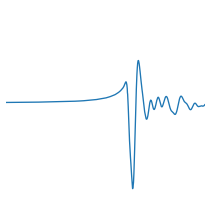

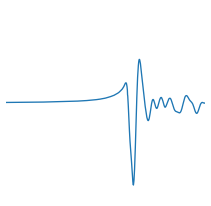

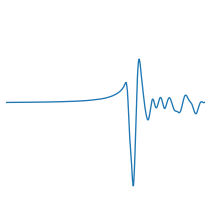

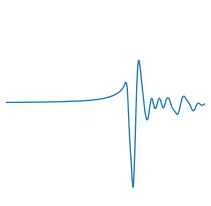

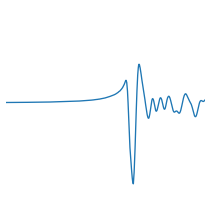

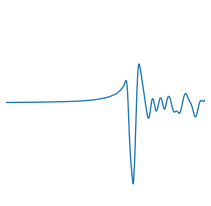

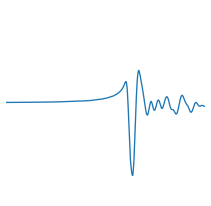

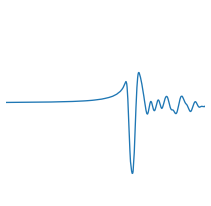

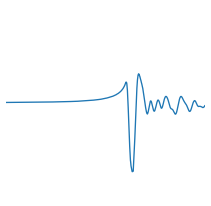

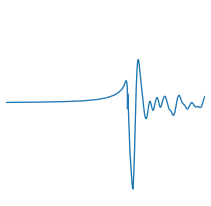

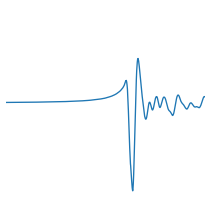

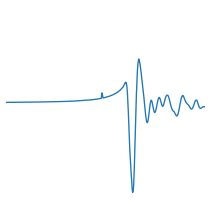

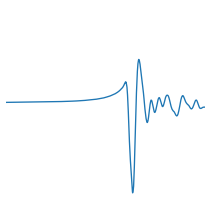

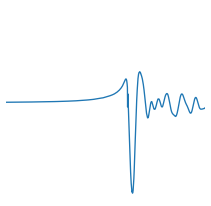

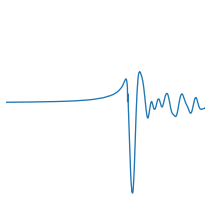

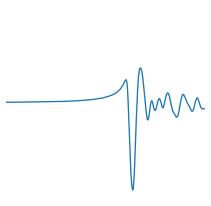

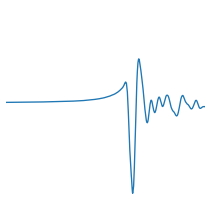

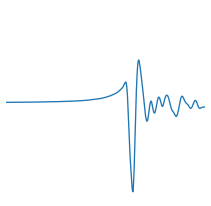

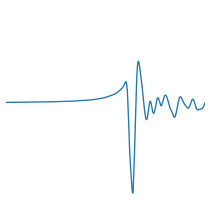

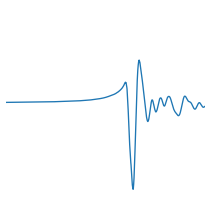

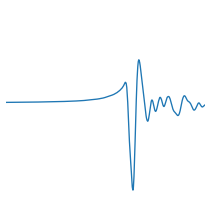

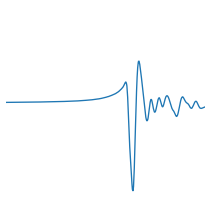

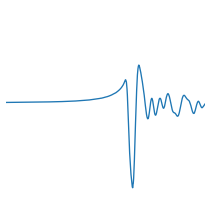

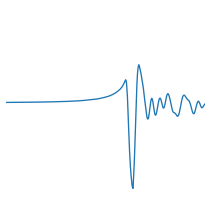

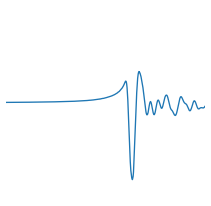

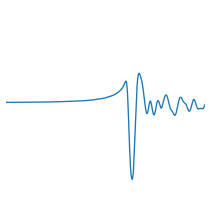

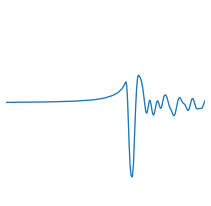

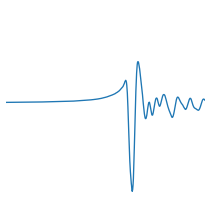

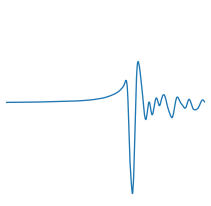

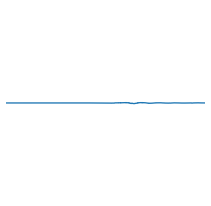

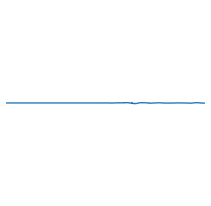

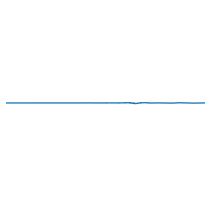

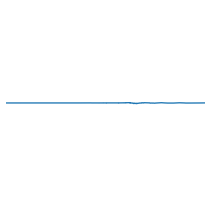

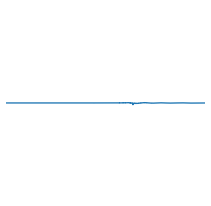

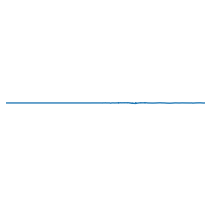

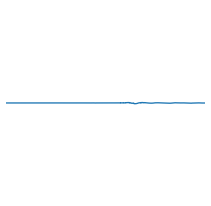

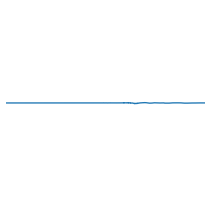

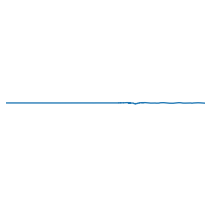

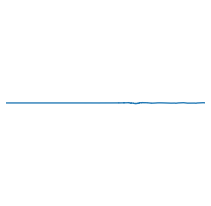

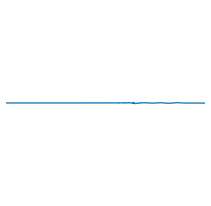

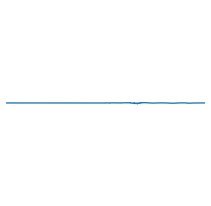

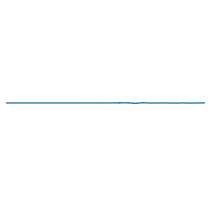

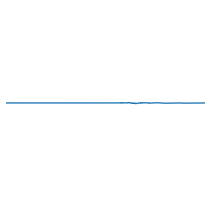

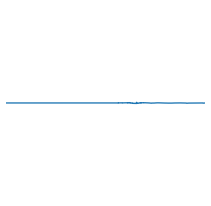

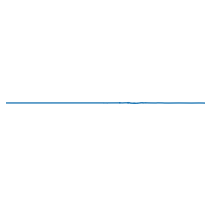

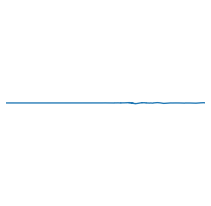

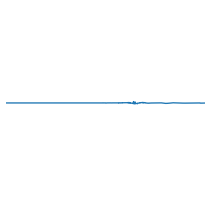

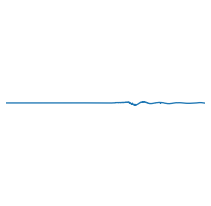

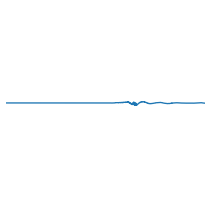

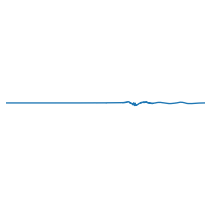

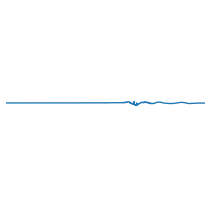

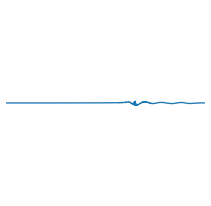

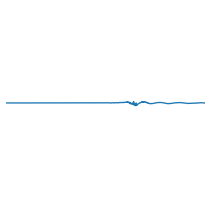

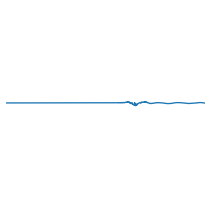

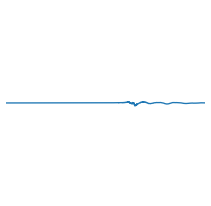

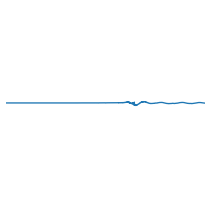

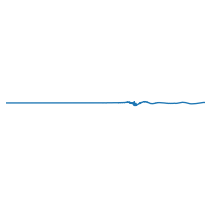

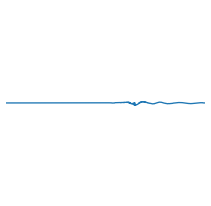

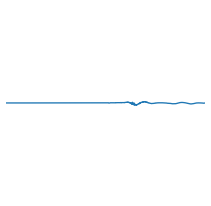

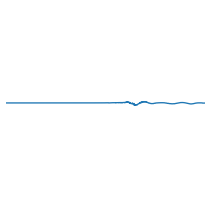

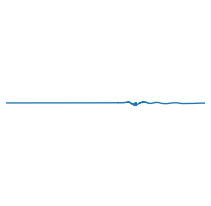

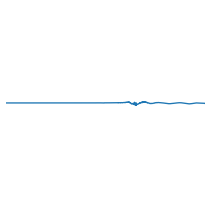

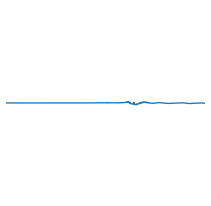

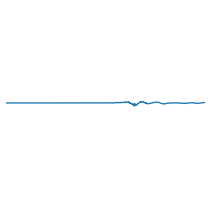

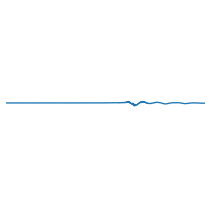

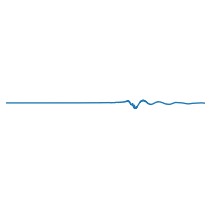

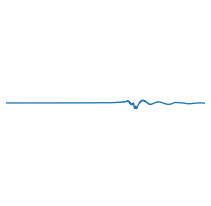

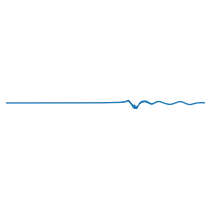

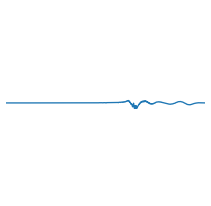

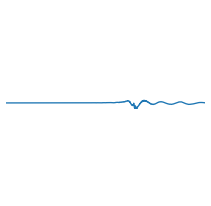

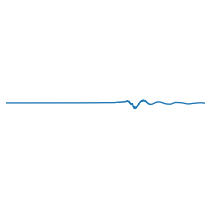

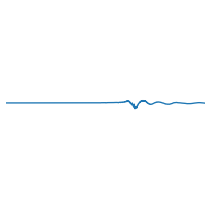

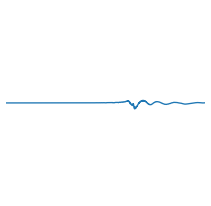

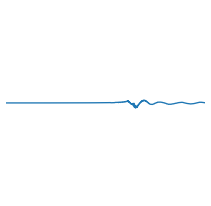

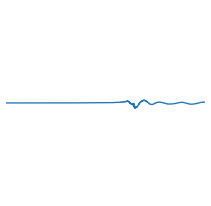

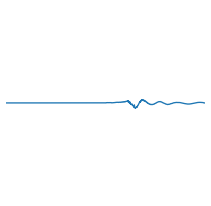

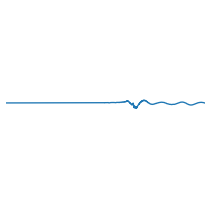

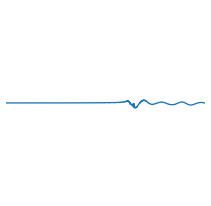

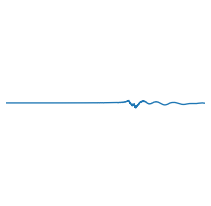

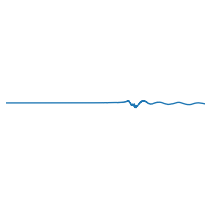

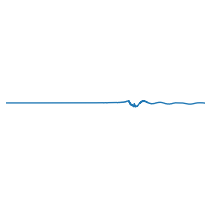

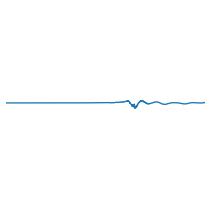

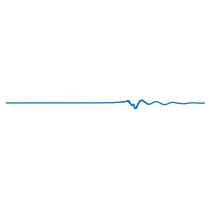

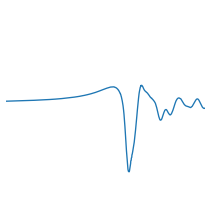

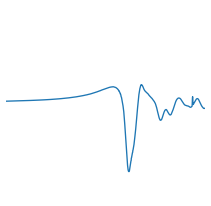

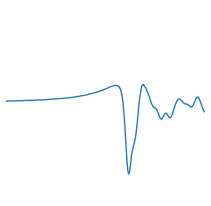

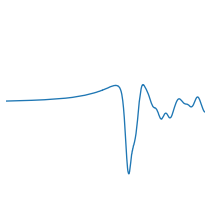

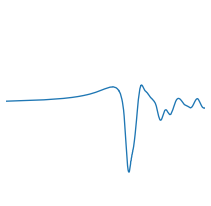

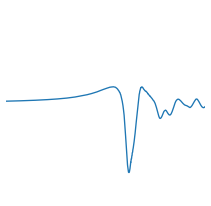

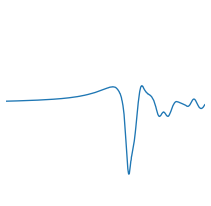

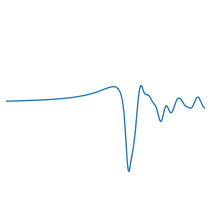

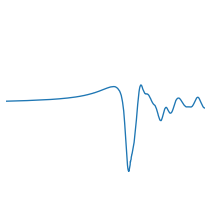

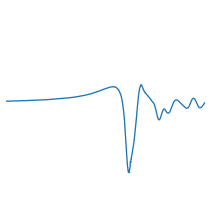

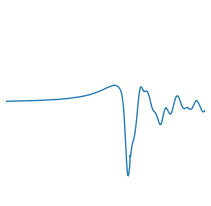

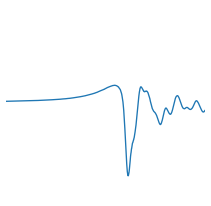

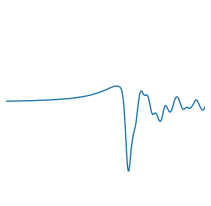

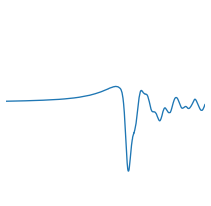

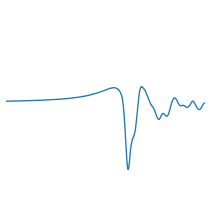

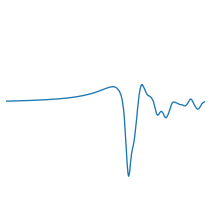

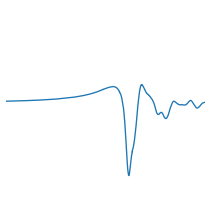

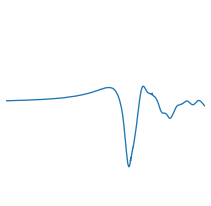

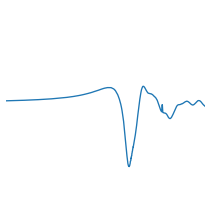

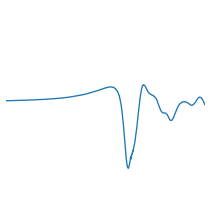

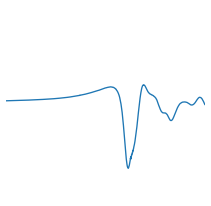

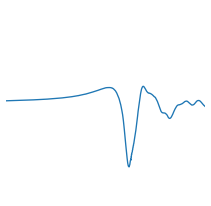

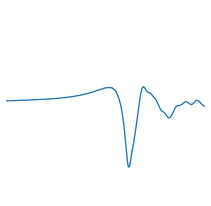

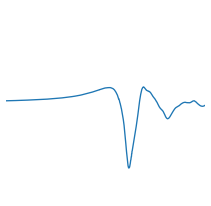

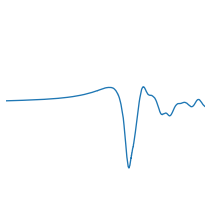

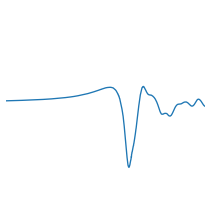

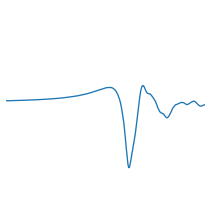

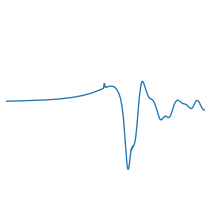

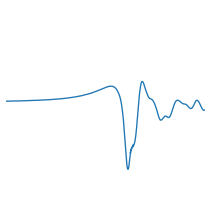

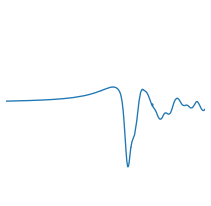

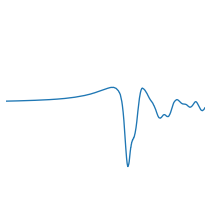

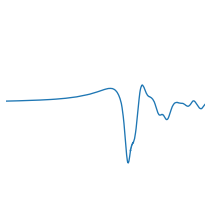

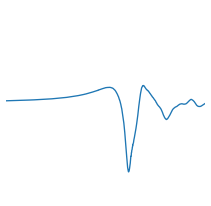

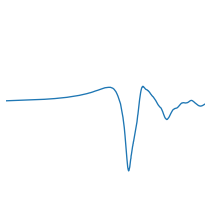

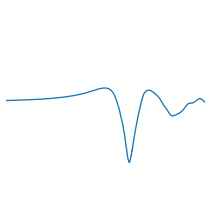

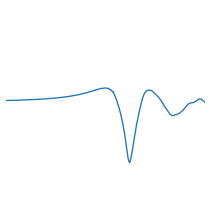

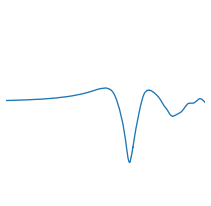

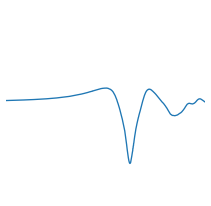

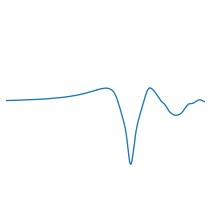

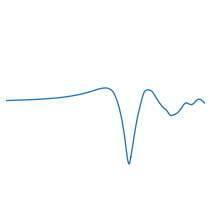

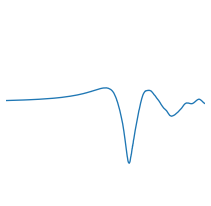

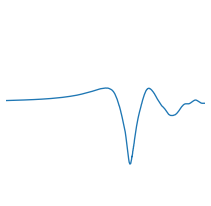

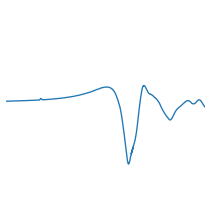

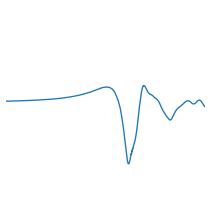

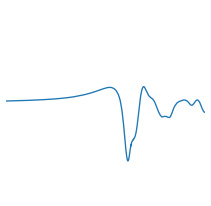

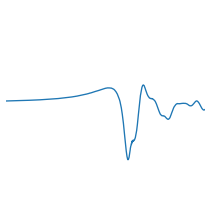

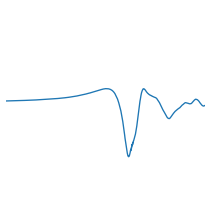

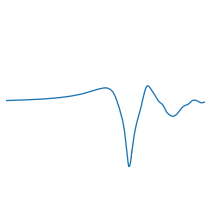

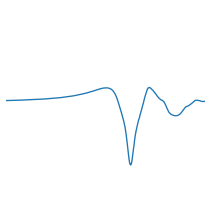

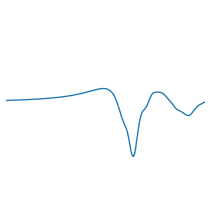

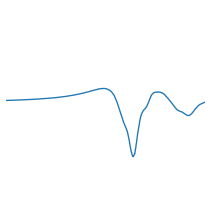

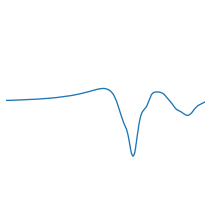

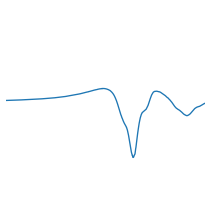

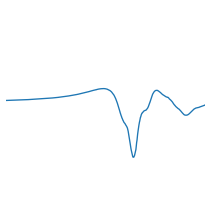

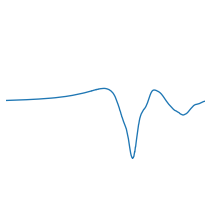

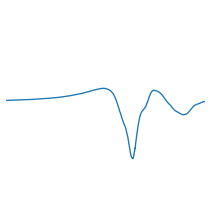

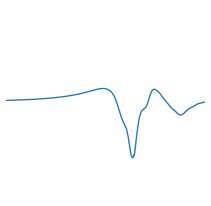

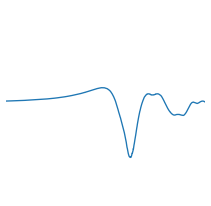

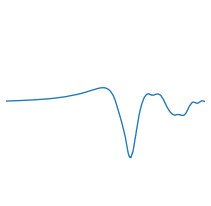

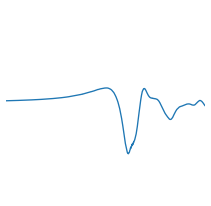

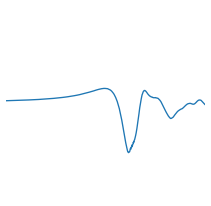

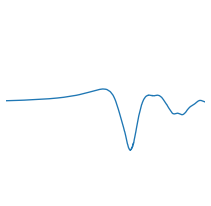

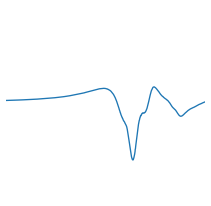

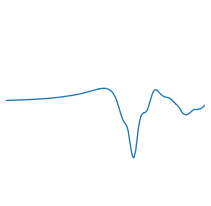

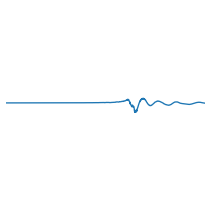

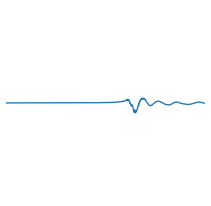

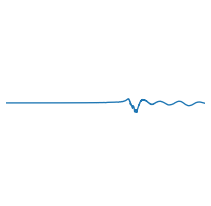

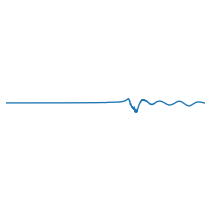

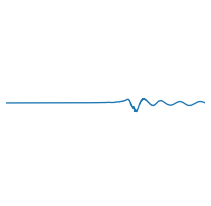

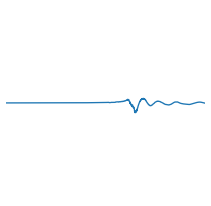

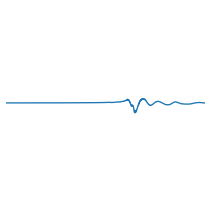

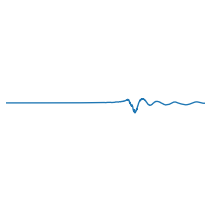

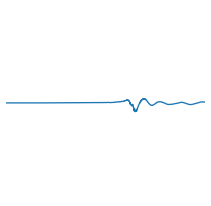

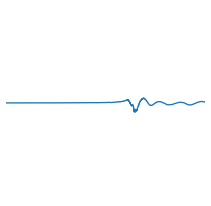

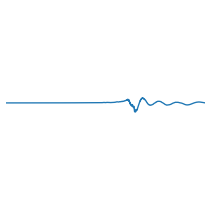

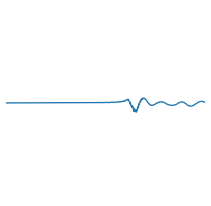

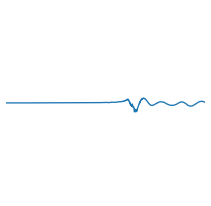

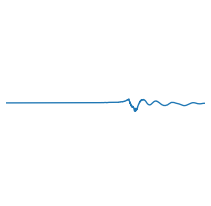

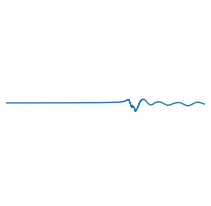

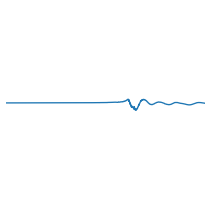

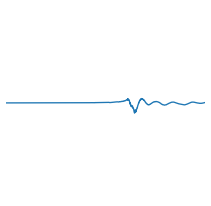

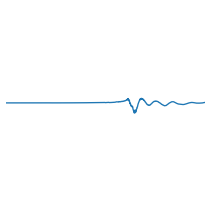

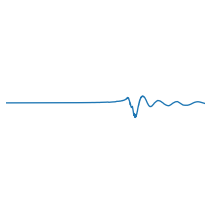

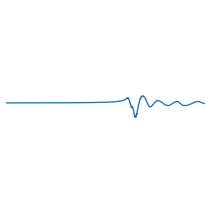

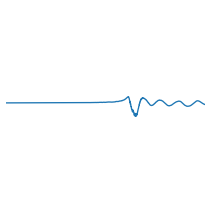

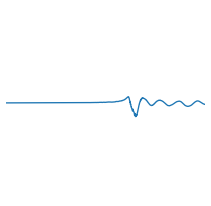

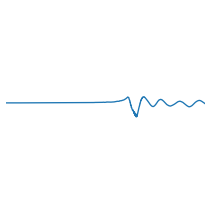

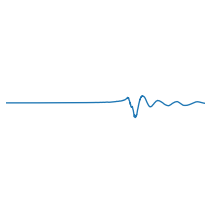

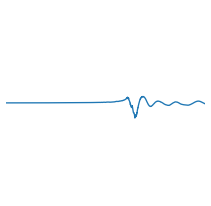

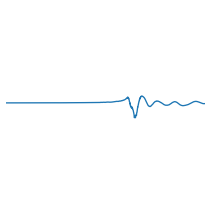

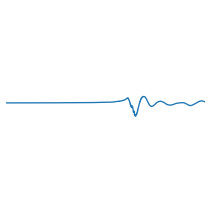

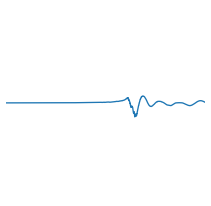

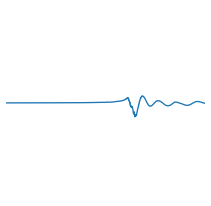

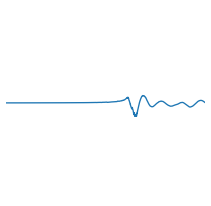

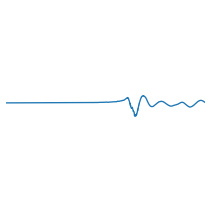

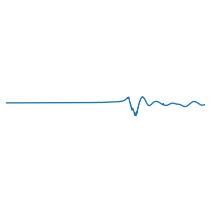

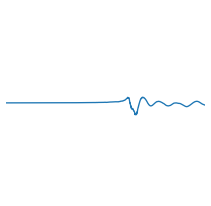

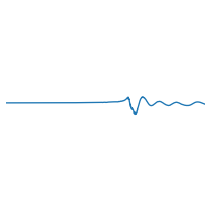

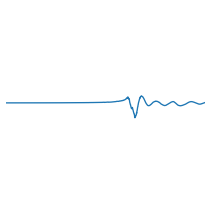

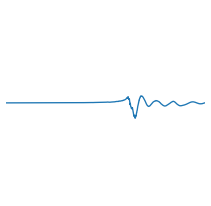

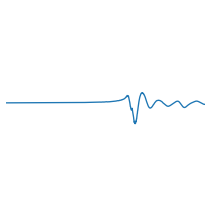

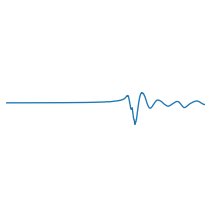

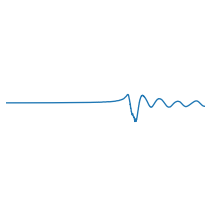

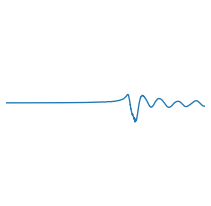

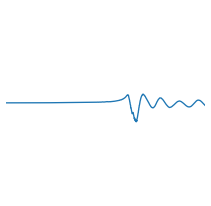

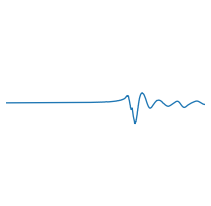

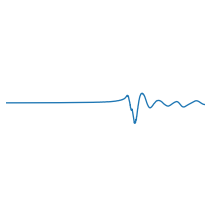

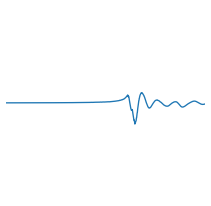

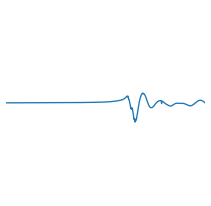

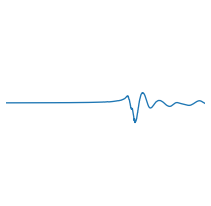

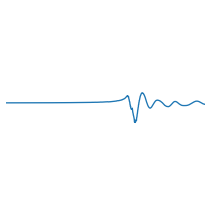

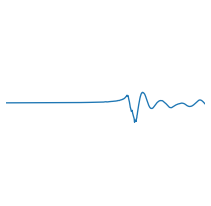

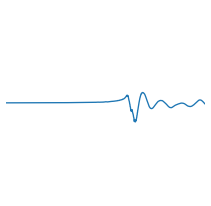

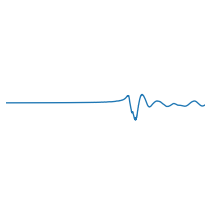

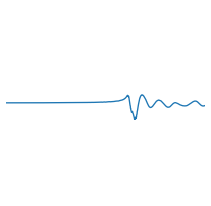

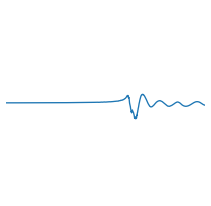

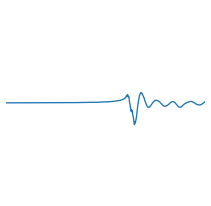

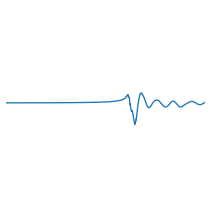

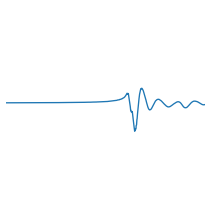

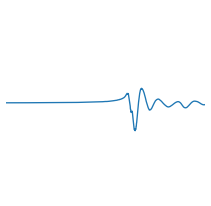

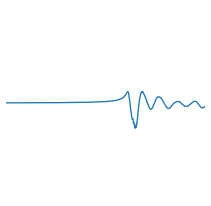

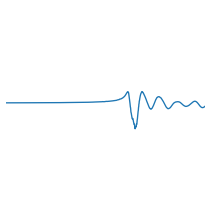

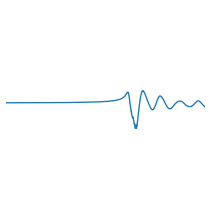

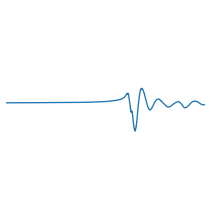

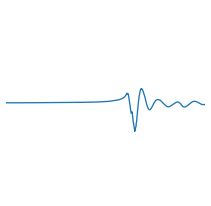

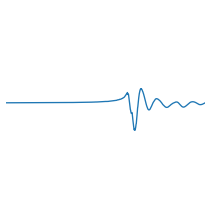

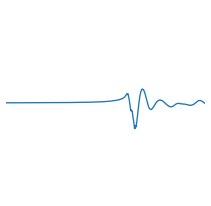

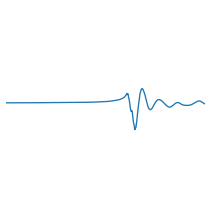

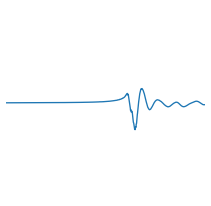

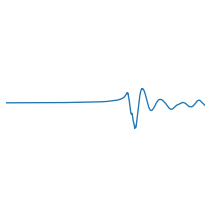

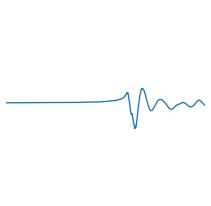

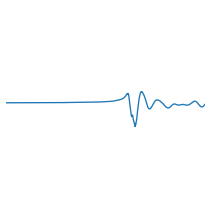

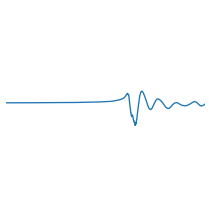

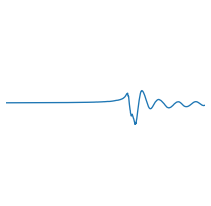

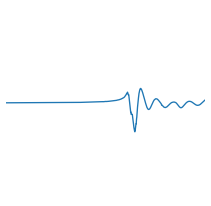

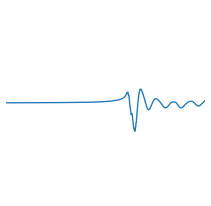

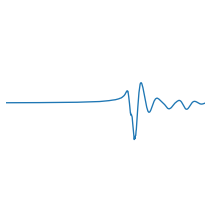

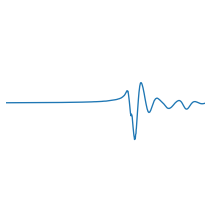

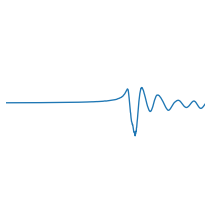

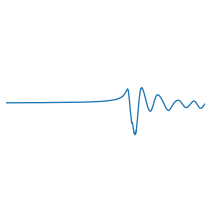

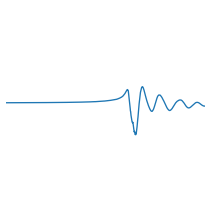

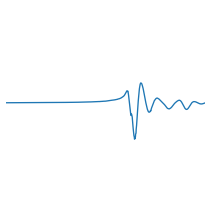

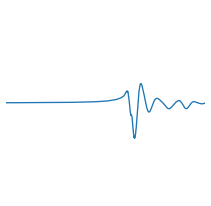

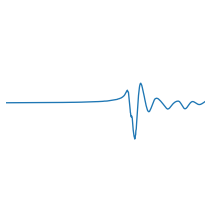

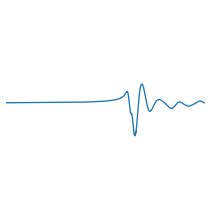

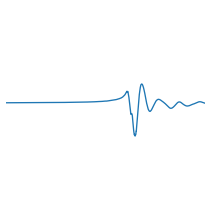

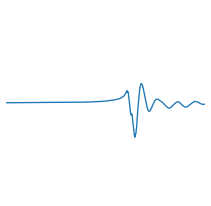

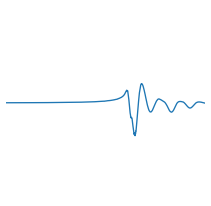

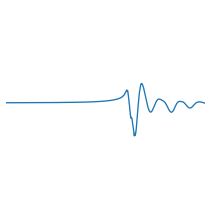

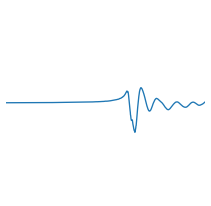

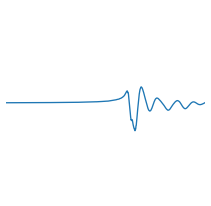

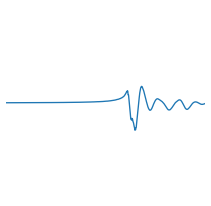

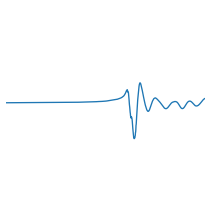

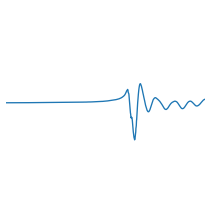

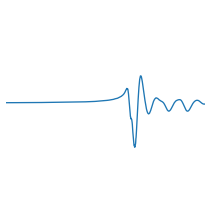

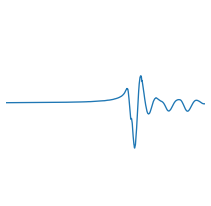

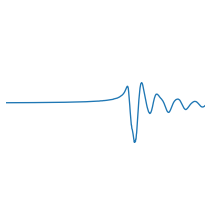

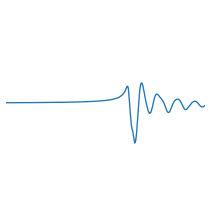

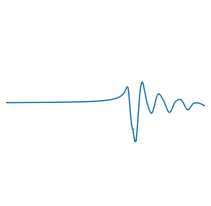

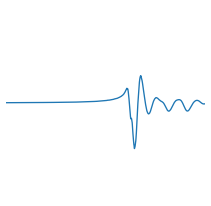

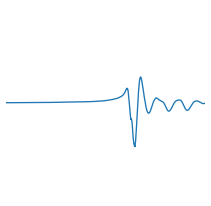

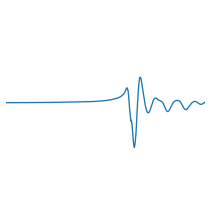

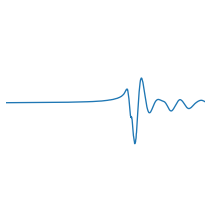

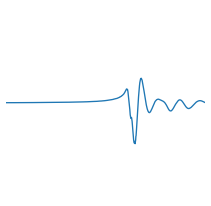

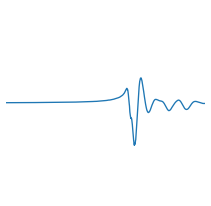

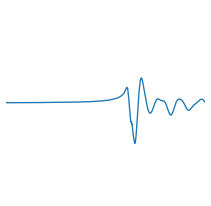

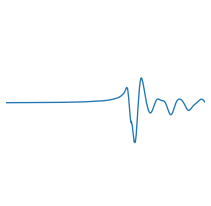

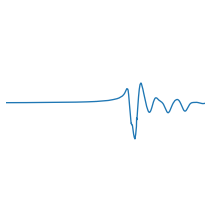

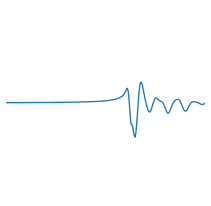

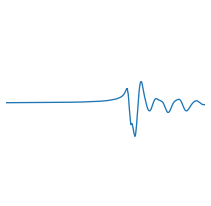

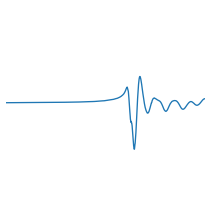

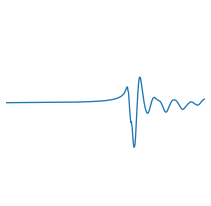

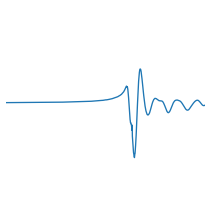

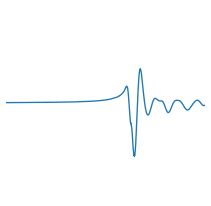

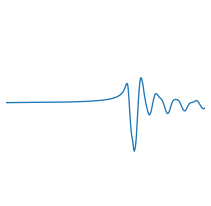

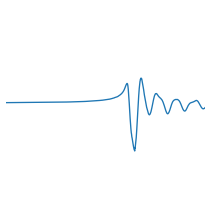

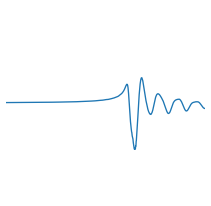

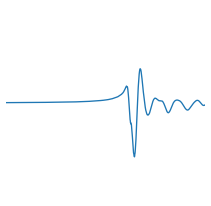

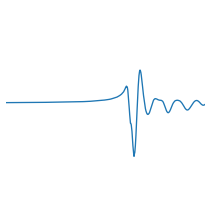

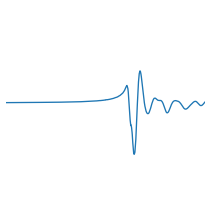

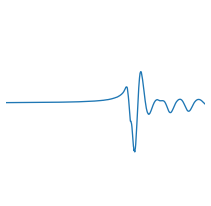

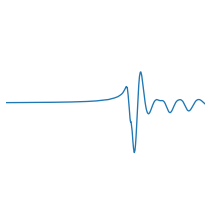

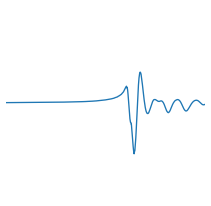

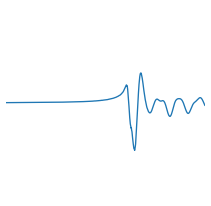

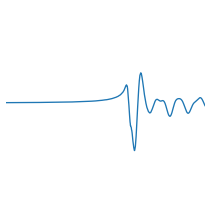

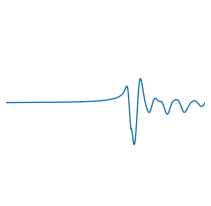

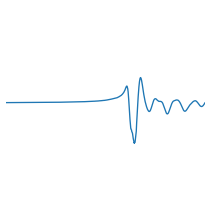

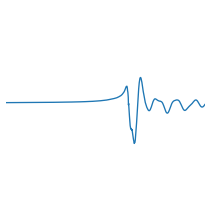

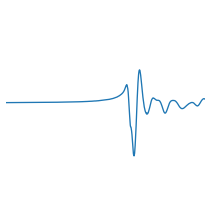

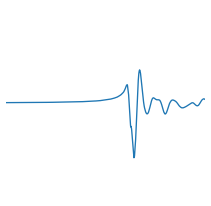

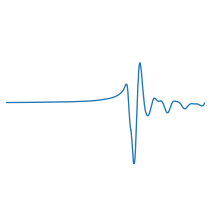

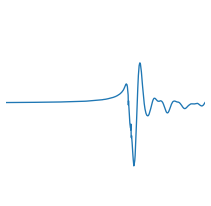

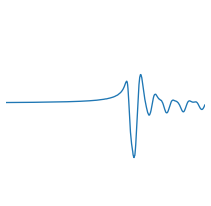

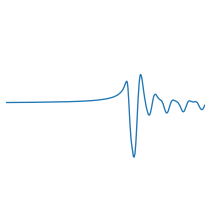

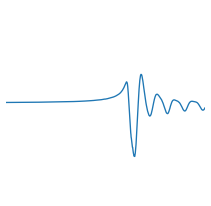

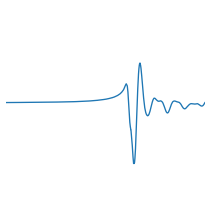

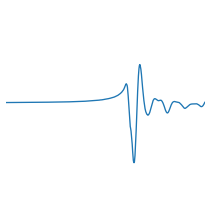

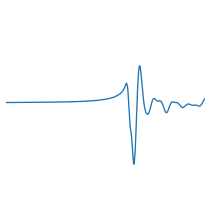

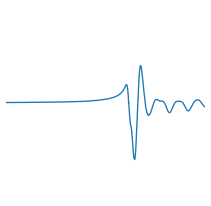

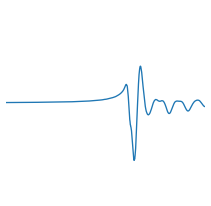

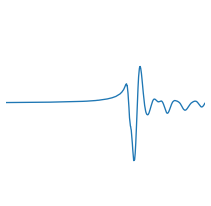

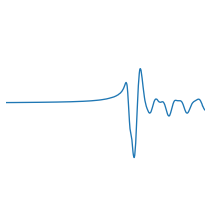

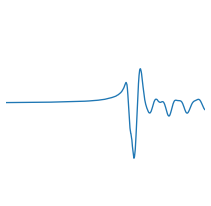

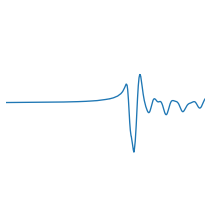

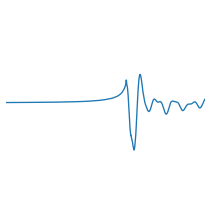

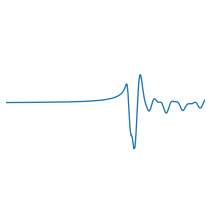

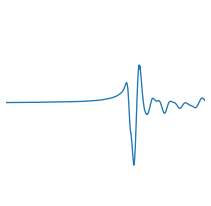

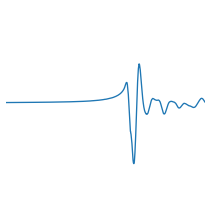

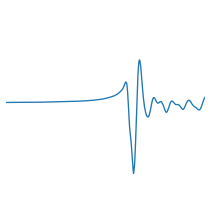

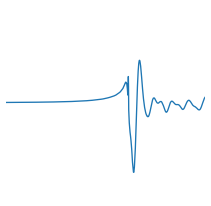

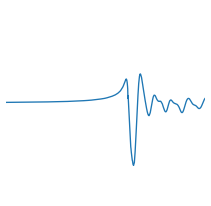

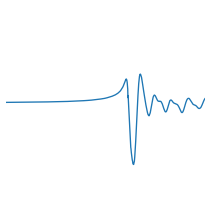

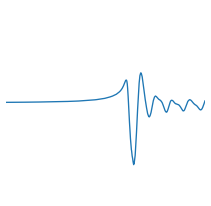

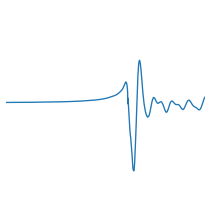

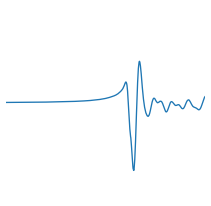

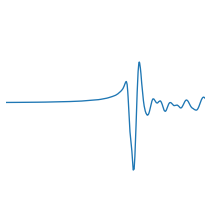

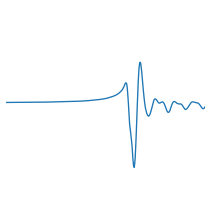

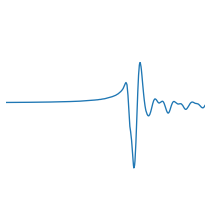

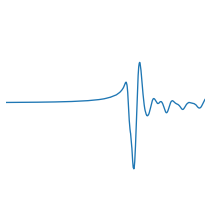

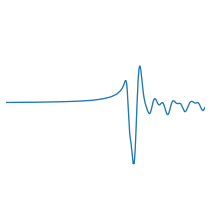

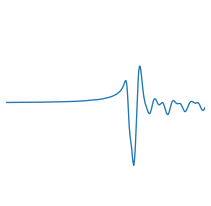

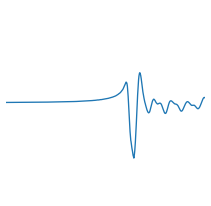

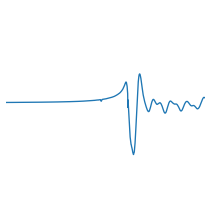

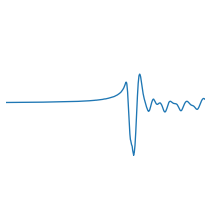

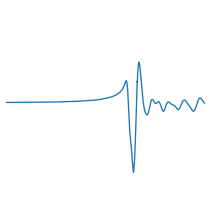

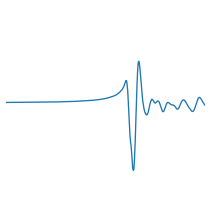

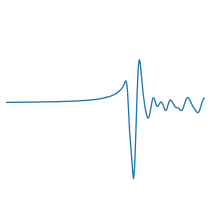

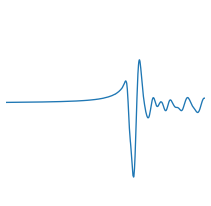

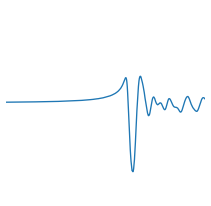

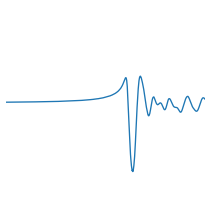

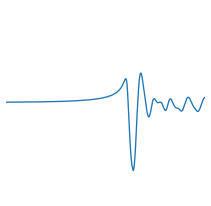

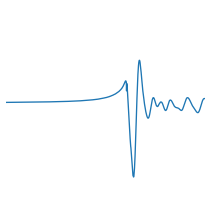

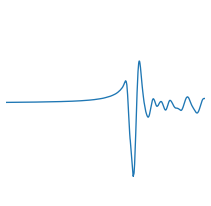

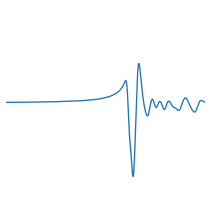

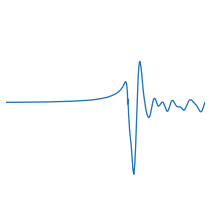

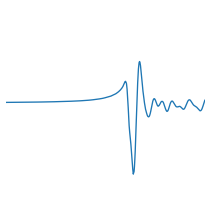

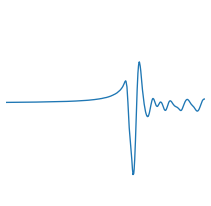

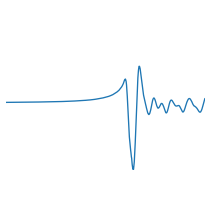

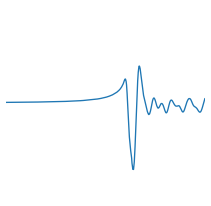

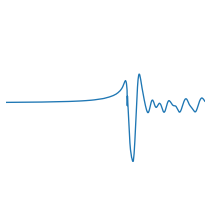

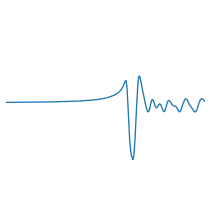

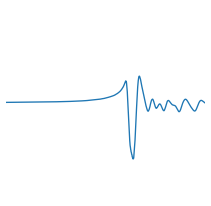

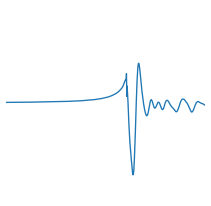

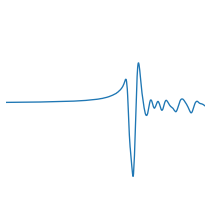

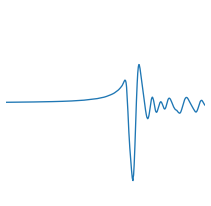

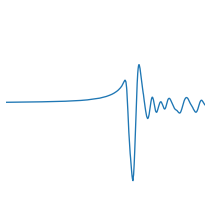

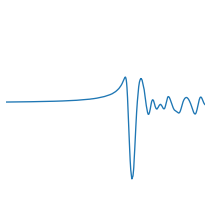

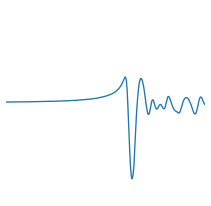

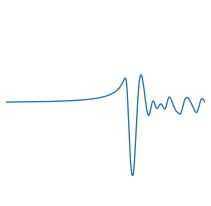

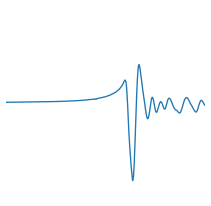

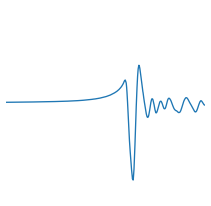

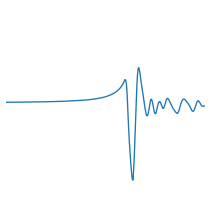

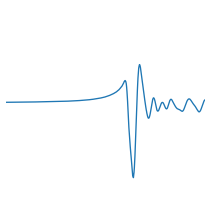

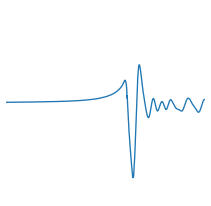

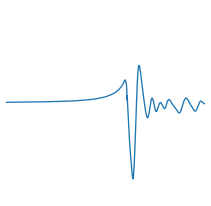

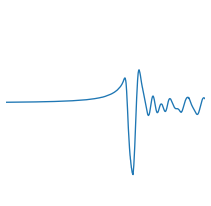

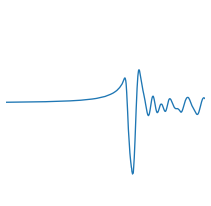

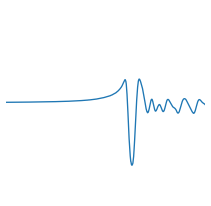

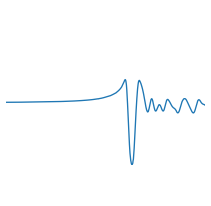

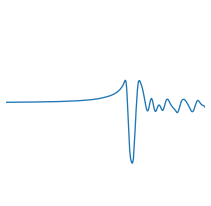

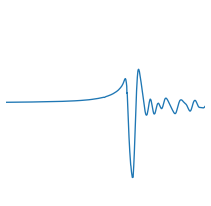

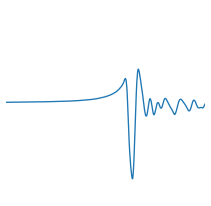

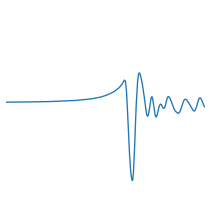

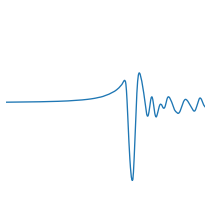

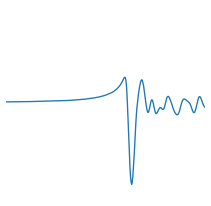

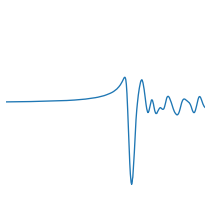

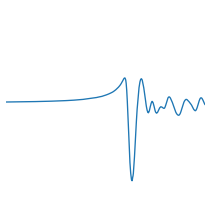

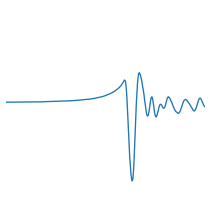

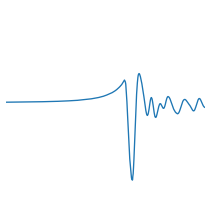

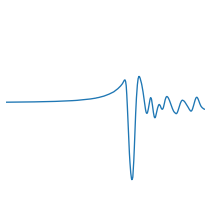

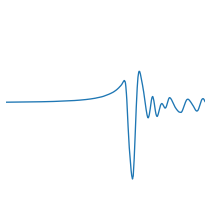

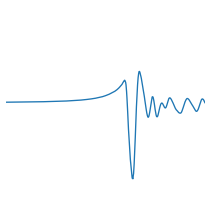

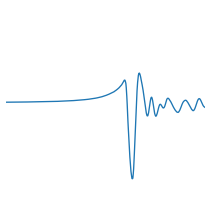

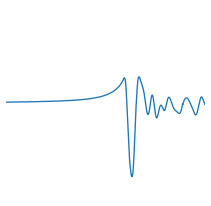

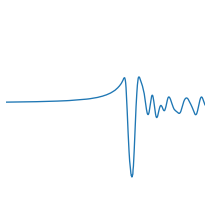

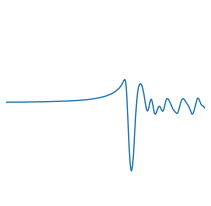

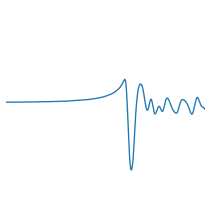

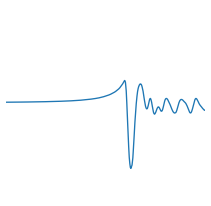

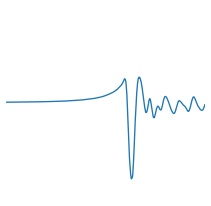

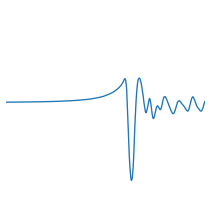

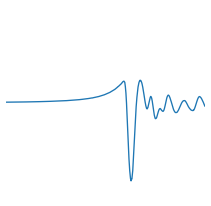

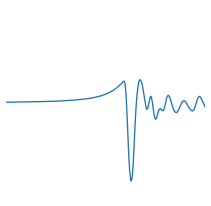

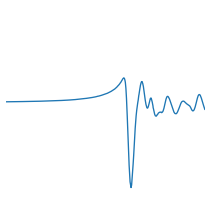

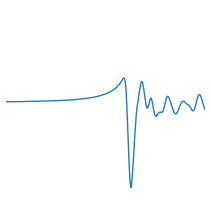

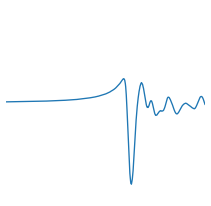

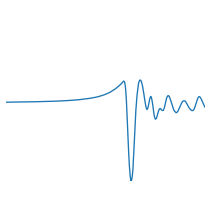

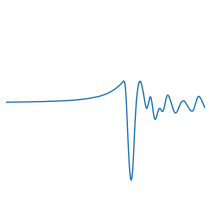

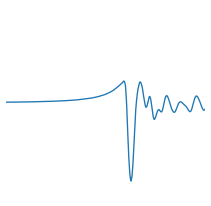

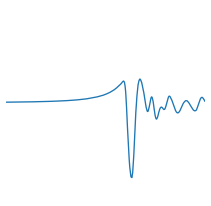

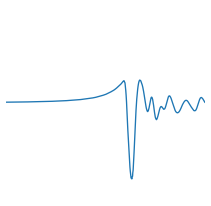

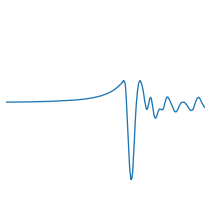

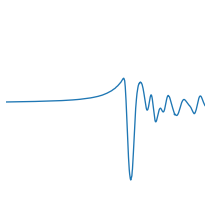

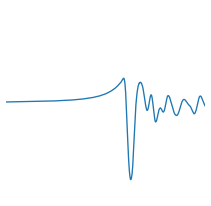

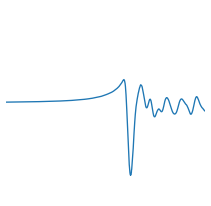

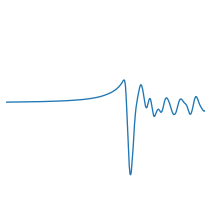

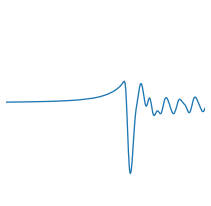

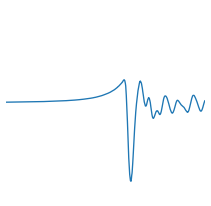

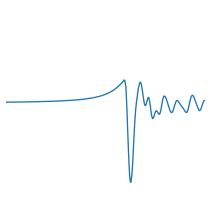

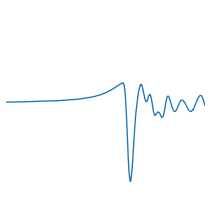

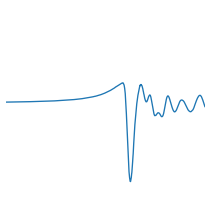

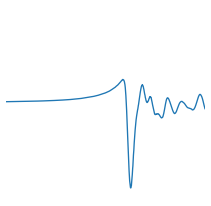

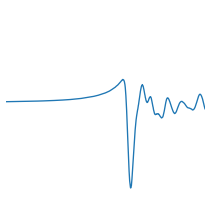

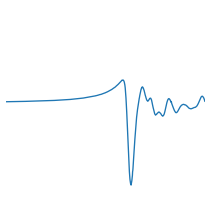

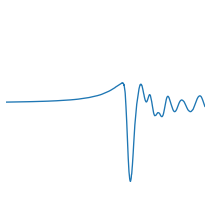

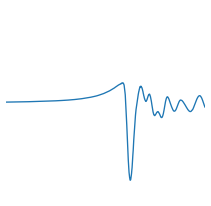

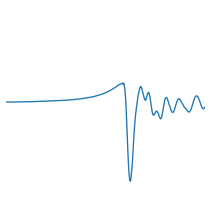

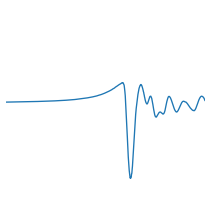

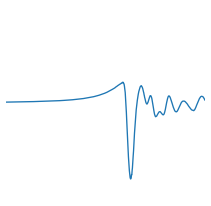

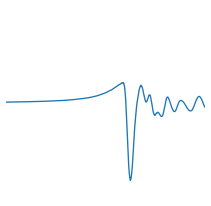

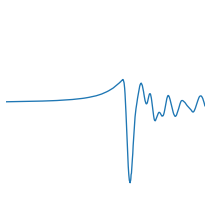

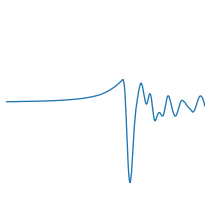

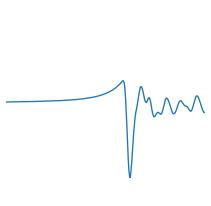

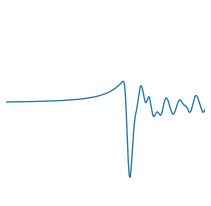

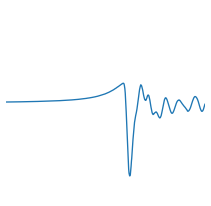

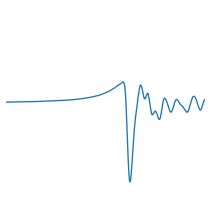

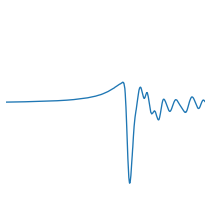

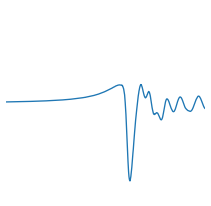

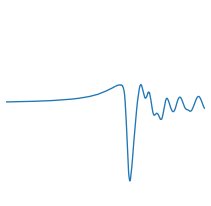

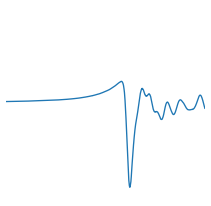

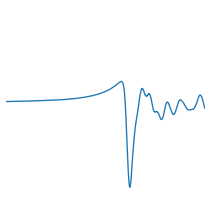

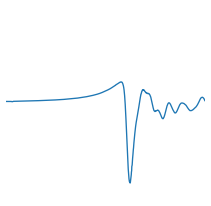

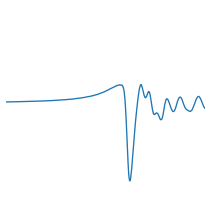

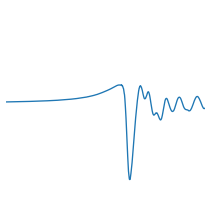

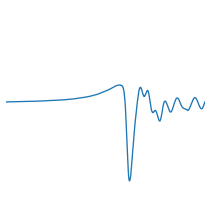

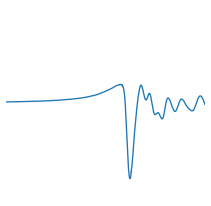

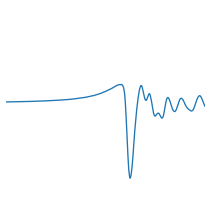

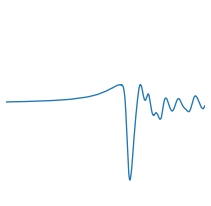

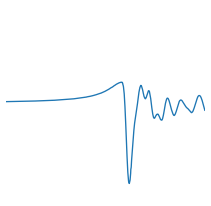

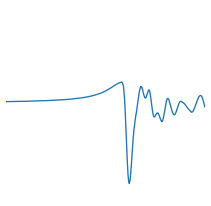

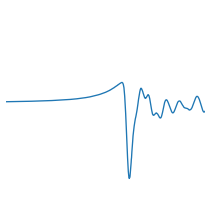

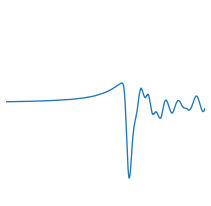

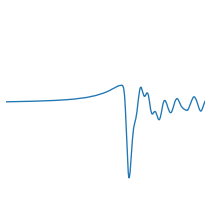

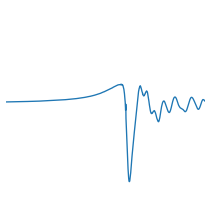

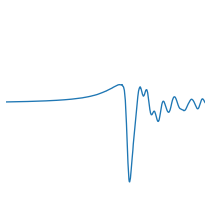

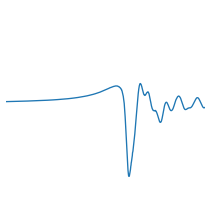

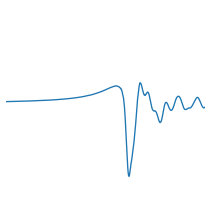

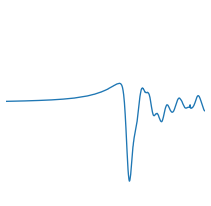

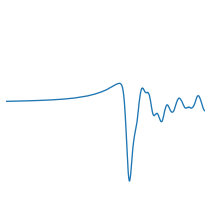

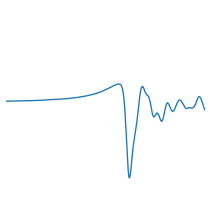

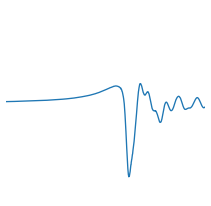

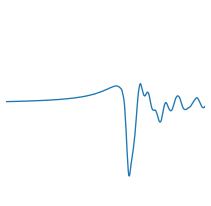

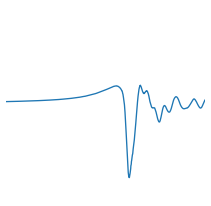

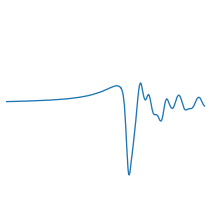

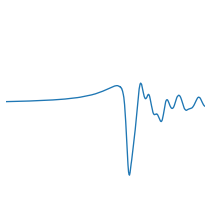

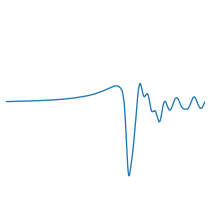

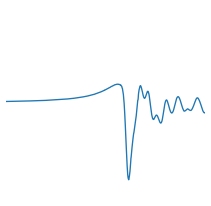

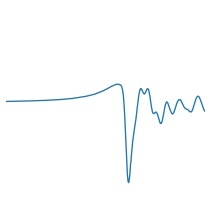

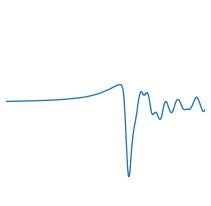

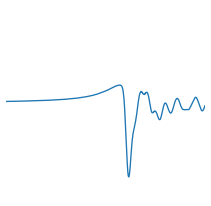

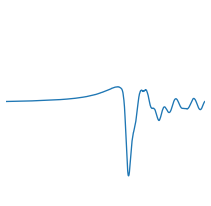

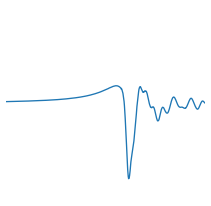

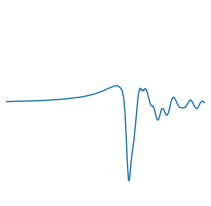

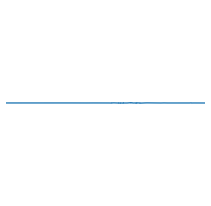

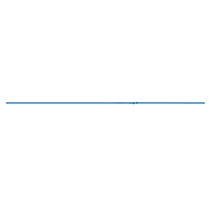

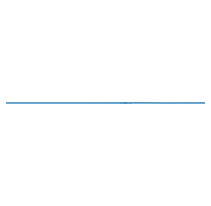

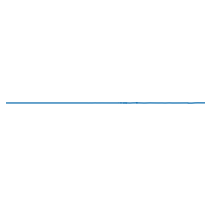

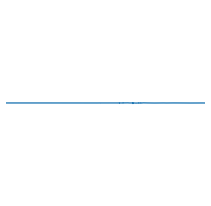

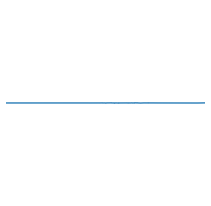

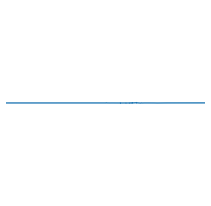

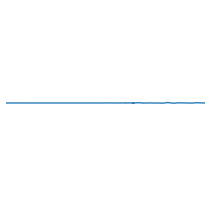

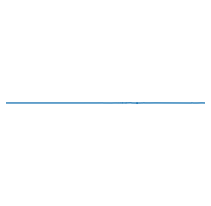

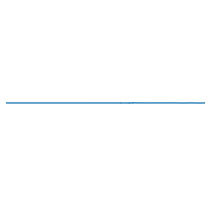

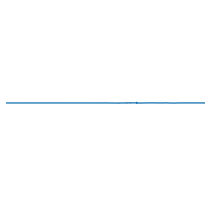

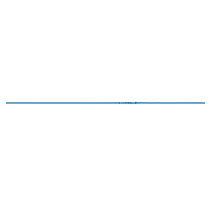

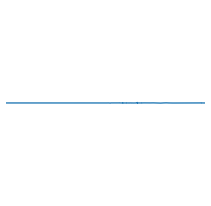

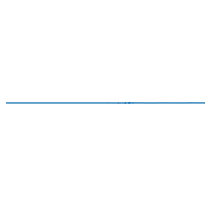

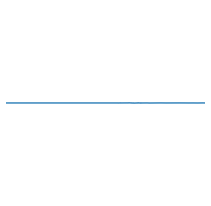

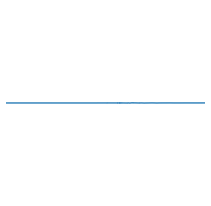

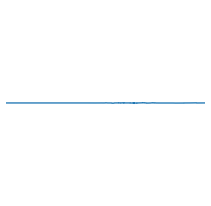

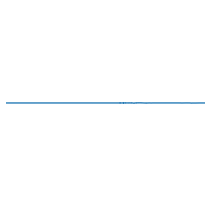

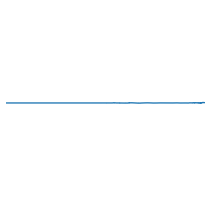

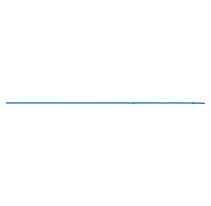

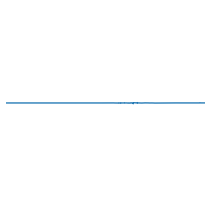

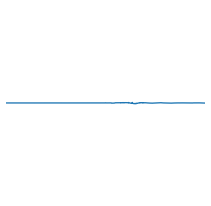

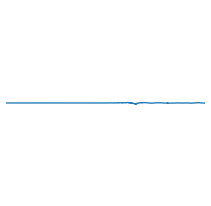

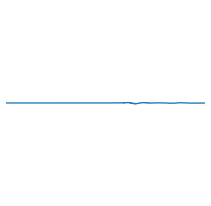

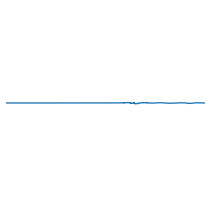

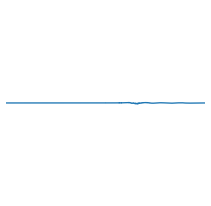

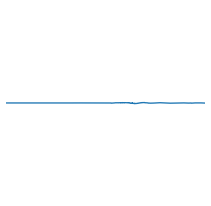

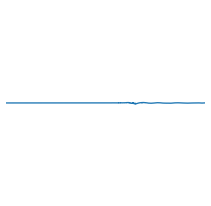

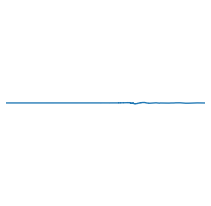

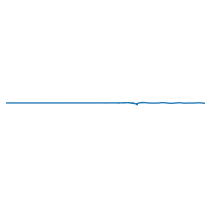

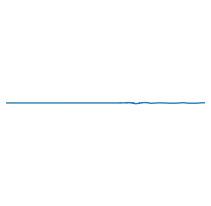

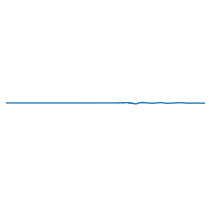

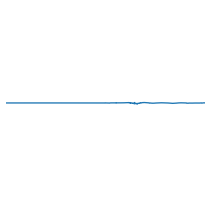

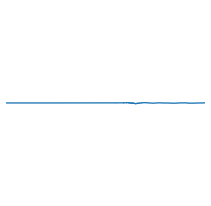

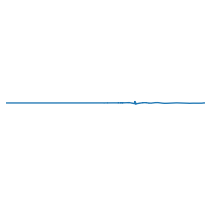

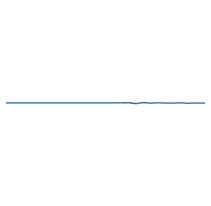

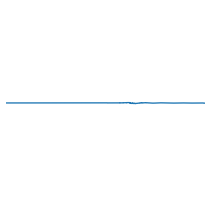

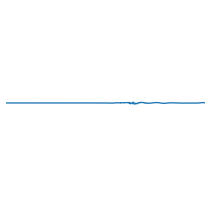

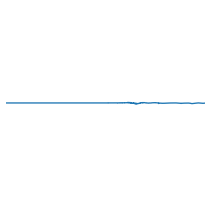

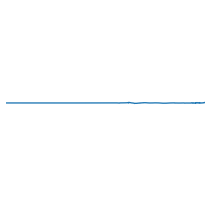

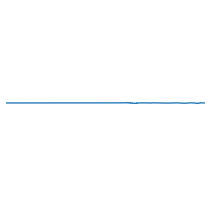

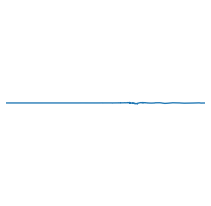

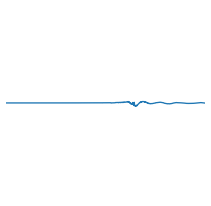

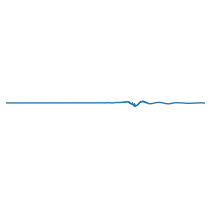

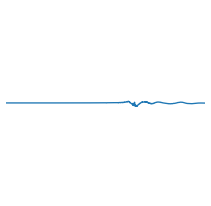

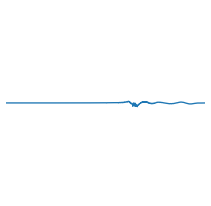

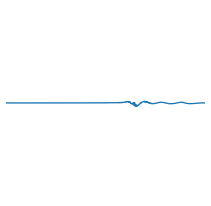

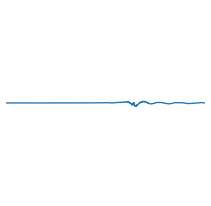

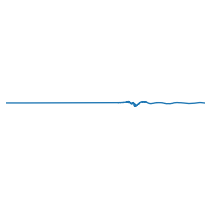

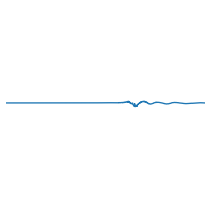

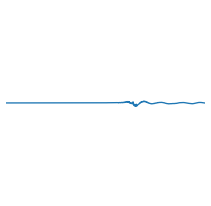

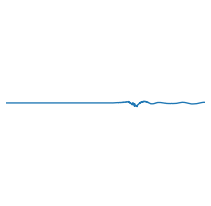

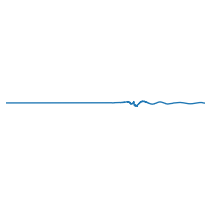

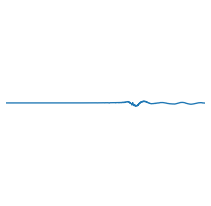

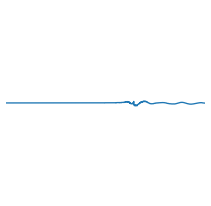

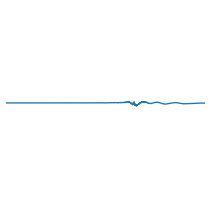

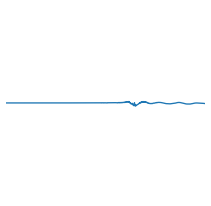

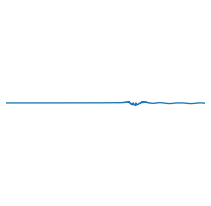

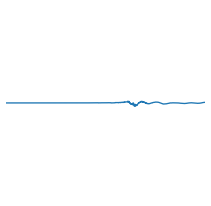

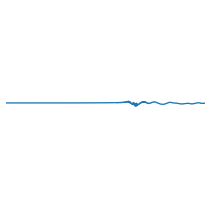

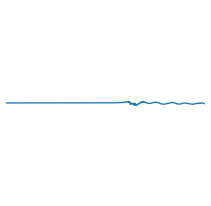

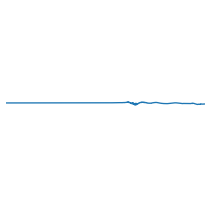

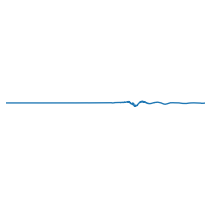

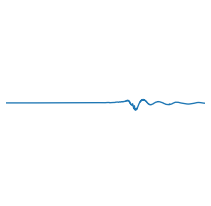

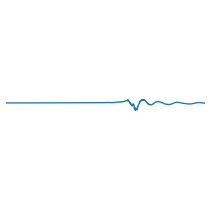

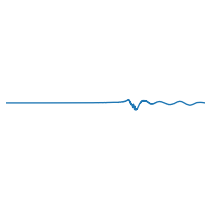

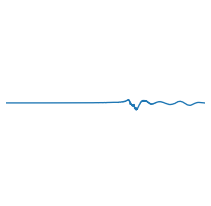

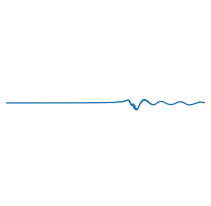

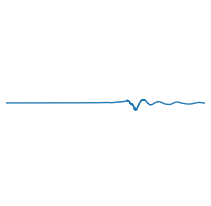

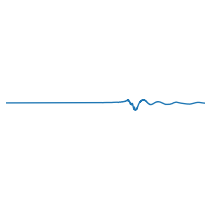

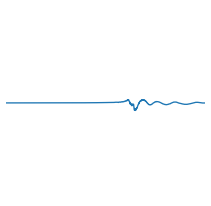

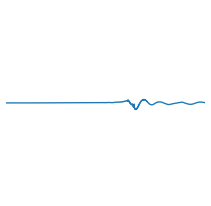

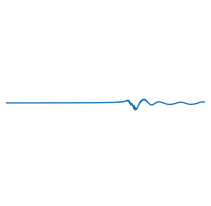

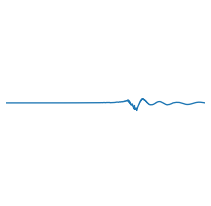

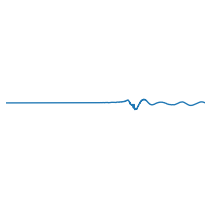

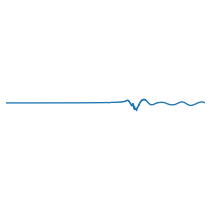

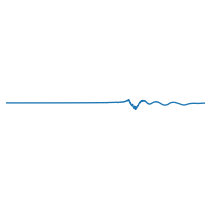

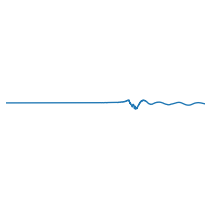

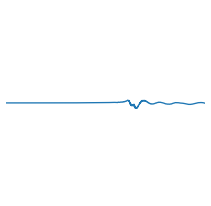

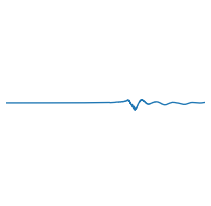

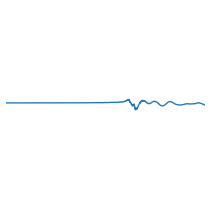

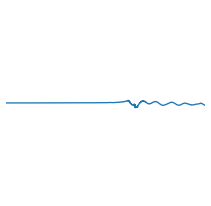

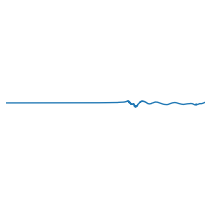

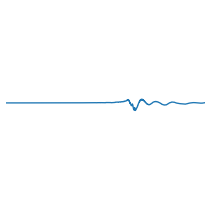

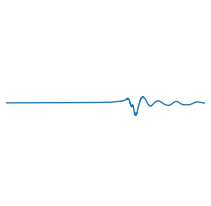

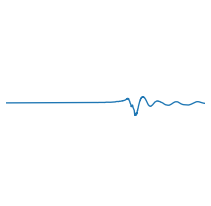

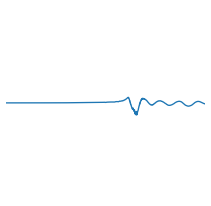

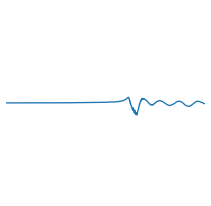

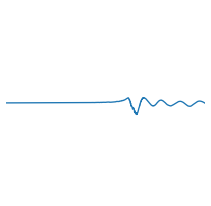

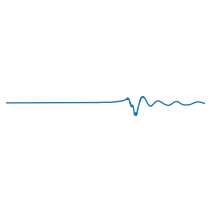

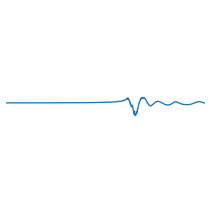

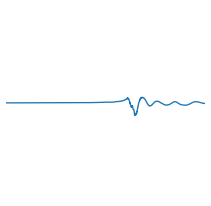

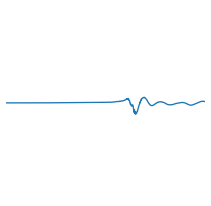

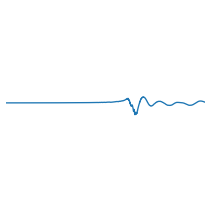

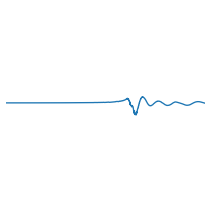

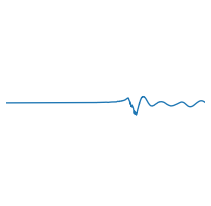

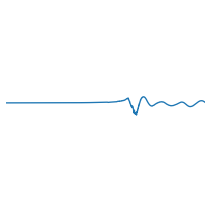

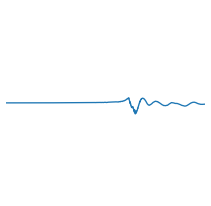

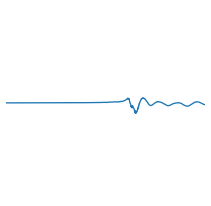

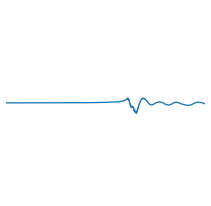

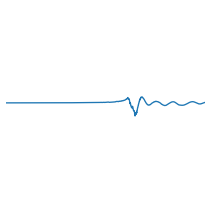

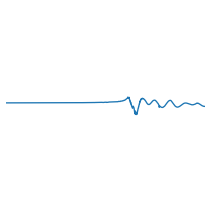

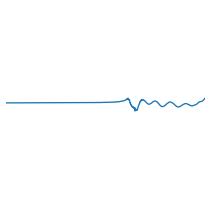

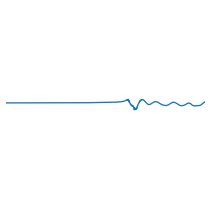

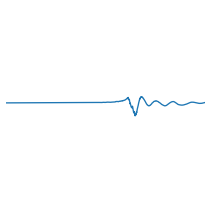

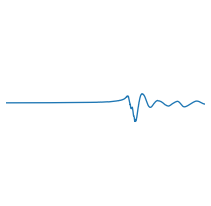

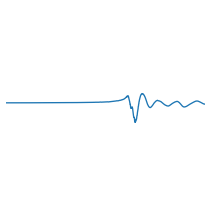

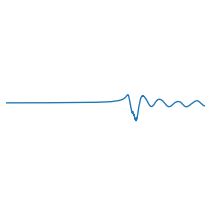

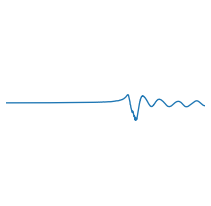

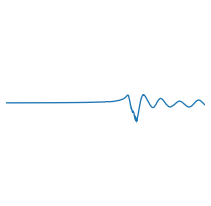

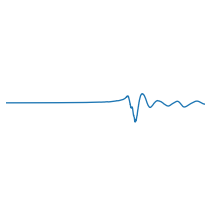

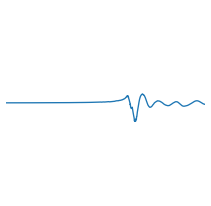

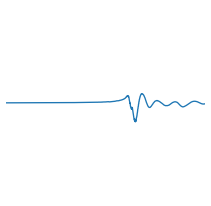

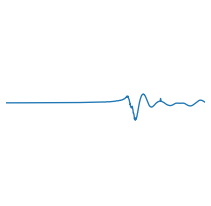

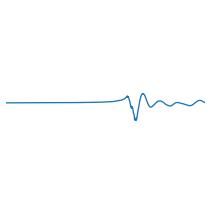

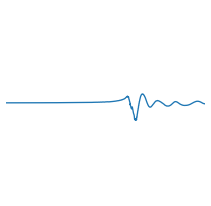

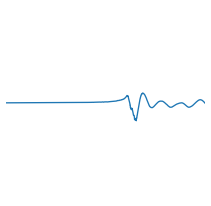

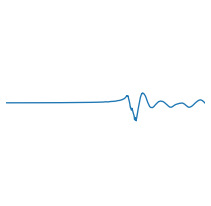

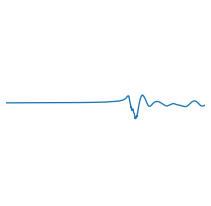

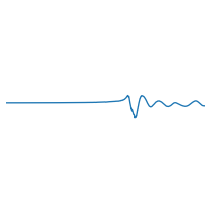

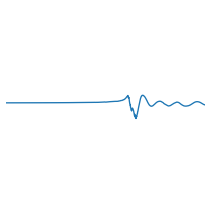

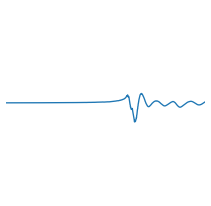

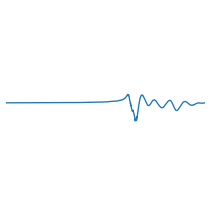

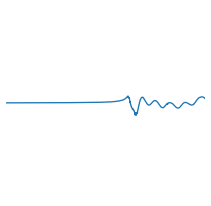

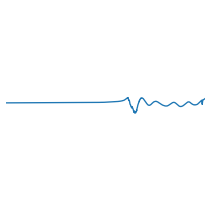

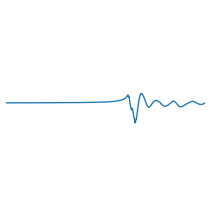

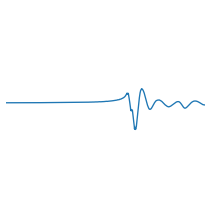

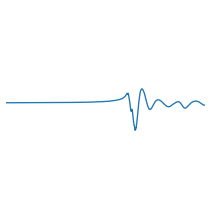

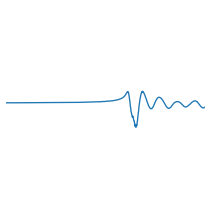

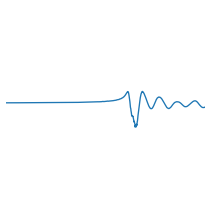

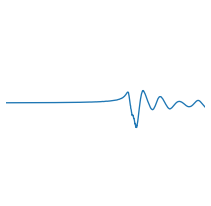

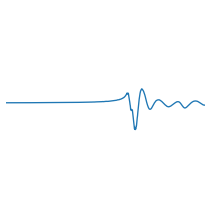

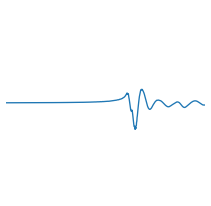

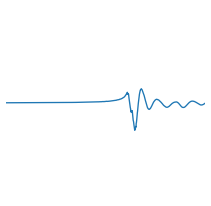

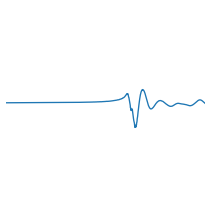

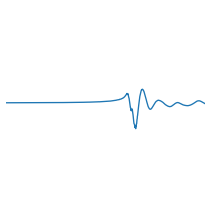

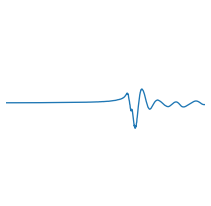

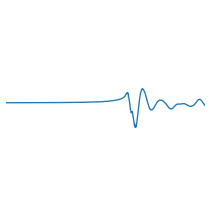

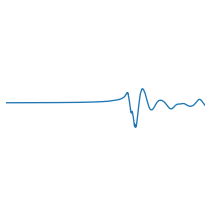

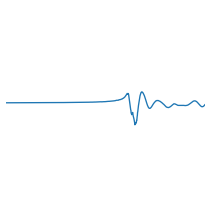

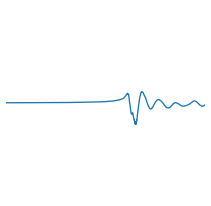

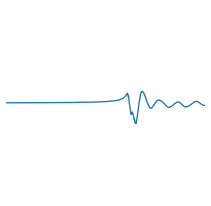

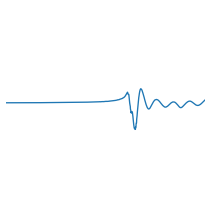

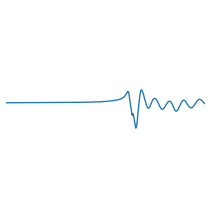

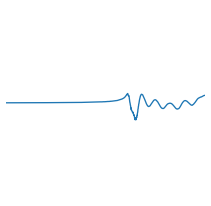

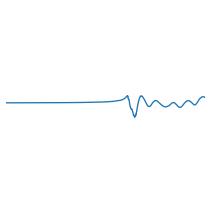

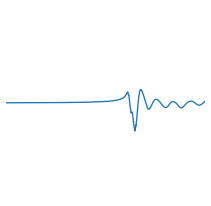

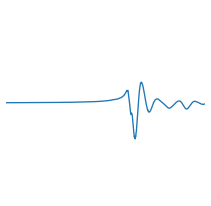

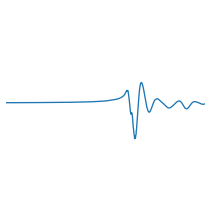

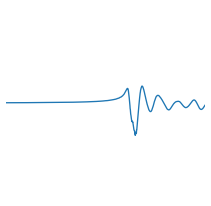

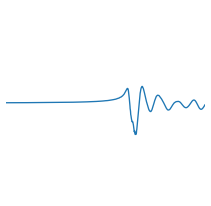

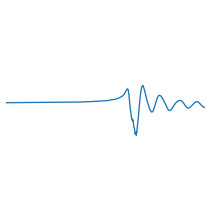

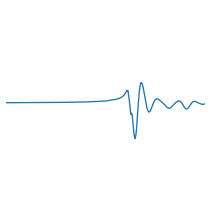

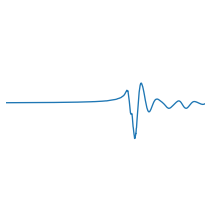

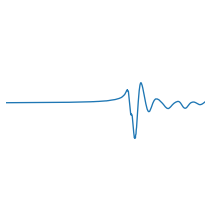

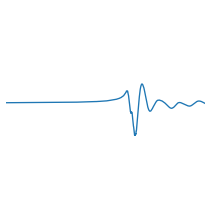

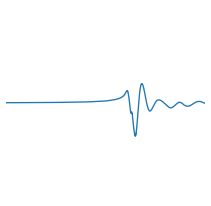

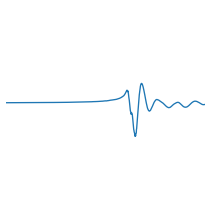

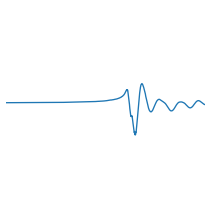

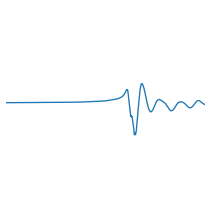

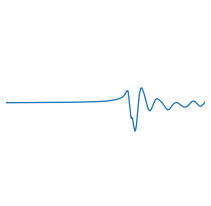

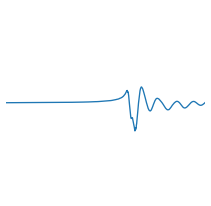

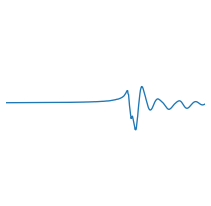

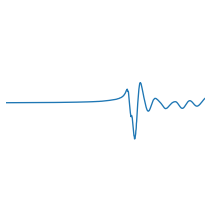

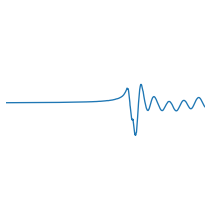

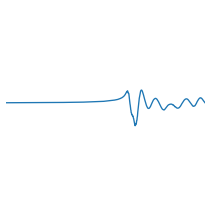

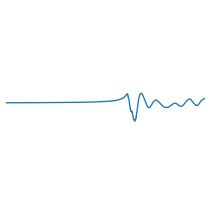

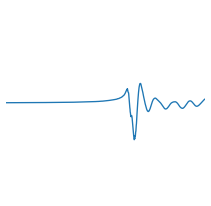

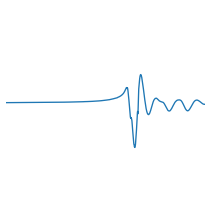

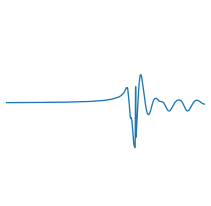

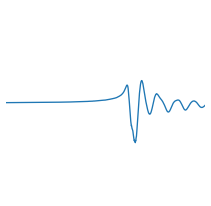

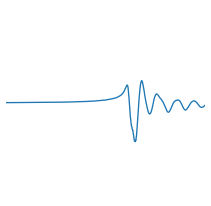

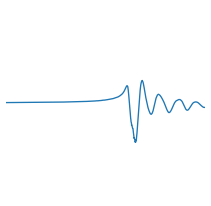

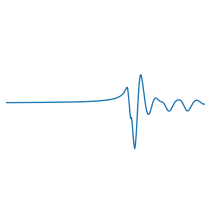

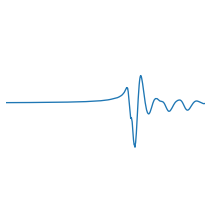

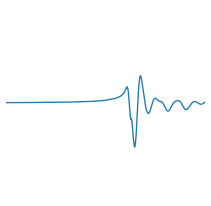

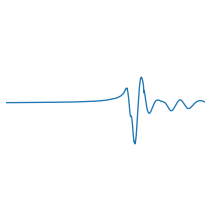

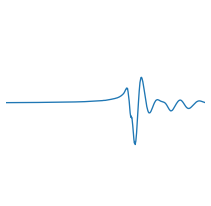

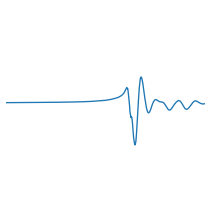

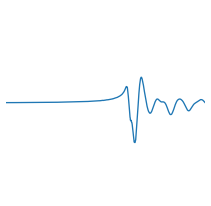

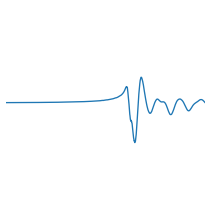

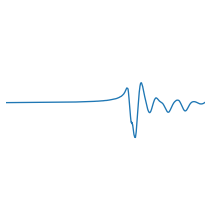

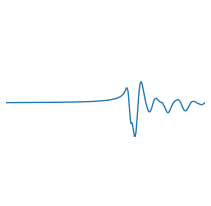

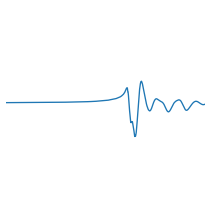

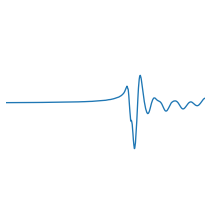

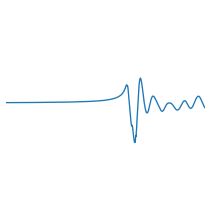

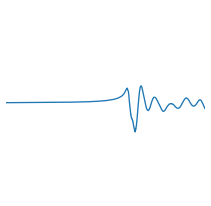

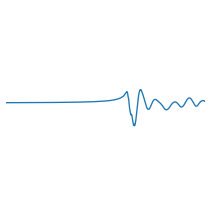

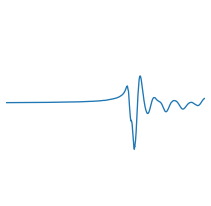

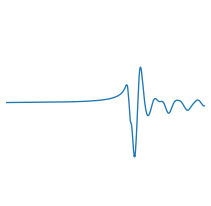

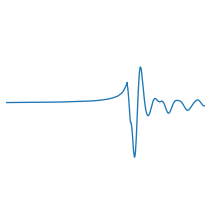

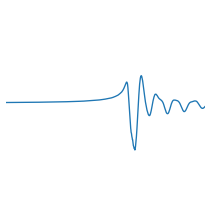

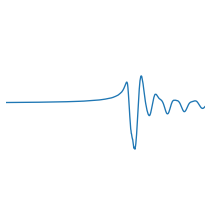

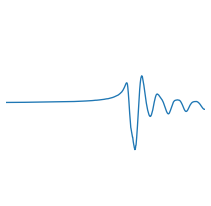

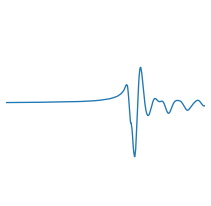

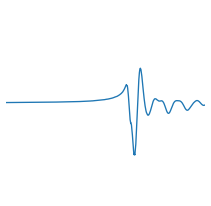

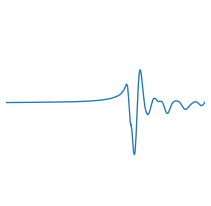

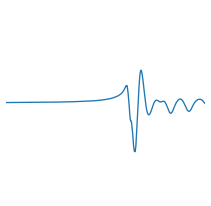

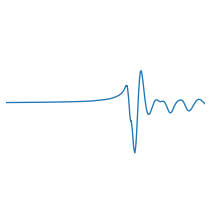

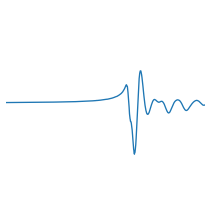

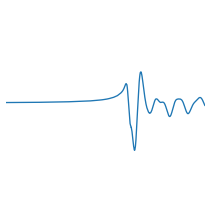

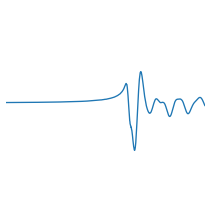

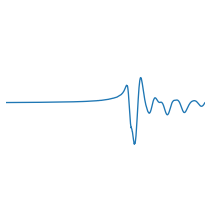

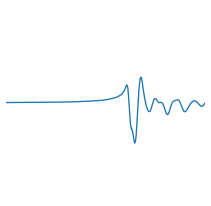

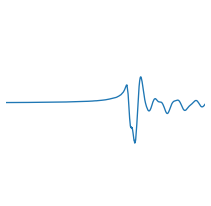

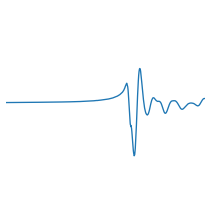

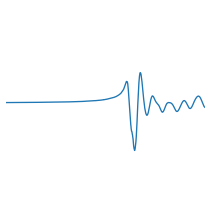

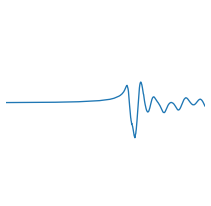

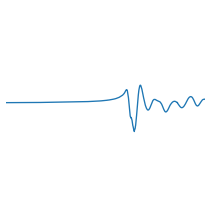

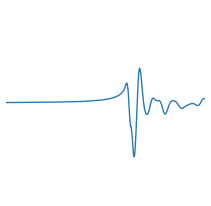

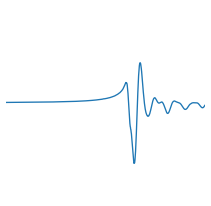

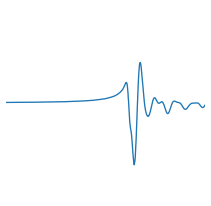

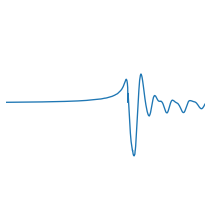

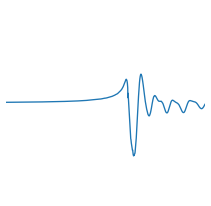

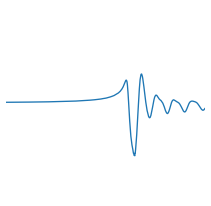

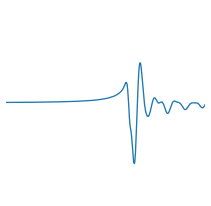

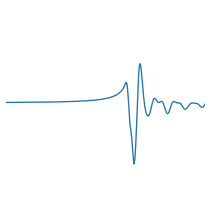

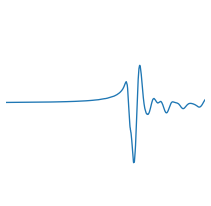

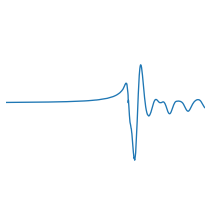

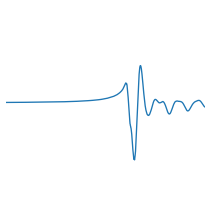

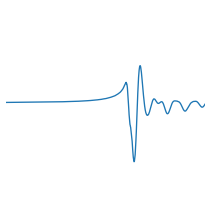

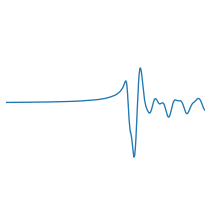

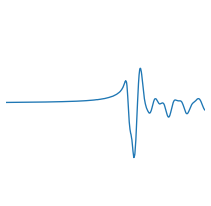

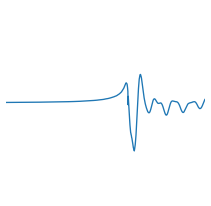

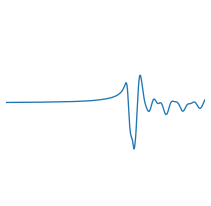

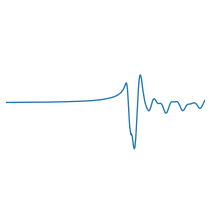

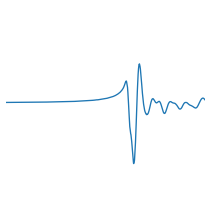

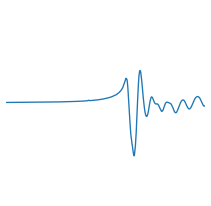

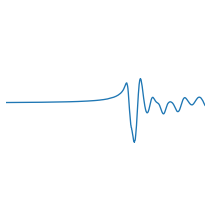

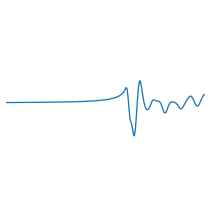

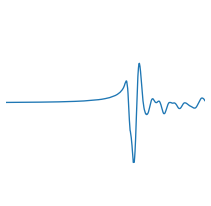

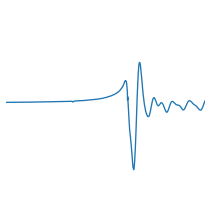

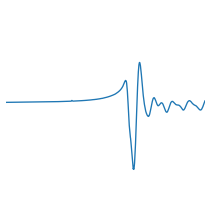

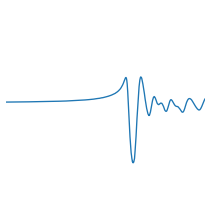

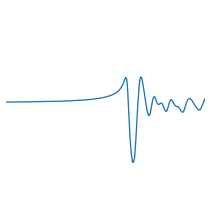

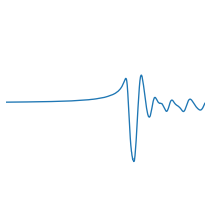

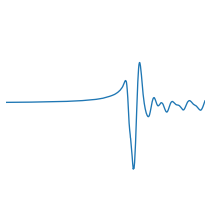

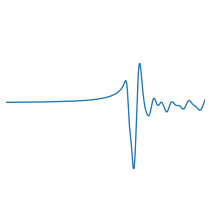

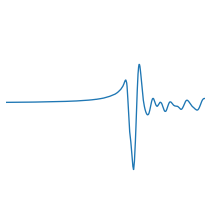

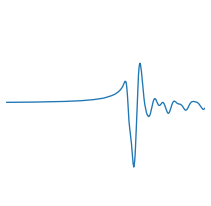

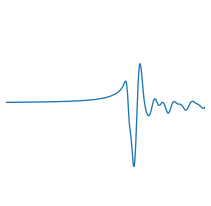

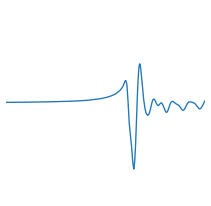

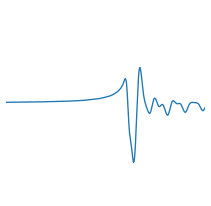

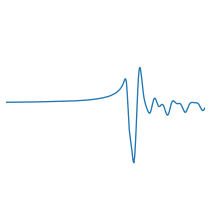

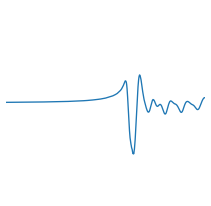

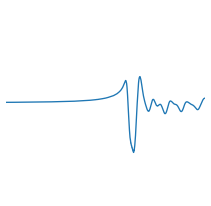

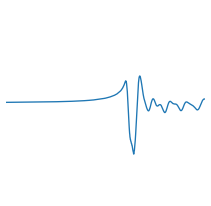

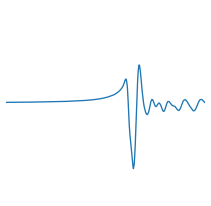

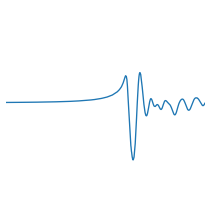

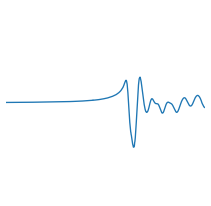

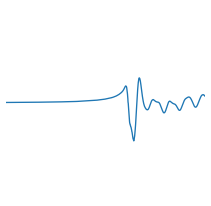

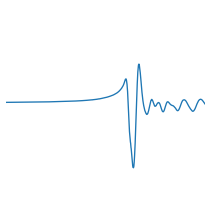

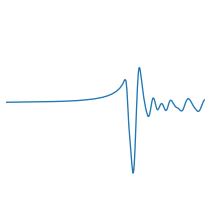

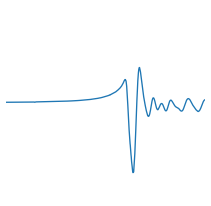

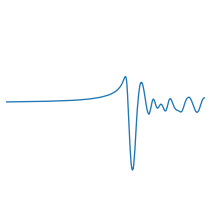

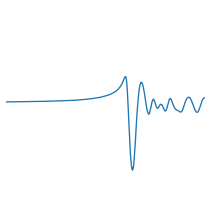

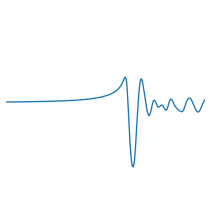

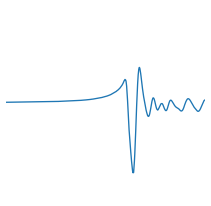

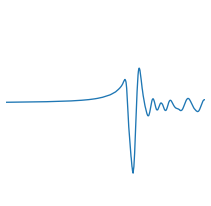

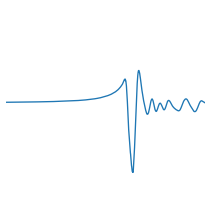

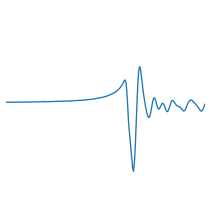

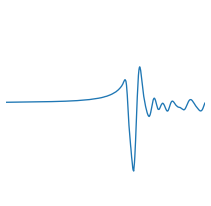

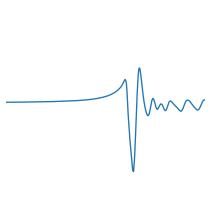

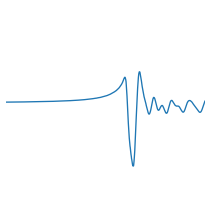

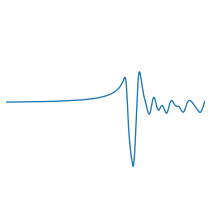

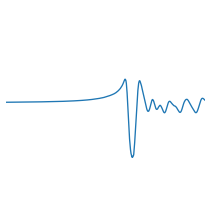

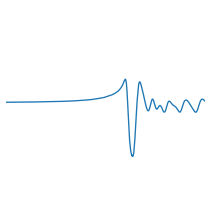

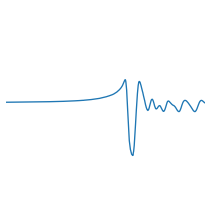

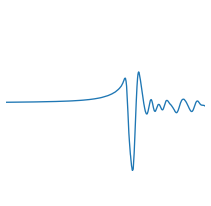

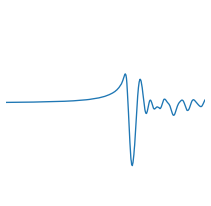

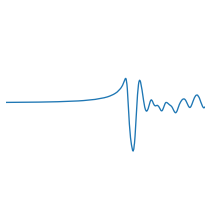

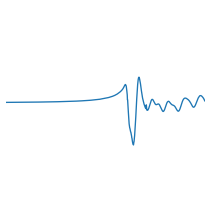

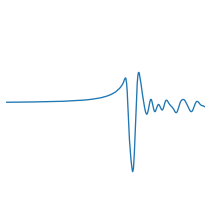

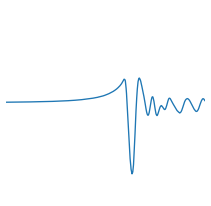

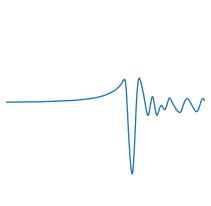

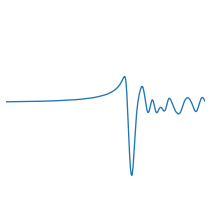

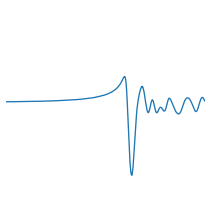

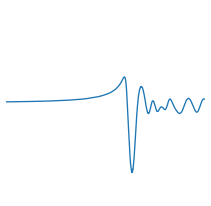

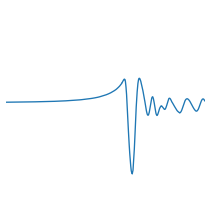

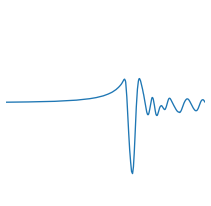

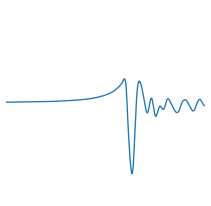

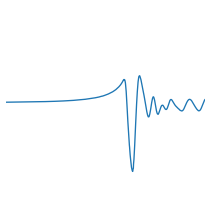

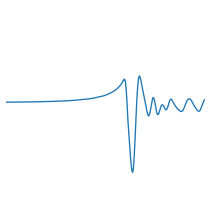

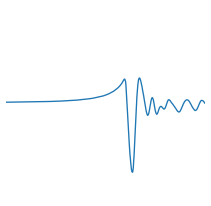

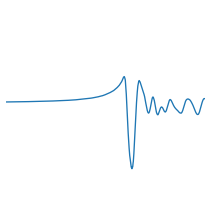

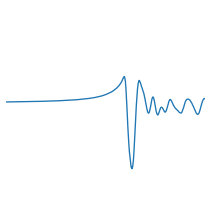

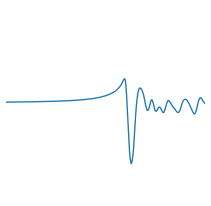

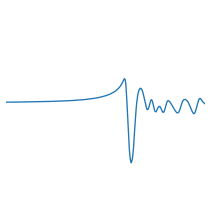

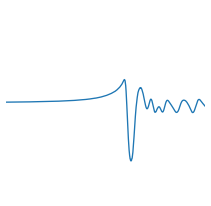

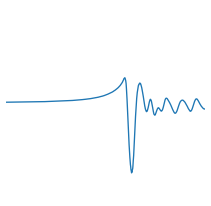

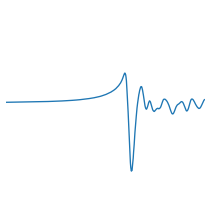

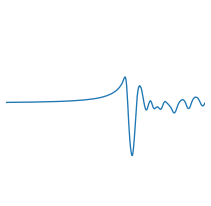

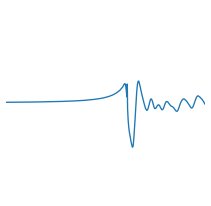

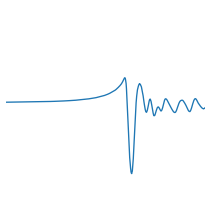

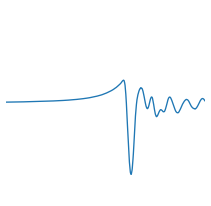

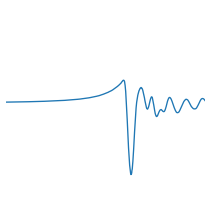

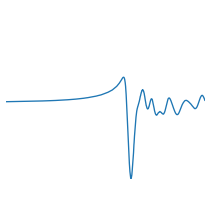

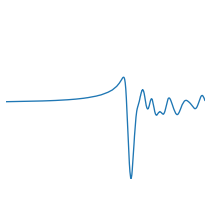

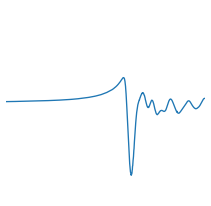

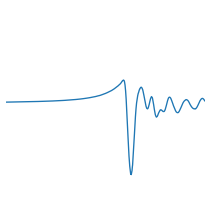

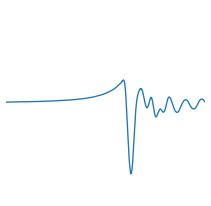

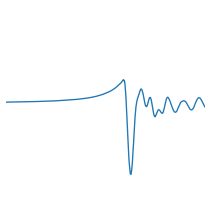

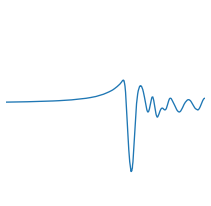

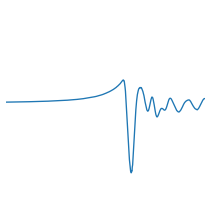

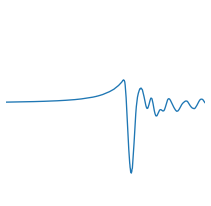

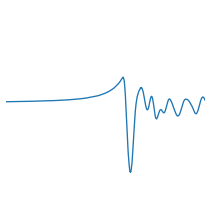

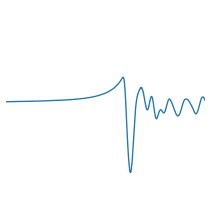

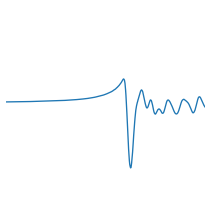

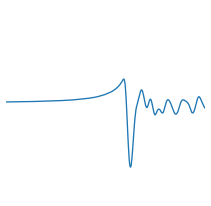

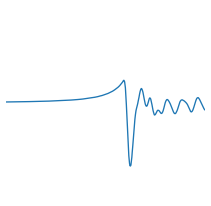

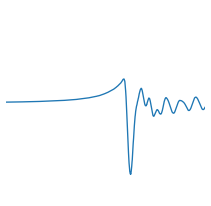

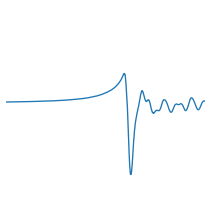

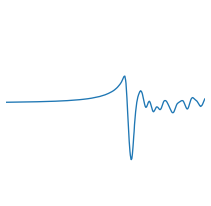

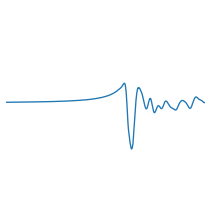

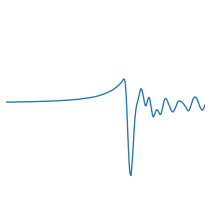

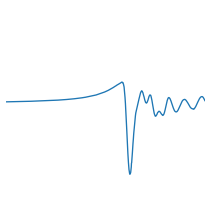

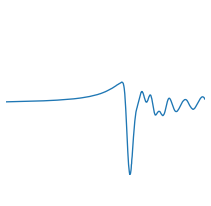

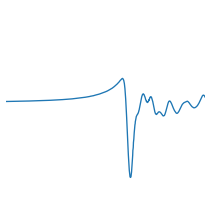

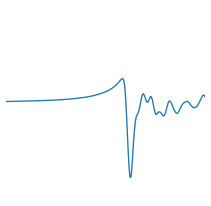

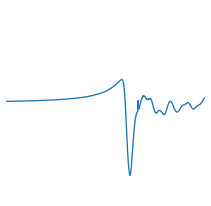

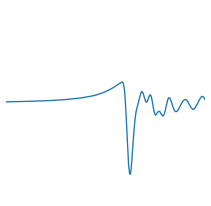

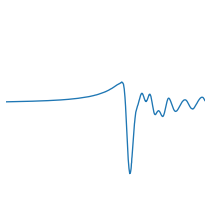

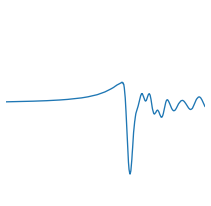

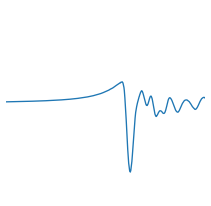

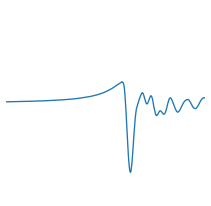

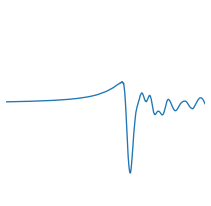

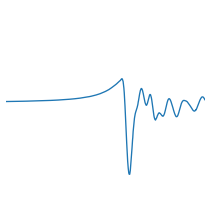

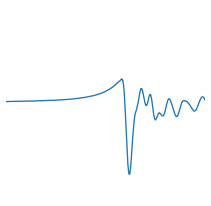

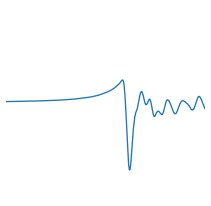

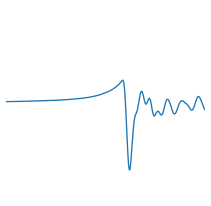

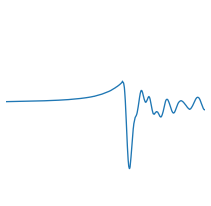

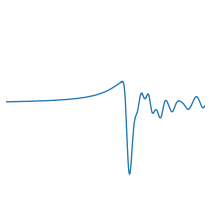

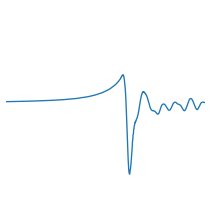

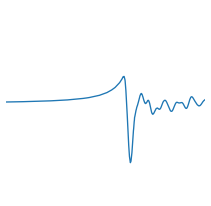

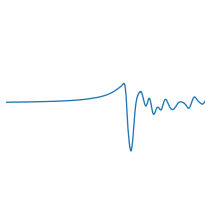

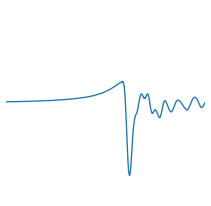

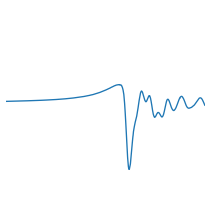

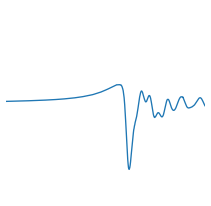

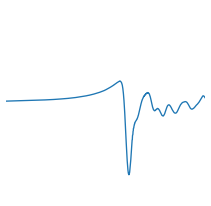

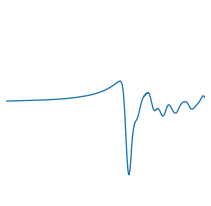

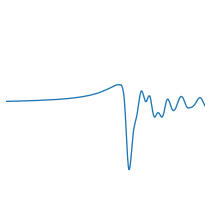

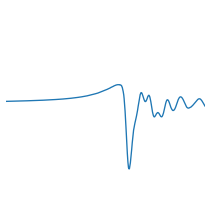

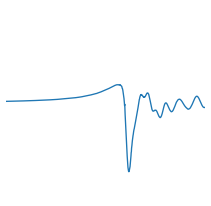

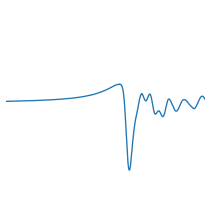

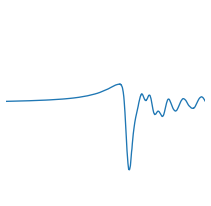

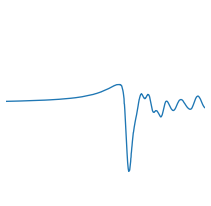

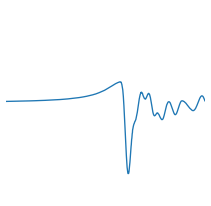

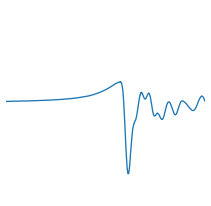

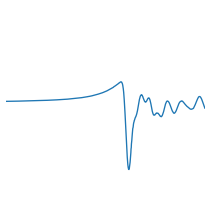

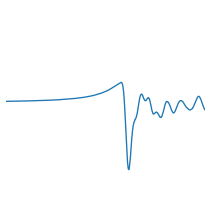

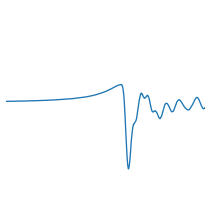

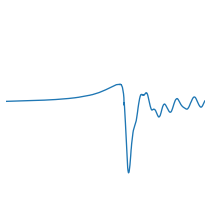

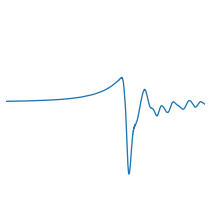

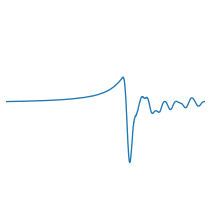

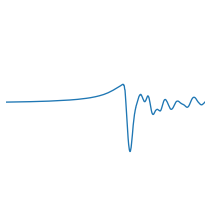

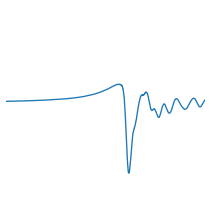

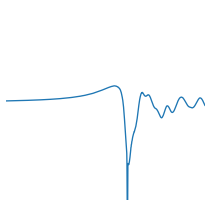

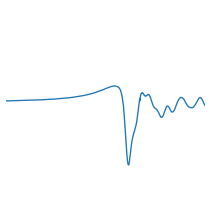

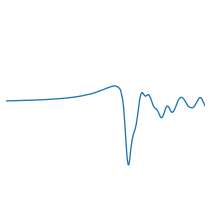

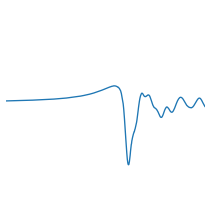

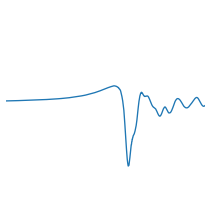

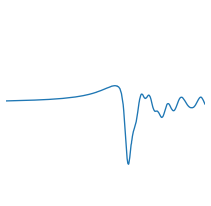

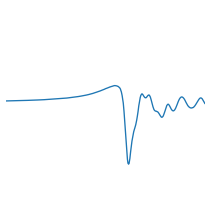

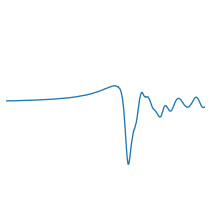

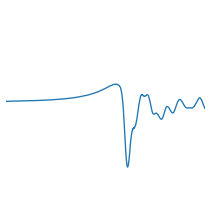

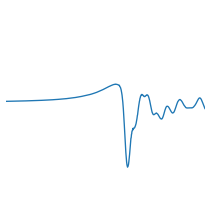

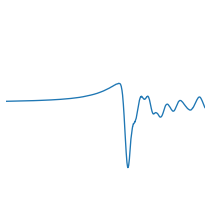

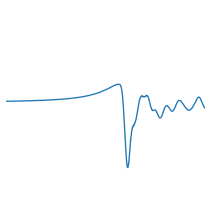

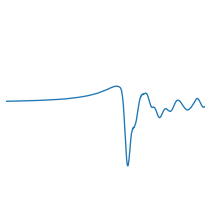

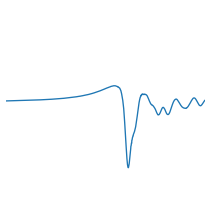

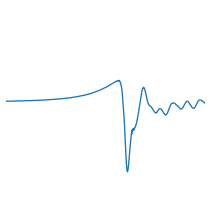

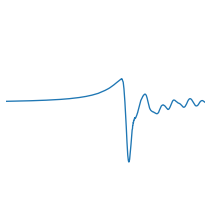

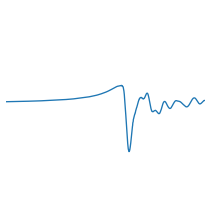

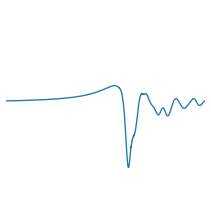

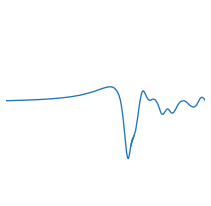

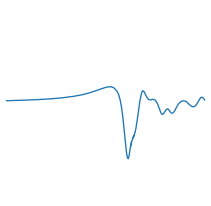

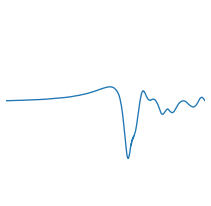

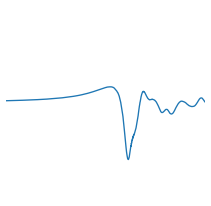

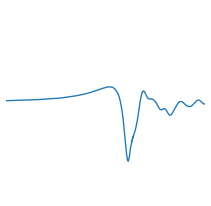

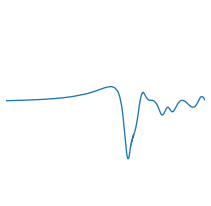

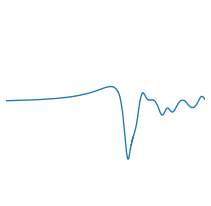

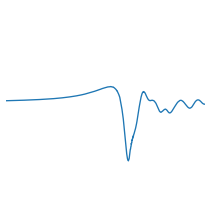

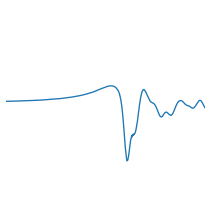

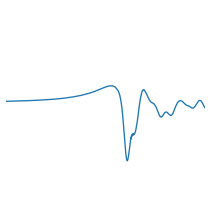

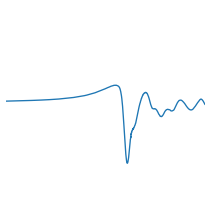

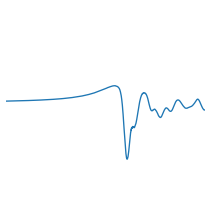

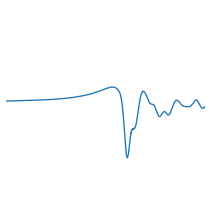

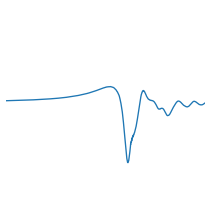

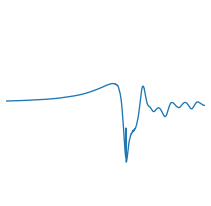

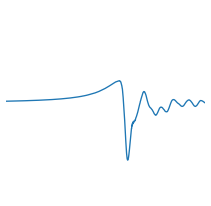

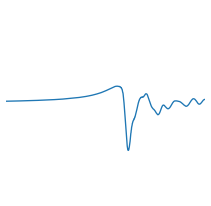

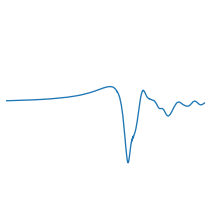

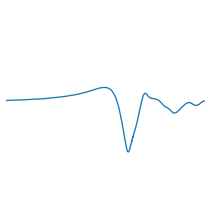

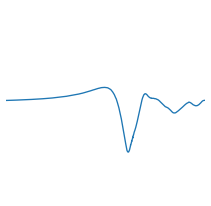

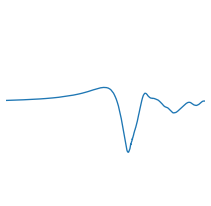

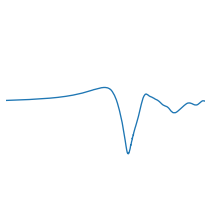

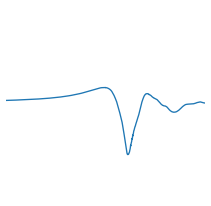

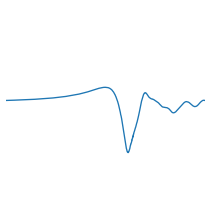

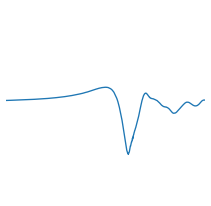

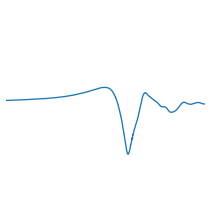

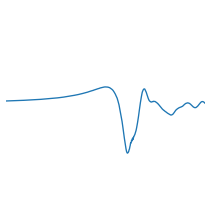

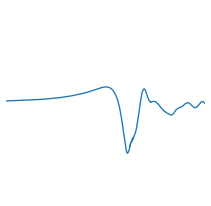

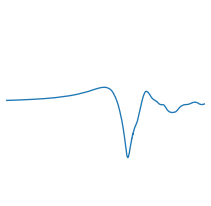

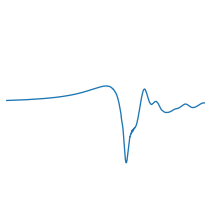

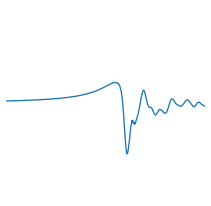

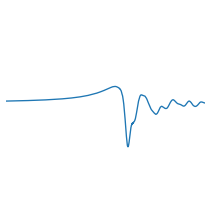

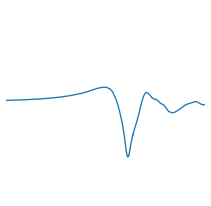

In [9]:
prepare_x_image(f, fail_list, './Final_EOS')

## Get data with augmentation(skip it if we don't need augmentation)

In [ ]:
# todo: def aug_x_image()

In [ ]:
#get the label of the data for EOS
labels = []
index = 0
index_fail = 0
for item in f['reduced_data']['EOS']:
    if(index != fail_list[index_fail]):
        labels.append(str(item))
    else:
        labels.append(-1)
        index_fail += 1
    index += 1

In [ ]:
labels = []
index = 0
index_fail = 0
for a in f['waveforms']:
    if(index != fail_list[index_fail]):
        labels.append(float(a.split('_')[0].split('w')[0].split('A')[1]))
    else:
        labels.append(-1)
        index_fail += 1
    index += 1

In [ ]:
#tranform the label to what it should be.
labels = np.array(labels)
labels = np.where(labels == "b'SFHo_ecapture_0.1'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_1.0'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_10.0'", "b'SFHo'", labels)

<ipython-input-37-333449b7f6ef>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels = np.where(labels == "b'SFHo_ecapture_0.1'", "b'SFHo'", labels)


In [ ]:
[0:-1]true_list = []
for i in range(1824):
    if i not in fail_list:
        true_list.append(i)

In [ ]:
train_num = np.random.choice(true_list, 1234, replace=False)

In [ ]:
test_list = []
for i in range(1824):
    if i not in fail_list:
        if i not in train_num:
            test_list.append(i)

In [ ]:
test_num = np.random.choice(test_list, 265, replace=False)

In [ ]:
#read random image data.
from PIL import Image
import numpy as np
X_train = []
y_train = []
for i in train_num:
    for j in range(5):
        title = 'image_aug/'+ str(i) + "_" + str(j) + '.jpeg'
        image = Image.open(title).convert('L')
        X_train.append(np.array(image))
        y_train.append(labels[i])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape

(6170, 256, 256)

In [ ]:
X_test = []
y_test = []
for i in test_num:
    title = 'image_64_normalization(-0.02, 0.05))/'+ str(i) + '.jpeg'
    image = Image.open(title).convert('L')
    X_test.append(np.array(image))
    y_test.append(labels[i])

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape

(265, 256, 256, 1)

In [ ]:
validation_list = []
for i in range(1824):
    if i not in fail_list:
        if i not in train_num:
            if i not in test_num:
                validation_list.append(i)

In [ ]:
X_validation = []
y_validation = []
for i in validation_list:
    title = 'image_64_normalization(-0.02, 0.05))/'+ str(i) + '.jpeg'
    image = Image.open(title).convert('L')
    X_validation.append(np.array(image))
    y_validation.append(labels[i])

In [ ]:
X_validation = np.array(X_validation)

## Get data with no Augmentation

In [ ]:
#read image data.
from PIL import Image
import numpy as np
data = []
index = 0
for item in f['waveforms']:
    if(item not in fail_list):
        #if(index in A_num):
        #for j in range(5):
            title = 'Final_EOS/'+ str(index) + '.jpeg'
            #title = 'A/'+ str(i) + '.jpeg'
            image = Image.open(title).convert('L')
            data.append(np.array(image))
    index += 1

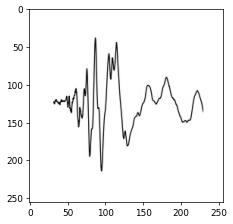

In [ ]:
#check the data.
plt.figure(figsize=(4, 4), dpi=64)
plt.imshow(data[0], cmap='gray')

In [ ]:
#transform the data type to numpy array
data = np.array(data)
data.shape

(1764, 256, 256)

# Model

## Import Packages and Set the ENV
Need to use GPU/TPU in the "runtime type" in Colab.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.utils import np_utilsy
from keras import backend as K
import os
import gc
from PIL import Image
import numpy as np

## Load cleaned data

In [ ]:
def load_x_image(f, fail_list, input_folder='./ftr', time_range=[-0.01, 0.006], resolution={'figsize':(4, 4),'dpi':64}, ftype='jpeg', turn_array=True):
  '''
  Load in features (image), and turn images into array or not.
  f: h5 file.
  fail_list: list.
  input_folder: str.
  time_range: list.
  resolution: dict. Default=256*256.
  ftype: str. The file type.
  turn_array: boolean. whether to turn a list of images into arrays.
  return: list/array. The a list of images or image arrays.
  '''
  # create input file name
  w = resolution['figsize'][0]*resolution['dpi']
  h = resolution['figsize'][1]*resolution['dpi']
  fname0 = "img%s*%s_%sto%s" % (str(w), str(h), str(time_range[0]), str(time_range[1]))

  # load x images
  data = []
  index = 0
  for item in f['waveforms']:
      if(item not in fail_list):
          # load path
          fname = "%s/%s_%s.%s" % (input_folder, str(index), fname0, ftype)
          image = Image.open(fname).convert('L')
          data.append(np.array(image))
      index += 1

  #transform the data type to numpy array
  if turn_array:
      data = np.array(data)

  return data

In [ ]:
data = load_x_image(f, fail_list, input_folder='./Final_EOS')

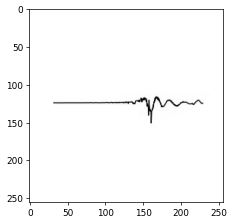

In [ ]:
#check the data.
data = load_x_image(f, fail_list, input_folder='./Final_EOS', turn_array=False)
plt.figure(figsize=(4, 4), dpi=64)
plt.imshow(data[0], cmap='gray')

## Training cofigs

In [ ]:
# def transfer_x_shape(x, resolution={'figsize':(4, 4),'dpi':64}):
#   '''
#   Transfer the data shape for model training.
#   x: array.
#   resolution: dict. Default=256*256.
#   return: array.
#   '''
#   w = resolution['figsize'][0]*resolution['dpi']
#   h = resolution['figsize'][1]*resolution['dpi']
#   x = x.reshape(x.shape[0], w, h, 1)
#   return x

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

In [ ]:
# X_train = transfer_x_shape(X_train)
# X_train.shape

(1411, 256, 256, 1)

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=5)
#X_train, X_test, X_fpeak_train, X_fpeak_test, y_train, y_test = train_test_split(data,fpeak,labels,test_size=0.2,random_state=5)

In [ ]:
#further split the data into test and validation
#X_test, X_validation, y_test, y_validation = train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [ ]:
X_train.shape

(1411, 256, 256)

In [ ]:
#transfer the data shape for model training
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)
#X_fpeak_train = X_fpeak_train.reshape(X_fpeak_train.shape[0], 1)
#X_fpeak_test = X_fpeak_test.reshape(X_fpeak_test.shape[0], 1)
#X_validation = X_validation.reshape(X_validation.shape[0], 256, 256, 1)

In [ ]:
#using one hot to encode the label.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers import Concatenate
from keras.models import Model

In [ ]:
#y_train = np.array(y_train)
#y_test = np.array(y_test)

## Model configs

In [ ]:
# todo: class CNN()

In [ ]:
#our model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(18, activation='softmax'))
#model.add(Dense(1, activation='relu'))
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
#optimizer = keras.optimizers.Adam(learning_rate=0.000003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
#model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

## Train model

In [ ]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)
#history = model.fit(x=[X_train, X_fpeak_train], y=y_train, validation_data=([X_test, X_fpeak_test], y_test), epochs=200, batch_size=32)

Epoch 1/100
45/45 [==============================] - 6s 120ms/step - loss: 5.9512 - acc: 0.0581 - val_loss: 2.9272 - val_acc: 0.1020
Epoch 2/100
45/45 [==============================] - 5s 111ms/step - loss: 3.0769 - acc: 0.0657 - val_loss: 2.9176 - val_acc: 0.1020
Epoch 3/100
45/45 [==============================] - 5s 112ms/step - loss: 2.9883 - acc: 0.0617 - val_loss: 2.8910 - val_acc: 0.1020
Epoch 4/100
45/45 [==============================] - 5s 111ms/step - loss: 2.9370 - acc: 0.0634 - val_loss: 2.8835 - val_acc: 0.0992
Epoch 5/100
45/45 [==============================] - 5s 112ms/step - loss: 2.9477 - acc: 0.0480 - val_loss: 2.8737 - val_acc: 0.0623
Epoch 6/100
45/45 [==============================] - 5s 115ms/step - loss: 2.9297 - acc: 0.0486 - val_loss: 2.8787 - val_acc: 0.1020
Epoch 7/100
45/45 [==============================] - 5s 112ms/step - loss: 2.9065 - acc: 0.0630 - val_loss: 2.8848 - val_acc: 0.0992
Epoch 8/100
45/45 [==============================] - 5s 112ms/step - 

45/45 [==============================] - 5s 112ms/step - loss: 2.0185 - acc: 0.2892 - val_loss: 2.2767 - val_acc: 0.1841
Epoch 63/100
45/45 [==============================] - 5s 111ms/step - loss: 1.9751 - acc: 0.2902 - val_loss: 2.2860 - val_acc: 0.1955
Epoch 64/100
45/45 [==============================] - 5s 111ms/step - loss: 1.9635 - acc: 0.3223 - val_loss: 2.2455 - val_acc: 0.2096
Epoch 65/100
45/45 [==============================] - 5s 111ms/step - loss: 1.9258 - acc: 0.3114 - val_loss: 2.2997 - val_acc: 0.1870
Epoch 66/100
45/45 [==============================] - 5s 111ms/step - loss: 1.9308 - acc: 0.3269 - val_loss: 2.2968 - val_acc: 0.1756
Epoch 67/100
45/45 [==============================] - 5s 111ms/step - loss: 1.8536 - acc: 0.3364 - val_loss: 2.2541 - val_acc: 0.2040
Epoch 68/100
45/45 [==============================] - 5s 111ms/step - loss: 1.8459 - acc: 0.3643 - val_loss: 2.2734 - val_acc: 0.1870
Epoch 69/100
45/45 [==============================] - 5s 111ms/step - loss:

## Evaluate model

In [ ]:
#check the accuracy.
answer = model.predict(X_validation)
index = 0
correct = 0
for item in answer:
    if(abs(item - y_validation[index]) <= 0.25):
        correct += 1
    index += 1
correct/index

0.6666666666666666

In [ ]:
#check the accuracy.
answer = np.argmax(model.predict(X_validation), axis=1)
answer_onehot = np.zeros((answer.size, answer.max()+1))
answer_onehot[np.arange(answer.size),answer] = 1
answer_decode = label_decode(label_encoder, answer_onehot)
index = 0
correct = 0
for item in answer_decode:
    if(item == y_validation[index]):
        correct += 1
    index += 1
correct/index

0.0

In [ ]:
#our model adding fpeak
a1 = Input(shape=(256, 256, 1))
a2 = Conv2D(64, (5, 5), padding="same", activation='relu')(a1)
a3 = MaxPooling2D(pool_size=(2, 2))(a2)
a4 = Conv2D(128, (5, 5), padding="same", activation='relu')(a3)
a5 = MaxPooling2D(pool_size=(2, 2))(a4)
a6 = Conv2D(256, (5, 5), padding="same", activation='relu')(a5)
a7 = MaxPooling2D(pool_size=(2, 2))(a6)
a8 = Conv2D(256, (3, 3), padding="same", activation='relu')(a7)
a9 = MaxPooling2D(pool_size=(2, 2))(a8)
a10 = Conv2D(256, (3, 3), padding="same", activation='relu')(a9)
a11 = MaxPooling2D(pool_size=(2, 2))(a10)
a12 = Dropout(0.5)(a11)
a13 = Flatten()(a12)
a14 = Dense(1024, activation='relu')(a13)


b1 = Input(shape=(1,))
b2 = Activation('relu')(b1)

concat = Concatenate()([a14, b2])
a15 = Dense(512, activation='relu')(concat)
a16 = Dense(128, activation='relu')(a15)
outputs = Dense(32, activation='softmax')(a16)

model = keras.Model(inputs=[a1, b1], outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Confusion matrix, without normalization
[[ 4  0  0  0  1  0  0]
 [ 0 14  0  0  0  1  0]
 [ 0  3 15  0  0  0  2]
 [ 0  0  0  2  1  0  0]
 [ 1  2  0  0 12  1  0]
 [ 0  0  0  0  1  6  0]
 [ 0  0  0  0  0  0 16]]


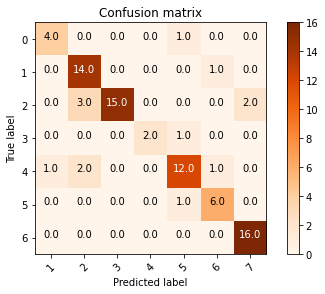

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_validation, answer_decode)
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')aot
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)

plt.show()

## Save model

In [ ]:
model.save('model_GW_W_76%.h5')

## Load model

In [ ]:
model = keras.models.load_model('model_GW_W_76%.h5')

# Experiments

## Original pipeline

In [ ]:
exp_dict = {
    'target': 'EOS',
    'ftr_folder': './Final_EOS', 'time_range': [-0.01, 0.006], 'resolution': {'figsize':(4, 4),'dpi':64}, 'ftype': 'jpeg',
    'test_size': 0.2,
    'random_seed': 5
}


#===============================================================================
print('Preparing Data...')
start = timeit.default_timer()

# Colab: download data from web
if not os.path.isfile('./GWdatabase.h5'):
    !wget -O GWdatabase.h5 https://zenodo.org/record/201145/files/GWdatabase.h5?download=1
# read database.
f = h5py.File('GWdatabase.h5','r')
# create a list that contains all the failure cases.
fail_num, fail_case, fail_list = list_fail_case(f)


# Create y
labels = prepare_y(f, fail_list, exp_dict['target'])
# Create image x
prepare_x_image(f, fail_list, exp_dict['ftr_folder'], exp_dict['time_range'], exp_dict['resolution'], exp_dict['ftype'], overwrite=False)
# Todo: Data augmentation


stop = timeit.default_timer()
print('Done! Time =', stop - start)


#===============================================================================
print('Training model...')
start = timeit.default_timer()

# Load cleaned data
# Todo: load data w/ augmentation
data = load_x_image(f, fail_list, exp_dict['ftr_folder'], exp_dict['time_range'], exp_dict['resolution'], exp_dict['ftype'])


# Training config
# split the data
X_train, X_test, y_train, y_test = train_test_split(data,labels,exp_dict['test_size'],random_state=5)
# transfer the shape of image data for model training
w = exp_dict['resolution']['figsize'][0]*exp_dict['resolution']['dpi']
h = exp_dict['resolution']['figsize'][1]*exp_dict['resolution']['dpi']
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)
#using one hot to encode the label.
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)


# Model config
# Todo: turn into class
#our model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(18, activation='softmax'))
#model.add(Dense(1, activation='relu'))
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
#optimizer = keras.optimizers.Adam(learning_rate=0.000003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
#model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])


# Train
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)


# Evaluate
# Todo: 1. what's the different btw 2 check for accuracy?
#       2. X_validation == X_test?
# #1. check the accuracy.
# answer = model.predict(X_validation)
# index = 0
# correct = 0
# for item in answer:
#     if(abs(item - y_validation[index]) <= 0.25):
#         correct += 1
#     index += 1
# acc = correct/index
#2. check the accuracy.
answer = np.argmax(model.predict(X_validation), axis=1)
answer_onehot = np.zeros((answer.size, answer.max()+1))
answer_onehot[np.arange(answer.size),answer] = 1
answer_decode = label_decode(label_encoder, answer_onehot)
index = 0
correct = 0
for item in answer_decode:
    if(item == y_validation[index]):
        correct += 1
    index += 1
acc = correct/index
#plot confusion matrix
cm = confusion_matrix(y_validation, answer_decode)
np.set_printoptions(precision=1) 
print('Confusion matrix, without normalization')aot
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.show()


# Save model & result
# Todo: save model will also save prediction result?
model.save('model_GW_W_76%.h5')
# Load model
model = keras.models.load_model('model_GW_W_76%.h5')

stop = timeit.default_timer()
print('Done! Time =', stop - start)


## Multiple train & test sets

# Check new data 

In [ ]:
#check the accuracy of the new data
from PIL import Image
import numpy as np
X_validation = []
for index in range(9):
    title = 'test/'+ str(index) + '.jpeg'
    image = Image.open(title).convert('L')
    X_validation.append(np.array(image))
X_validation = np.array(X_validation)
X_validation = X_validation.reshape(X_validation.shape[0], 256, 256, 1)
answer = np.argmax(model.predict(X_validation), axis=1)
answer_onehot = np.zeros((answer.size, answer.max()+1))
answer_onehot[np.arange(answer.size),answer] = 1
answer_decode = label_decode(label_encoder, answer_onehot)

# Utils

In [ ]:
f2 = h5py.File('noise_data.hdf5','r')   
f2.keys()
noise = f2['strain']['Strain']

<KeysViewHDF5 ['meta', 'quality', 'strain']>

In [ ]:
labels = np.where(labels == "b'BHBL'", "B", labels)
labels = np.where(labels == "b'BHBLP'", "B", labels)
labels = np.where(np.unique(labels == "b'GShenFSU1.7'", "G", labels)
labels = np.where(labels == "b'GShenFSU2.1'", "G", labels)
labels = np.where(labels == "b'GShenNL3'", "G", labels)
labels = np.where(labels == "b'HSDD2'", "H", labels)
labels = np.where(labels == "b'HSFSG'", "H", labels)
labels = np.where(labels == "b'HSIUF'", "H", labels)
labels = np.where(labels == "b'HSNL3'", "H", labels)
labels = np.where(labels == "b'HSTM1'", "H", labels)
labels = np.where(labels == "b'HSTMA'", "H", labels)
labels = np.where(labels == "b'HShen'", "H", labels)
labels = np.where(labels == "b'HShenH'", "H", labels)
labels = np.where(labels == "b'LS180'", "L", labels)
labels = np.where(labels == "b'LS220'", "L", labels)
labels = np.where(labels == "b'LS375'", "L", labels)
labels = np.where(labels == "b'SFHo'", "S", labels)
labels = np.where(labels == "b'SFHx'", "S", labels)

In [ ]:
#tranform the label to what it should be.
labels = np.array(labels)
labels = np.where(labels == "b'SFHo_ecapture_0.1'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_1.0'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_10.0'", "b'SFHo'", labels)

In [ ]:
from scipy import signal
data = []
index = 0
for item in f['waveforms']:
    if(index not in fail_list):
        if(index in A_num):
#             Timestamp = np.array(f['waveforms'][item]['t-tb(s)'])
#             F_index = np.where(Timestamp>=-0.03)[0][0]
#             S_index = np.where(Timestamp<=0.07)[0][-1]
            data.append(signal.resample(np.array(f['waveforms'][item]['strain*dist(cm)']),12000))
    index += 1
np.array(data).shape
from keras.layers import GRU, LSTM, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras import regularizers
data = np.array(data)
data = data.reshape(data.shape[0], 1, 12000)
model = Sequential()
model.add(GRU(500, input_shape = (1,12000), return_sequences = False))
#model.add(GRU(300, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(GRU(100, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(GRU(100, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(GRU(100, return_sequences = False))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16)

In [ ]:
#paper's model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(18, activation='softmax'))
optimizer = keras.optimizers.RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])